Stainless Steel Data Set
http://www.worldstainless.org/statistics/foreign_trade_stainless_scrap

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


logging.getLogger().setLevel(logging.ERROR)
from sklearn.preprocessing import PolynomialFeatures

from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor

from sqlalchemy import create_engine
from sqlalchemy import(Table, Column, String, Integer, Boolean)
from sqlalchemy import MetaData, Table

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import os


In [2]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
#LME_futures = LME_futures[LME_futures.index.year>=2000]
LME_futures.isnull().sum()

LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)
LME = LME.resample('B').mean()

inventory = LME_futures.iloc[:, 1]
inventory = inventory.astype(float)
inventory = inventory.resample('B').mean()



In [3]:
china_gdp = pd.read_csv('forecasting_raw_data/nickel_features/china_gdp_by_quarter.csv')
china_gdp = china_gdp.set_index(pd.to_datetime(china_gdp['DATE']))
china_gdp = china_gdp.iloc[:, 1]

#china_gdp = china_gdp.reindex(LME.index)
china_gdp = china_gdp.resample('B')
upsampled = china_gdp.interpolate(method='linear')

upsampled.head()

LME = LME[upsampled.index]


### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [4]:
def preprocess(series, window_setting):
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

    

In [5]:
'''Returns unscaled y values BUT MUST ASSIGN INDEX AFTER FUNCTION! '''
def unscale(series, original_tail, window_setting):
    unscaled = []
    for key, item in series.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))
        unscaled.append(unscaled_result)
        
    unscaled = pd.Series(unscaled)
    unscaled = unscaled
    return unscaled

LME_shifted = LME.shift(-261).dropna()


#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [6]:

# Rolling Average from last 8 weeks
window_setting= 5*4
LME_stationary = preprocess(LME, window_setting)
inventory_stationary=preprocess(inventory, window_setting)
upsampled_stationary = preprocess(upsampled, window_setting)



rcParams['figure.figsize'] = 9, 6

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'lag0'])
df.head()

# How many lag periods? - LAG DAYS
lag_length = 20

df['lag1'] = df.lag0.shift(periods=1*lag_length)
df['lag2'] = df.lag0.shift(periods=2*lag_length)
df['lag3'] = df.lag0.shift(periods=3*lag_length)
df['lag4'] = df.lag0.shift(periods=4*lag_length)
df['lag5'] = df.lag0.shift(periods=5*lag_length)

df['lag6'] = df.lag0.shift(periods=6*lag_length)
df['lag7'] = df.lag0.shift(periods=7*lag_length)
df['lag8'] = df.lag0.shift(periods=8*lag_length)
df['lag9'] = df.lag0.shift(periods=9*lag_length)
df['lag10'] = df.lag0.shift(periods=10*lag_length)

df.index = df['ds']
df = df.iloc[:, 1:]
#df['inventory'] = inventory[df.index[0]: df.index[len(df)-1]]
df['gdp'] = upsampled_stationary

df['y'] = df['lag0'].shift(-261)
df = df.dropna()
df.head()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,gdp,y
ds,,,,,,,,,,,,,
1992-11-04,-338.45,-182.25,-314.90,-187.75,59.20,-106.00,-73.75,95.50,-283.15,83.4,190.15,-2.259409e+10,81.45
1992-11-05,-365.35,-157.35,-300.15,-162.95,114.40,-92.85,-61.90,83.00,-185.65,50.9,165.40,-2.259409e+10,225.95
1992-11-06,-543.40,-194.20,-248.45,-155.50,122.40,-113.80,-51.20,28.65,-123.30,-95.6,155.40,-2.259409e+10,169.95
1992-11-09,-646.90,-226.95,-229.60,-154.60,102.70,-113.20,-44.85,63.15,-86.30,-254.6,162.65,-2.259409e+10,108.80
1992-11-10,-442.15,-419.15,-134.45,-174.10,67.55,-109.15,3.50,11.40,-32.80,-369.2,110.25,-2.259409e+10,83.90


### Splitting up Training/Testing by Day

- Train multiple models on 261*16=4176 days versus Tests of 261 AND 522 days (1 and 2 years)

How to normalize/standardize: 
https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

In [7]:
dates = df.index

In [8]:
np.sqrt(261*13)

58.249463516842795

In [89]:
results = []
datelist = []
paramlist = []

for item in dates[dates.year<2003]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=13*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    

    
    X_train = train[['gdp','lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['gdp', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']

    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)
    
    #X_train = preprocessing.scale(X_train)
    #X_test = preprocessing.scale(X_test)
    
    scalerX = StandardScaler()
    X_train = scalerX.fit_transform(X_train)
    X_test = scalerX.transform(X_test)

    
    #scalerX = StandardScaler().fit(X_train)
    #scalery = StandardScaler().fit(y_train)
    
    #X_train = scalerX.transform(X_train)
    #y_train = scalery.transform(y_train)
    #X_test = scalerX.transform(X_test)
    #y_test = scalery.transform(y_test)
    
    
    cv_results={}

    
    for K in range(0, 60, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
    #or key, value in cv_results.items():
        #rint(key, value)
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)

    

2005-11-08 00:00:00 , Optimal K: 53 , MAE: 7466.931076422762
2005-11-09 00:00:00 , Optimal K: 59 , MAE: 7527.779174359982
2005-11-10 00:00:00 , Optimal K: 59 , MAE: 7582.443324572039
2005-11-11 00:00:00 , Optimal K: 59 , MAE: 7660.907423173981
2005-11-14 00:00:00 , Optimal K: 59 , MAE: 7714.288408119133
2005-11-15 00:00:00 , Optimal K: 59 , MAE: 7783.53121363909
2005-11-16 00:00:00 , Optimal K: 59 , MAE: 7827.236333047021
2005-11-17 00:00:00 , Optimal K: 59 , MAE: 7880.844572955259
2005-11-18 00:00:00 , Optimal K: 59 , MAE: 7927.027219193482
2005-11-21 00:00:00 , Optimal K: 59 , MAE: 7957.313962797266
2005-11-22 00:00:00 , Optimal K: 1 , MAE: 7906.8622698903
2005-11-23 00:00:00 , Optimal K: 1 , MAE: 7928.582629394589
2005-11-24 00:00:00 , Optimal K: 1 , MAE: 7822.006220598593
2005-11-25 00:00:00 , Optimal K: 1 , MAE: 7817.109388646261
2005-11-28 00:00:00 , Optimal K: 1 , MAE: 7733.519050366031
2005-11-29 00:00:00 , Optimal K: 1 , MAE: 7722.754118113799
2005-11-30 00:00:00 , Optimal K: 

2006-05-17 00:00:00 , Optimal K: 1 , MAE: 25976.461317083522
2006-05-18 00:00:00 , Optimal K: 1 , MAE: 25058.375082652845
2006-05-19 00:00:00 , Optimal K: 1 , MAE: 25695.170229447554
2006-05-22 00:00:00 , Optimal K: 1 , MAE: 26232.571963028484
2006-05-23 00:00:00 , Optimal K: 1 , MAE: 25710.488460563516
2006-05-24 00:00:00 , Optimal K: 1 , MAE: 25416.27454485567
2006-05-25 00:00:00 , Optimal K: 1 , MAE: 23933.93754587308
2006-05-26 00:00:00 , Optimal K: 1 , MAE: 24350.158224805924
2006-05-29 00:00:00 , Optimal K: 1 , MAE: 24486.134271795472
2006-05-30 00:00:00 , Optimal K: 1 , MAE: 24876.096256834462
2006-05-31 00:00:00 , Optimal K: 1 , MAE: 24156.758294996842
2006-06-01 00:00:00 , Optimal K: 1 , MAE: 23045.695563551904
2006-06-02 00:00:00 , Optimal K: 1 , MAE: 21860.996743233867
2006-06-05 00:00:00 , Optimal K: 1 , MAE: 21950.555501056628
2006-06-06 00:00:00 , Optimal K: 1 , MAE: 21394.464351807885
2006-06-07 00:00:00 , Optimal K: 1 , MAE: 20685.16857123702
2006-06-08 00:00:00 , Optim

2006-11-22 00:00:00 , Optimal K: 53 , MAE: 10525.646181044165
2006-11-23 00:00:00 , Optimal K: 51 , MAE: 10213.263023119333
2006-11-24 00:00:00 , Optimal K: 51 , MAE: 9931.07356457625
2006-11-27 00:00:00 , Optimal K: 51 , MAE: 9686.120152443978
2006-11-28 00:00:00 , Optimal K: 55 , MAE: 9417.597576345583
2006-11-29 00:00:00 , Optimal K: 53 , MAE: 9148.891397861242
2006-11-30 00:00:00 , Optimal K: 55 , MAE: 8777.926666504633
2006-12-01 00:00:00 , Optimal K: 55 , MAE: 8469.86723357169
2006-12-04 00:00:00 , Optimal K: 57 , MAE: 8170.304849242052
2006-12-05 00:00:00 , Optimal K: 57 , MAE: 7824.880865060143
2006-12-06 00:00:00 , Optimal K: 59 , MAE: 7564.256482982285
2006-12-07 00:00:00 , Optimal K: 59 , MAE: 7396.448519418217
2006-12-08 00:00:00 , Optimal K: 59 , MAE: 7360.21341774706
2006-12-11 00:00:00 , Optimal K: 59 , MAE: 7301.191238301864
2006-12-12 00:00:00 , Optimal K: 59 , MAE: 7289.477962086546
2006-12-13 00:00:00 , Optimal K: 59 , MAE: 7293.42334831934
2006-12-14 00:00:00 , Opti

2007-05-29 00:00:00 , Optimal K: 59 , MAE: 13189.731509424962
2007-05-30 00:00:00 , Optimal K: 57 , MAE: 12817.530801650442
2007-05-31 00:00:00 , Optimal K: 59 , MAE: 12443.725657881423
2007-06-01 00:00:00 , Optimal K: 59 , MAE: 12104.927465364426
2007-06-04 00:00:00 , Optimal K: 59 , MAE: 11839.472489971631
2007-06-05 00:00:00 , Optimal K: 59 , MAE: 11611.38631996159
2007-06-06 00:00:00 , Optimal K: 59 , MAE: 11461.840885708467
2007-06-07 00:00:00 , Optimal K: 59 , MAE: 11316.177828274003
2007-06-08 00:00:00 , Optimal K: 59 , MAE: 11081.916003269082
2007-06-11 00:00:00 , Optimal K: 59 , MAE: 10896.7038513562
2007-06-12 00:00:00 , Optimal K: 59 , MAE: 10875.504447359379
2007-06-13 00:00:00 , Optimal K: 59 , MAE: 10899.226638571557
2007-06-14 00:00:00 , Optimal K: 59 , MAE: 11066.520035053585
2007-06-15 00:00:00 , Optimal K: 59 , MAE: 11148.602273836072
2007-06-18 00:00:00 , Optimal K: 59 , MAE: 11264.423269526502
2007-06-19 00:00:00 , Optimal K: 59 , MAE: 11410.461626606933
2007-06-20 

2007-12-04 00:00:00 , Optimal K: 1 , MAE: 2440.6989878077807
2007-12-05 00:00:00 , Optimal K: 1 , MAE: 2550.99151143945
2007-12-06 00:00:00 , Optimal K: 1 , MAE: 2590.3796869514217
2007-12-07 00:00:00 , Optimal K: 1 , MAE: 2677.5558529871146
2007-12-10 00:00:00 , Optimal K: 1 , MAE: 2675.3427941792047
2007-12-11 00:00:00 , Optimal K: 1 , MAE: 2671.0521026787337
2007-12-12 00:00:00 , Optimal K: 1 , MAE: 2438.596892205877
2007-12-13 00:00:00 , Optimal K: 1 , MAE: 2338.009102857342
2007-12-14 00:00:00 , Optimal K: 1 , MAE: 2293.1545889298086
2007-12-17 00:00:00 , Optimal K: 1 , MAE: 2317.42483221324
2007-12-18 00:00:00 , Optimal K: 1 , MAE: 2339.6036143973706
2007-12-19 00:00:00 , Optimal K: 1 , MAE: 2472.8544336351856
2007-12-20 00:00:00 , Optimal K: 1 , MAE: 2489.4164753303917
2007-12-21 00:00:00 , Optimal K: 1 , MAE: 2348.1544362527065
2007-12-24 00:00:00 , Optimal K: 1 , MAE: 2363.688082395293
2007-12-25 00:00:00 , Optimal K: 1 , MAE: 2488.131960075041
2007-12-26 00:00:00 , Optimal K:

2008-06-11 00:00:00 , Optimal K: 59 , MAE: 4320.459915223835
2008-06-12 00:00:00 , Optimal K: 59 , MAE: 4098.169724522521
2008-06-13 00:00:00 , Optimal K: 59 , MAE: 3916.7512356929305
2008-06-16 00:00:00 , Optimal K: 59 , MAE: 3847.0991229511906
2008-06-17 00:00:00 , Optimal K: 59 , MAE: 3772.66303445988
2008-06-18 00:00:00 , Optimal K: 59 , MAE: 3736.9048744260836
2008-06-19 00:00:00 , Optimal K: 59 , MAE: 3684.0492602124864
2008-06-20 00:00:00 , Optimal K: 59 , MAE: 3596.934362615064
2008-06-23 00:00:00 , Optimal K: 59 , MAE: 3595.873532921791
2008-06-24 00:00:00 , Optimal K: 59 , MAE: 3610.031308041691
2008-06-25 00:00:00 , Optimal K: 59 , MAE: 3551.9771430443
2008-06-26 00:00:00 , Optimal K: 59 , MAE: 3470.774807703883
2008-06-27 00:00:00 , Optimal K: 59 , MAE: 3379.433997786682
2008-06-30 00:00:00 , Optimal K: 59 , MAE: 3294.924507712827
2008-07-01 00:00:00 , Optimal K: 59 , MAE: 3255.429787784278
2008-07-02 00:00:00 , Optimal K: 59 , MAE: 3125.9481664817863
2008-07-03 00:00:00 , 

2008-12-16 00:00:00 , Optimal K: 57 , MAE: 4294.062494458133
2008-12-17 00:00:00 , Optimal K: 57 , MAE: 4208.373890447572
2008-12-18 00:00:00 , Optimal K: 57 , MAE: 4167.223069405273
2008-12-19 00:00:00 , Optimal K: 53 , MAE: 4126.947578454799
2008-12-22 00:00:00 , Optimal K: 53 , MAE: 3993.6215499094324
2008-12-23 00:00:00 , Optimal K: 53 , MAE: 3894.5998128597435
2008-12-24 00:00:00 , Optimal K: 53 , MAE: 3727.2476838653583
2008-12-25 00:00:00 , Optimal K: 53 , MAE: 3585.5383385938317
2008-12-26 00:00:00 , Optimal K: 33 , MAE: 3414.514655683124
2008-12-29 00:00:00 , Optimal K: 19 , MAE: 3274.956557818252
2008-12-30 00:00:00 , Optimal K: 19 , MAE: 3052.6889989619663
2008-12-31 00:00:00 , Optimal K: 19 , MAE: 2942.3401317278717
2009-01-01 00:00:00 , Optimal K: 1 , MAE: 2838.850641343357
2009-01-02 00:00:00 , Optimal K: 19 , MAE: 2824.678456832034
2009-01-05 00:00:00 , Optimal K: 1 , MAE: 2704.3210186558736
2009-01-06 00:00:00 , Optimal K: 19 , MAE: 2752.1843672175455
2009-01-07 00:00:0

2009-06-23 00:00:00 , Optimal K: 1 , MAE: 2466.9988175017647
2009-06-24 00:00:00 , Optimal K: 1 , MAE: 2511.1899856476634
2009-06-25 00:00:00 , Optimal K: 1 , MAE: 2501.487150499788
2009-06-26 00:00:00 , Optimal K: 1 , MAE: 2366.7415563662917
2009-06-29 00:00:00 , Optimal K: 1 , MAE: 2026.1199930348978
2009-06-30 00:00:00 , Optimal K: 1 , MAE: 2398.5146290914836
2009-07-01 00:00:00 , Optimal K: 1 , MAE: 2075.2872473383186
2009-07-02 00:00:00 , Optimal K: 1 , MAE: 2205.344989994717
2009-07-03 00:00:00 , Optimal K: 1 , MAE: 2219.0139439882114
2009-07-06 00:00:00 , Optimal K: 1 , MAE: 2242.9531694370144
2009-07-07 00:00:00 , Optimal K: 1 , MAE: 2293.7431914215767
2009-07-08 00:00:00 , Optimal K: 1 , MAE: 2336.070336057148
2009-07-09 00:00:00 , Optimal K: 1 , MAE: 2374.8329214524515
2009-07-10 00:00:00 , Optimal K: 1 , MAE: 2331.192289297861
2009-07-13 00:00:00 , Optimal K: 1 , MAE: 2324.425327913881
2009-07-14 00:00:00 , Optimal K: 1 , MAE: 2327.4385547348857
2009-07-15 00:00:00 , Optimal

2009-12-28 00:00:00 , Optimal K: 11 , MAE: 3453.149344854097
2009-12-29 00:00:00 , Optimal K: 11 , MAE: 3471.053808178248
2009-12-30 00:00:00 , Optimal K: 11 , MAE: 3473.5329053047785
2009-12-31 00:00:00 , Optimal K: 11 , MAE: 3491.1321642316702
2010-01-01 00:00:00 , Optimal K: 11 , MAE: 3534.1325356648063
2010-01-04 00:00:00 , Optimal K: 11 , MAE: 3576.5699921630944
2010-01-05 00:00:00 , Optimal K: 11 , MAE: 3629.623618927125
2010-01-06 00:00:00 , Optimal K: 11 , MAE: 3668.969399163793
2010-01-07 00:00:00 , Optimal K: 11 , MAE: 3693.655961737114
2010-01-08 00:00:00 , Optimal K: 11 , MAE: 3701.3499366463197
2010-01-11 00:00:00 , Optimal K: 11 , MAE: 3719.9739327683283
2010-01-12 00:00:00 , Optimal K: 11 , MAE: 3762.754338554581
2010-01-13 00:00:00 , Optimal K: 11 , MAE: 3830.4685610156375
2010-01-14 00:00:00 , Optimal K: 11 , MAE: 3888.8573804813345
2010-01-15 00:00:00 , Optimal K: 11 , MAE: 3951.8707495071712
2010-01-18 00:00:00 , Optimal K: 11 , MAE: 3996.2582741422875
2010-01-19 00:

2010-07-02 00:00:00 , Optimal K: 59 , MAE: 3344.049743471032
2010-07-05 00:00:00 , Optimal K: 59 , MAE: 3432.757476541506
2010-07-06 00:00:00 , Optimal K: 59 , MAE: 3522.990793439175
2010-07-07 00:00:00 , Optimal K: 59 , MAE: 3620.496711401956
2010-07-08 00:00:00 , Optimal K: 59 , MAE: 3755.4460068217804
2010-07-09 00:00:00 , Optimal K: 59 , MAE: 3895.196410781231
2010-07-12 00:00:00 , Optimal K: 59 , MAE: 3969.1546930490704
2010-07-13 00:00:00 , Optimal K: 59 , MAE: 4067.322360974147
2010-07-14 00:00:00 , Optimal K: 59 , MAE: 4196.762952690234
2010-07-15 00:00:00 , Optimal K: 59 , MAE: 4331.210469697734
2010-07-16 00:00:00 , Optimal K: 59 , MAE: 4448.7975778989685
2010-07-19 00:00:00 , Optimal K: 59 , MAE: 4520.86457889523
2010-07-20 00:00:00 , Optimal K: 59 , MAE: 4626.428119137125
2010-07-21 00:00:00 , Optimal K: 59 , MAE: 4698.714173660293
2010-07-22 00:00:00 , Optimal K: 59 , MAE: 4756.780248861468
2010-07-23 00:00:00 , Optimal K: 59 , MAE: 4798.589304168198
2010-07-26 00:00:00 , 

2011-01-05 00:00:00 , Optimal K: 59 , MAE: 1586.3217052402904
2011-01-06 00:00:00 , Optimal K: 59 , MAE: 1592.2975920274057
2011-01-07 00:00:00 , Optimal K: 59 , MAE: 1602.865262982389
2011-01-10 00:00:00 , Optimal K: 59 , MAE: 1602.8716881641258
2011-01-11 00:00:00 , Optimal K: 59 , MAE: 1617.8021532090925
2011-01-12 00:00:00 , Optimal K: 59 , MAE: 1648.5461348468452
2011-01-13 00:00:00 , Optimal K: 59 , MAE: 1687.110514775526
2011-01-14 00:00:00 , Optimal K: 59 , MAE: 1719.798811762331
2011-01-17 00:00:00 , Optimal K: 59 , MAE: 1763.3534192102522
2011-01-18 00:00:00 , Optimal K: 59 , MAE: 1800.079114151146
2011-01-19 00:00:00 , Optimal K: 59 , MAE: 1831.3480157743925
2011-01-20 00:00:00 , Optimal K: 59 , MAE: 1872.9653960790201
2011-01-21 00:00:00 , Optimal K: 59 , MAE: 1947.9307994014696
2011-01-24 00:00:00 , Optimal K: 59 , MAE: 2005.449161824028
2011-01-25 00:00:00 , Optimal K: 59 , MAE: 2080.6039856558828
2011-01-26 00:00:00 , Optimal K: 59 , MAE: 2137.236397171956
2011-01-27 00:

2011-07-13 00:00:00 , Optimal K: 1 , MAE: 1027.4356791969863
2011-07-14 00:00:00 , Optimal K: 1 , MAE: 995.8176725873924
2011-07-15 00:00:00 , Optimal K: 1 , MAE: 1003.0759138030039
2011-07-18 00:00:00 , Optimal K: 1 , MAE: 999.4189842090873
2011-07-19 00:00:00 , Optimal K: 1 , MAE: 1004.183512893854
2011-07-20 00:00:00 , Optimal K: 1 , MAE: 1007.3439116900659
2011-07-21 00:00:00 , Optimal K: 1 , MAE: 1013.4431362627616
2011-07-22 00:00:00 , Optimal K: 1 , MAE: 1018.632522666035
2011-07-25 00:00:00 , Optimal K: 1 , MAE: 1013.0524579874028
2011-07-26 00:00:00 , Optimal K: 1 , MAE: 1012.3785299216842
2011-07-27 00:00:00 , Optimal K: 1 , MAE: 1014.8200394452086
2011-07-28 00:00:00 , Optimal K: 1 , MAE: 1016.9467157964357
2011-07-29 00:00:00 , Optimal K: 1 , MAE: 1023.1119987610923
2011-08-01 00:00:00 , Optimal K: 1 , MAE: 1023.863862002457
2011-08-02 00:00:00 , Optimal K: 1 , MAE: 1031.3786802378138
2011-08-03 00:00:00 , Optimal K: 1 , MAE: 1040.8708098499742
2011-08-04 00:00:00 , Optimal

2012-01-18 00:00:00 , Optimal K: 1 , MAE: 2897.2877720331426
2012-01-19 00:00:00 , Optimal K: 1 , MAE: 2971.0698550435545
2012-01-20 00:00:00 , Optimal K: 1 , MAE: 3020.148443734993
2012-01-23 00:00:00 , Optimal K: 1 , MAE: 3024.3275120425637
2012-01-24 00:00:00 , Optimal K: 1 , MAE: 2833.7435214563748
2012-01-25 00:00:00 , Optimal K: 1 , MAE: 2895.6496833511655
2012-01-26 00:00:00 , Optimal K: 1 , MAE: 2799.434400221076
2012-01-27 00:00:00 , Optimal K: 1 , MAE: 2817.297840070824
2012-01-30 00:00:00 , Optimal K: 1 , MAE: 3332.0622395589835
2012-01-31 00:00:00 , Optimal K: 1 , MAE: 3399.535864013007
2012-02-01 00:00:00 , Optimal K: 1 , MAE: 3599.936018779955
2012-02-02 00:00:00 , Optimal K: 1 , MAE: 3640.506605636639
2012-02-03 00:00:00 , Optimal K: 1 , MAE: 3694.934975178466
2012-02-06 00:00:00 , Optimal K: 1 , MAE: 3775.5368084498004
2012-02-07 00:00:00 , Optimal K: 1 , MAE: 3778.877001354545
2012-02-08 00:00:00 , Optimal K: 1 , MAE: 3758.1544289744206
2012-02-09 00:00:00 , Optimal K:

2012-07-25 00:00:00 , Optimal K: 59 , MAE: 1661.8132019342763
2012-07-26 00:00:00 , Optimal K: 57 , MAE: 1672.4670023985436
2012-07-27 00:00:00 , Optimal K: 57 , MAE: 1668.501144718152
2012-07-30 00:00:00 , Optimal K: 57 , MAE: 1665.2025423181021
2012-07-31 00:00:00 , Optimal K: 55 , MAE: 1652.0966154843252
2012-08-01 00:00:00 , Optimal K: 59 , MAE: 1646.6642017228103
2012-08-02 00:00:00 , Optimal K: 57 , MAE: 1637.9993915114546
2012-08-03 00:00:00 , Optimal K: 57 , MAE: 1634.8890656631213
2012-08-06 00:00:00 , Optimal K: 57 , MAE: 1626.1017269477852
2012-08-07 00:00:00 , Optimal K: 57 , MAE: 1616.9958690939422
2012-08-08 00:00:00 , Optimal K: 55 , MAE: 1613.700116113599
2012-08-09 00:00:00 , Optimal K: 57 , MAE: 1624.3329776945513
2012-08-10 00:00:00 , Optimal K: 57 , MAE: 1642.9567932945713
2012-08-13 00:00:00 , Optimal K: 57 , MAE: 1669.7677872713296
2012-08-14 00:00:00 , Optimal K: 59 , MAE: 1683.6800515935588
2012-08-15 00:00:00 , Optimal K: 59 , MAE: 1723.3478958408195
2012-08-16

2013-01-29 00:00:00 , Optimal K: 5 , MAE: 1970.7702029788911
2013-01-30 00:00:00 , Optimal K: 25 , MAE: 2058.3710921939473
2013-01-31 00:00:00 , Optimal K: 25 , MAE: 2094.2815280324594
2013-02-01 00:00:00 , Optimal K: 27 , MAE: 2148.246586524754
2013-02-04 00:00:00 , Optimal K: 27 , MAE: 2173.391683709603
2013-02-05 00:00:00 , Optimal K: 27 , MAE: 2207.7219608982073
2013-02-06 00:00:00 , Optimal K: 27 , MAE: 2262.3618450144295
2013-02-07 00:00:00 , Optimal K: 27 , MAE: 2316.3985169977377
2013-02-08 00:00:00 , Optimal K: 41 , MAE: 2340.264675101476
2013-02-11 00:00:00 , Optimal K: 37 , MAE: 2355.2573448154126
2013-02-12 00:00:00 , Optimal K: 31 , MAE: 2369.200859121206
2013-02-13 00:00:00 , Optimal K: 31 , MAE: 2326.3672344951565
2013-02-14 00:00:00 , Optimal K: 7 , MAE: 2344.696252622539
2013-02-15 00:00:00 , Optimal K: 7 , MAE: 2300.9851664179205
2013-02-18 00:00:00 , Optimal K: 7 , MAE: 2171.2740494737413
2013-02-19 00:00:00 , Optimal K: 3 , MAE: 2018.1778988662577
2013-02-20 00:00:0

2013-08-06 00:00:00 , Optimal K: 5 , MAE: 5184.384021767741
2013-08-07 00:00:00 , Optimal K: 5 , MAE: 5239.981835082651
2013-08-08 00:00:00 , Optimal K: 5 , MAE: 5375.988845645465
2013-08-09 00:00:00 , Optimal K: 5 , MAE: 5330.328200556815
2013-08-12 00:00:00 , Optimal K: 5 , MAE: 5400.694701084823
2013-08-13 00:00:00 , Optimal K: 5 , MAE: 5443.8856087625845
2013-08-14 00:00:00 , Optimal K: 5 , MAE: 5447.347459381272
2013-08-15 00:00:00 , Optimal K: 7 , MAE: 5488.69163971886
2013-08-16 00:00:00 , Optimal K: 7 , MAE: 5485.081016468511
2013-08-19 00:00:00 , Optimal K: 5 , MAE: 5409.541343172457
2013-08-20 00:00:00 , Optimal K: 5 , MAE: 5415.1406314345595
2013-08-21 00:00:00 , Optimal K: 7 , MAE: 5523.336079568371
2013-08-22 00:00:00 , Optimal K: 7 , MAE: 5547.031246214211
2013-08-23 00:00:00 , Optimal K: 7 , MAE: 5612.89513799996
2013-08-26 00:00:00 , Optimal K: 1 , MAE: 5598.6007270693335
2013-08-27 00:00:00 , Optimal K: 7 , MAE: 5824.612616457055
2013-08-28 00:00:00 , Optimal K: 3 , MA

2014-02-12 00:00:00 , Optimal K: 7 , MAE: 2072.020715358936
2014-02-13 00:00:00 , Optimal K: 7 , MAE: 2144.716574619278
2014-02-14 00:00:00 , Optimal K: 9 , MAE: 2151.0666936481066
2014-02-17 00:00:00 , Optimal K: 7 , MAE: 2101.634455447325
2014-02-18 00:00:00 , Optimal K: 7 , MAE: 1973.771031279259
2014-02-19 00:00:00 , Optimal K: 1 , MAE: 1417.9873252720827
2014-02-20 00:00:00 , Optimal K: 1 , MAE: 1254.0387741747938
2014-02-21 00:00:00 , Optimal K: 1 , MAE: 1261.050424685202
2014-02-24 00:00:00 , Optimal K: 5 , MAE: 1348.7308664936945
2014-02-25 00:00:00 , Optimal K: 7 , MAE: 1397.6637978212473
2014-02-26 00:00:00 , Optimal K: 7 , MAE: 1464.5887648880541
2014-02-27 00:00:00 , Optimal K: 7 , MAE: 1479.770999437821
2014-02-28 00:00:00 , Optimal K: 7 , MAE: 1449.9388276706497
2014-03-03 00:00:00 , Optimal K: 1 , MAE: 1370.6019869829327
2014-03-04 00:00:00 , Optimal K: 7 , MAE: 1283.9843266833545
2014-03-05 00:00:00 , Optimal K: 7 , MAE: 1269.8896776794122
2014-03-06 00:00:00 , Optimal 

2014-08-20 00:00:00 , Optimal K: 59 , MAE: 1069.250440455583
2014-08-21 00:00:00 , Optimal K: 59 , MAE: 1091.373867008451
2014-08-22 00:00:00 , Optimal K: 59 , MAE: 1114.9653393844887
2014-08-25 00:00:00 , Optimal K: 59 , MAE: 1166.2487325567595
2014-08-26 00:00:00 , Optimal K: 59 , MAE: 1220.1603415440145
2014-08-27 00:00:00 , Optimal K: 59 , MAE: 1279.841930091448
2014-08-28 00:00:00 , Optimal K: 59 , MAE: 1304.3686065949928
2014-08-29 00:00:00 , Optimal K: 59 , MAE: 1335.1506844590062
2014-09-01 00:00:00 , Optimal K: 59 , MAE: 1358.573120414821
2014-09-02 00:00:00 , Optimal K: 59 , MAE: 1398.608979389861
2014-09-03 00:00:00 , Optimal K: 59 , MAE: 1440.5051893905882
2014-09-04 00:00:00 , Optimal K: 59 , MAE: 1462.6293879512734
2014-09-05 00:00:00 , Optimal K: 59 , MAE: 1478.365746138988
2014-09-08 00:00:00 , Optimal K: 59 , MAE: 1504.3304226132263
2014-09-09 00:00:00 , Optimal K: 59 , MAE: 1510.0963588671773
2014-09-10 00:00:00 , Optimal K: 59 , MAE: 1506.460156570302
2014-09-11 00:0

2015-02-24 00:00:00 , Optimal K: 59 , MAE: 4264.845012027759
2015-02-25 00:00:00 , Optimal K: 59 , MAE: 4228.687008999153
2015-02-26 00:00:00 , Optimal K: 59 , MAE: 4226.8868840498735
2015-02-27 00:00:00 , Optimal K: 59 , MAE: 4185.292576484779
2015-03-02 00:00:00 , Optimal K: 59 , MAE: 4152.225129941381
2015-03-03 00:00:00 , Optimal K: 59 , MAE: 4086.6640024118674
2015-03-04 00:00:00 , Optimal K: 59 , MAE: 4020.120859025592
2015-03-05 00:00:00 , Optimal K: 59 , MAE: 3905.0304751030067
2015-03-06 00:00:00 , Optimal K: 59 , MAE: 3740.9835841356603
2015-03-09 00:00:00 , Optimal K: 59 , MAE: 3560.914336025666
2015-03-10 00:00:00 , Optimal K: 59 , MAE: 3528.4502541641846
2015-03-11 00:00:00 , Optimal K: 59 , MAE: 3444.128253951039
2015-03-12 00:00:00 , Optimal K: 59 , MAE: 3409.939825670842
2015-03-13 00:00:00 , Optimal K: 59 , MAE: 3371.811791730503
2015-03-16 00:00:00 , Optimal K: 59 , MAE: 3376.5574977899596
2015-03-17 00:00:00 , Optimal K: 59 , MAE: 3394.80062582613
2015-03-18 00:00:00

2015-08-31 00:00:00 , Optimal K: 59 , MAE: 2514.2398496037376
2015-09-01 00:00:00 , Optimal K: 59 , MAE: 2588.6478627865654
2015-09-02 00:00:00 , Optimal K: 59 , MAE: 2669.820584786921
2015-09-03 00:00:00 , Optimal K: 59 , MAE: 2727.851002628451
2015-09-04 00:00:00 , Optimal K: 59 , MAE: 2764.092855581016
2015-09-07 00:00:00 , Optimal K: 59 , MAE: 2793.3398674172604
2015-09-08 00:00:00 , Optimal K: 59 , MAE: 2808.215003829266
2015-09-09 00:00:00 , Optimal K: 59 , MAE: 2790.963627516109
2015-09-10 00:00:00 , Optimal K: 59 , MAE: 2768.8271746135338
2015-09-11 00:00:00 , Optimal K: 59 , MAE: 2734.6051942936574
2015-09-14 00:00:00 , Optimal K: 59 , MAE: 2731.1285295850075
2015-09-15 00:00:00 , Optimal K: 59 , MAE: 2741.383024460045
2015-09-16 00:00:00 , Optimal K: 59 , MAE: 2755.80289129927
2015-09-17 00:00:00 , Optimal K: 59 , MAE: 2786.6587930042556
2015-09-18 00:00:00 , Optimal K: 59 , MAE: 2815.376900126175
2015-09-21 00:00:00 , Optimal K: 59 , MAE: 2789.943965010584
2015-09-22 00:00:0

In [90]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
#df_results['results'].mean()
df_results.to_csv('results_with_gdp_norm_scaled.csv')

In [91]:
results = []
datelist = []
paramlist = []

for item in dates[dates.year<2003]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=13*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    

    
    X_train = train[['gdp','lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['gdp', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']

    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)
    
    #X_train = preprocessing.scale(X_train)
    #X_test = preprocessing.scale(X_test)
    
    #scalerX = StandardScaler()
    #X_train = scalerX.fit_transform(X_train)
    #X_test = scalerX.transform(X_test)

    
    #scalerX = StandardScaler().fit(X_train)
    #scalery = StandardScaler().fit(y_train)
    
    #X_train = scalerX.transform(X_train)
    #y_train = scalery.transform(y_train)
    #X_test = scalerX.transform(X_test)
    #y_test = scalery.transform(y_test)
    
    
    cv_results={}

    
    for K in range(0, 60, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
    #or key, value in cv_results.items():
        #rint(key, value)
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)
    
    

2005-11-08 00:00:00 , Optimal K: 59 , MAE: 7482.612139756989
2005-11-09 00:00:00 , Optimal K: 59 , MAE: 7544.905611366865
2005-11-10 00:00:00 , Optimal K: 59 , MAE: 7599.435772410858
2005-11-11 00:00:00 , Optimal K: 59 , MAE: 7680.489507647696
2005-11-14 00:00:00 , Optimal K: 59 , MAE: 7740.3821194061
2005-11-15 00:00:00 , Optimal K: 59 , MAE: 7817.276296688348
2005-11-16 00:00:00 , Optimal K: 59 , MAE: 7865.1551876521125
2005-11-17 00:00:00 , Optimal K: 59 , MAE: 7924.023910630917
2005-11-18 00:00:00 , Optimal K: 59 , MAE: 7972.165670504699
2005-11-21 00:00:00 , Optimal K: 1 , MAE: 7992.896044596708
2005-11-22 00:00:00 , Optimal K: 1 , MAE: 7861.905748055013
2005-11-23 00:00:00 , Optimal K: 1 , MAE: 7836.185662538104
2005-11-24 00:00:00 , Optimal K: 1 , MAE: 7694.108853139735
2005-11-25 00:00:00 , Optimal K: 1 , MAE: 7659.512582469907
2005-11-28 00:00:00 , Optimal K: 1 , MAE: 7602.1137217997475
2005-11-29 00:00:00 , Optimal K: 1 , MAE: 7643.591611196046
2005-11-30 00:00:00 , Optimal K

2006-05-17 00:00:00 , Optimal K: 1 , MAE: 25558.57143772197
2006-05-18 00:00:00 , Optimal K: 1 , MAE: 24819.367574638858
2006-05-19 00:00:00 , Optimal K: 1 , MAE: 25083.82724202497
2006-05-22 00:00:00 , Optimal K: 1 , MAE: 25616.089539116325
2006-05-23 00:00:00 , Optimal K: 1 , MAE: 25360.438014380747
2006-05-24 00:00:00 , Optimal K: 1 , MAE: 24065.019695110732
2006-05-25 00:00:00 , Optimal K: 1 , MAE: 23133.144712778074
2006-05-26 00:00:00 , Optimal K: 1 , MAE: 23719.710539684333
2006-05-29 00:00:00 , Optimal K: 1 , MAE: 23856.064601002436
2006-05-30 00:00:00 , Optimal K: 1 , MAE: 24131.268794956333
2006-05-31 00:00:00 , Optimal K: 1 , MAE: 23932.58672513552
2006-06-01 00:00:00 , Optimal K: 1 , MAE: 22546.298280271596
2006-06-02 00:00:00 , Optimal K: 1 , MAE: 21296.98215587479
2006-06-05 00:00:00 , Optimal K: 1 , MAE: 21616.308919867137
2006-06-06 00:00:00 , Optimal K: 1 , MAE: 21047.921854481727
2006-06-07 00:00:00 , Optimal K: 1 , MAE: 20094.043056628743
2006-06-08 00:00:00 , Optima

2006-11-22 00:00:00 , Optimal K: 55 , MAE: 9731.81095877149
2006-11-23 00:00:00 , Optimal K: 55 , MAE: 9468.439626826992
2006-11-24 00:00:00 , Optimal K: 57 , MAE: 9266.991374138017
2006-11-27 00:00:00 , Optimal K: 55 , MAE: 9078.67621847129
2006-11-28 00:00:00 , Optimal K: 55 , MAE: 8860.691863697693
2006-11-29 00:00:00 , Optimal K: 55 , MAE: 8643.949256618125
2006-11-30 00:00:00 , Optimal K: 57 , MAE: 8320.017275379709
2006-12-01 00:00:00 , Optimal K: 57 , MAE: 8055.529667129528
2006-12-04 00:00:00 , Optimal K: 57 , MAE: 7794.837850842308
2006-12-05 00:00:00 , Optimal K: 57 , MAE: 7480.506249980112
2006-12-06 00:00:00 , Optimal K: 57 , MAE: 7285.492854326484
2006-12-07 00:00:00 , Optimal K: 55 , MAE: 7139.0369017275425
2006-12-08 00:00:00 , Optimal K: 57 , MAE: 7119.690391062105
2006-12-11 00:00:00 , Optimal K: 57 , MAE: 7074.299096914166
2006-12-12 00:00:00 , Optimal K: 57 , MAE: 7075.231409671702
2006-12-13 00:00:00 , Optimal K: 57 , MAE: 7069.856857355653
2006-12-14 00:00:00 , Opt

2007-05-29 00:00:00 , Optimal K: 59 , MAE: 13026.69932955293
2007-05-30 00:00:00 , Optimal K: 59 , MAE: 12690.878919701105
2007-05-31 00:00:00 , Optimal K: 57 , MAE: 12346.370788882778
2007-06-01 00:00:00 , Optimal K: 57 , MAE: 12007.834146746136
2007-06-04 00:00:00 , Optimal K: 59 , MAE: 11744.413963266194
2007-06-05 00:00:00 , Optimal K: 59 , MAE: 11512.282742725
2007-06-06 00:00:00 , Optimal K: 59 , MAE: 11345.641105542683
2007-06-07 00:00:00 , Optimal K: 59 , MAE: 11184.09639929915
2007-06-08 00:00:00 , Optimal K: 59 , MAE: 10956.679011307344
2007-06-11 00:00:00 , Optimal K: 55 , MAE: 10769.718302302823
2007-06-12 00:00:00 , Optimal K: 55 , MAE: 10753.514057133294
2007-06-13 00:00:00 , Optimal K: 55 , MAE: 10788.629393772939
2007-06-14 00:00:00 , Optimal K: 57 , MAE: 10968.773347477982
2007-06-15 00:00:00 , Optimal K: 57 , MAE: 11068.89924253704
2007-06-18 00:00:00 , Optimal K: 59 , MAE: 11178.777731066924
2007-06-19 00:00:00 , Optimal K: 59 , MAE: 11319.497530432594
2007-06-20 00:

2007-12-03 00:00:00 , Optimal K: 17 , MAE: 3120.2686663390587
2007-12-04 00:00:00 , Optimal K: 17 , MAE: 3173.4811769614194
2007-12-05 00:00:00 , Optimal K: 17 , MAE: 3229.4584463773126
2007-12-06 00:00:00 , Optimal K: 17 , MAE: 3284.30252817375
2007-12-07 00:00:00 , Optimal K: 3 , MAE: 3318.096710350352
2007-12-10 00:00:00 , Optimal K: 3 , MAE: 3332.8065968699625
2007-12-11 00:00:00 , Optimal K: 3 , MAE: 3318.7489385176636
2007-12-12 00:00:00 , Optimal K: 3 , MAE: 3246.4301870192908
2007-12-13 00:00:00 , Optimal K: 3 , MAE: 3128.0889106953778
2007-12-14 00:00:00 , Optimal K: 3 , MAE: 3064.361925556592
2007-12-17 00:00:00 , Optimal K: 3 , MAE: 3097.8027879290175
2007-12-18 00:00:00 , Optimal K: 3 , MAE: 3189.716780801324
2007-12-19 00:00:00 , Optimal K: 3 , MAE: 3235.0533484672474
2007-12-20 00:00:00 , Optimal K: 3 , MAE: 3315.65281196613
2007-12-21 00:00:00 , Optimal K: 3 , MAE: 3272.60789599895
2007-12-24 00:00:00 , Optimal K: 3 , MAE: 3233.769014736247
2007-12-25 00:00:00 , Optimal 

2008-06-09 00:00:00 , Optimal K: 59 , MAE: 4530.644762718592
2008-06-10 00:00:00 , Optimal K: 59 , MAE: 4344.126287028366
2008-06-11 00:00:00 , Optimal K: 55 , MAE: 4181.84412563057
2008-06-12 00:00:00 , Optimal K: 55 , MAE: 3946.4951022583355
2008-06-13 00:00:00 , Optimal K: 59 , MAE: 3750.939035055725
2008-06-16 00:00:00 , Optimal K: 59 , MAE: 3705.2304835847444
2008-06-17 00:00:00 , Optimal K: 59 , MAE: 3627.041575541264
2008-06-18 00:00:00 , Optimal K: 59 , MAE: 3604.8186895905974
2008-06-19 00:00:00 , Optimal K: 59 , MAE: 3545.6694214075815
2008-06-20 00:00:00 , Optimal K: 59 , MAE: 3452.3758581499233
2008-06-23 00:00:00 , Optimal K: 59 , MAE: 3449.668644916268
2008-06-24 00:00:00 , Optimal K: 59 , MAE: 3456.32949749866
2008-06-25 00:00:00 , Optimal K: 59 , MAE: 3380.607473079049
2008-06-26 00:00:00 , Optimal K: 59 , MAE: 3282.554941019484
2008-06-27 00:00:00 , Optimal K: 59 , MAE: 3200.2233109367917
2008-06-30 00:00:00 , Optimal K: 59 , MAE: 3126.768854310869
2008-07-01 00:00:00 

2008-12-12 00:00:00 , Optimal K: 59 , MAE: 4546.639323421496
2008-12-15 00:00:00 , Optimal K: 59 , MAE: 4522.636778124255
2008-12-16 00:00:00 , Optimal K: 1 , MAE: 4415.351300955516
2008-12-17 00:00:00 , Optimal K: 1 , MAE: 4255.714115759365
2008-12-18 00:00:00 , Optimal K: 59 , MAE: 4365.484458361775
2008-12-19 00:00:00 , Optimal K: 59 , MAE: 4328.4690142522895
2008-12-22 00:00:00 , Optimal K: 59 , MAE: 4207.849155720266
2008-12-23 00:00:00 , Optimal K: 59 , MAE: 4111.696435647032
2008-12-24 00:00:00 , Optimal K: 59 , MAE: 3950.0902685612464
2008-12-25 00:00:00 , Optimal K: 59 , MAE: 3779.9898202790787
2008-12-26 00:00:00 , Optimal K: 1 , MAE: 3518.4396997359354
2008-12-29 00:00:00 , Optimal K: 5 , MAE: 3353.517887613122
2008-12-30 00:00:00 , Optimal K: 5 , MAE: 3126.861579773372
2008-12-31 00:00:00 , Optimal K: 5 , MAE: 3004.9953791360535
2009-01-01 00:00:00 , Optimal K: 5 , MAE: 2904.4853114054063
2009-01-02 00:00:00 , Optimal K: 5 , MAE: 2779.3322047841934
2009-01-05 00:00:00 , Opt

2009-06-19 00:00:00 , Optimal K: 59 , MAE: 3629.532506357889
2009-06-22 00:00:00 , Optimal K: 59 , MAE: 3651.346995386264
2009-06-23 00:00:00 , Optimal K: 59 , MAE: 3683.8349820581993
2009-06-24 00:00:00 , Optimal K: 59 , MAE: 3741.5369429549996
2009-06-25 00:00:00 , Optimal K: 59 , MAE: 3786.249347328903
2009-06-26 00:00:00 , Optimal K: 59 , MAE: 3786.7171910681136
2009-06-29 00:00:00 , Optimal K: 1 , MAE: 3437.063531828506
2009-06-30 00:00:00 , Optimal K: 5 , MAE: 3680.4206342187576
2009-07-01 00:00:00 , Optimal K: 1 , MAE: 3600.9685874785205
2009-07-02 00:00:00 , Optimal K: 5 , MAE: 3680.7878174042726
2009-07-03 00:00:00 , Optimal K: 5 , MAE: 3749.862723983274
2009-07-06 00:00:00 , Optimal K: 5 , MAE: 3783.1822167285013
2009-07-07 00:00:00 , Optimal K: 5 , MAE: 3929.278220347342
2009-07-08 00:00:00 , Optimal K: 5 , MAE: 3983.644027027546
2009-07-09 00:00:00 , Optimal K: 5 , MAE: 4022.4494105689573
2009-07-10 00:00:00 , Optimal K: 5 , MAE: 4009.0305597331517
2009-07-13 00:00:00 , Opt

2009-12-25 00:00:00 , Optimal K: 9 , MAE: 3445.831671837543
2009-12-28 00:00:00 , Optimal K: 9 , MAE: 3464.918015826557
2009-12-29 00:00:00 , Optimal K: 9 , MAE: 3485.0060621860034
2009-12-30 00:00:00 , Optimal K: 9 , MAE: 3498.3490273162442
2009-12-31 00:00:00 , Optimal K: 9 , MAE: 3525.211603435839
2010-01-01 00:00:00 , Optimal K: 9 , MAE: 3574.2220767892677
2010-01-04 00:00:00 , Optimal K: 9 , MAE: 3610.1165919602986
2010-01-05 00:00:00 , Optimal K: 25 , MAE: 3658.1157085375535
2010-01-06 00:00:00 , Optimal K: 25 , MAE: 3695.318493507863
2010-01-07 00:00:00 , Optimal K: 25 , MAE: 3729.554249548407
2010-01-08 00:00:00 , Optimal K: 25 , MAE: 3750.0737587748554
2010-01-11 00:00:00 , Optimal K: 25 , MAE: 3764.7312816358526
2010-01-12 00:00:00 , Optimal K: 25 , MAE: 3805.6624418531524
2010-01-13 00:00:00 , Optimal K: 25 , MAE: 3866.5308469383735
2010-01-14 00:00:00 , Optimal K: 25 , MAE: 3929.274574979851
2010-01-15 00:00:00 , Optimal K: 25 , MAE: 4001.185324946216
2010-01-18 00:00:00 , 

2010-07-02 00:00:00 , Optimal K: 57 , MAE: 5412.236098019682
2010-07-05 00:00:00 , Optimal K: 57 , MAE: 5515.447294802799
2010-07-06 00:00:00 , Optimal K: 57 , MAE: 5626.886143460096
2010-07-07 00:00:00 , Optimal K: 57 , MAE: 5735.30595175481
2010-07-08 00:00:00 , Optimal K: 57 , MAE: 5894.765509149613
2010-07-09 00:00:00 , Optimal K: 57 , MAE: 6054.450342297636
2010-07-12 00:00:00 , Optimal K: 59 , MAE: 6149.838999479579
2010-07-13 00:00:00 , Optimal K: 57 , MAE: 6268.306888694232
2010-07-14 00:00:00 , Optimal K: 57 , MAE: 6425.242154501553
2010-07-15 00:00:00 , Optimal K: 59 , MAE: 6594.636486404449
2010-07-16 00:00:00 , Optimal K: 59 , MAE: 6743.22725555598
2010-07-19 00:00:00 , Optimal K: 57 , MAE: 6836.5027018502005
2010-07-20 00:00:00 , Optimal K: 57 , MAE: 6981.693355335429
2010-07-21 00:00:00 , Optimal K: 59 , MAE: 7078.025926664287
2010-07-22 00:00:00 , Optimal K: 59 , MAE: 7160.534042578823
2010-07-23 00:00:00 , Optimal K: 59 , MAE: 7229.006393975506
2010-07-26 00:00:00 , Opt

2011-01-06 00:00:00 , Optimal K: 59 , MAE: 2858.3489544590702
2011-01-07 00:00:00 , Optimal K: 59 , MAE: 2890.9633877558053
2011-01-10 00:00:00 , Optimal K: 59 , MAE: 2950.6313717628595
2011-01-11 00:00:00 , Optimal K: 59 , MAE: 3030.6926337808677
2011-01-12 00:00:00 , Optimal K: 59 , MAE: 3103.350247476454
2011-01-13 00:00:00 , Optimal K: 59 , MAE: 3183.435515746654
2011-01-14 00:00:00 , Optimal K: 59 , MAE: 3253.6335458407225
2011-01-17 00:00:00 , Optimal K: 59 , MAE: 3307.786948793782
2011-01-18 00:00:00 , Optimal K: 59 , MAE: 3361.50585505662
2011-01-19 00:00:00 , Optimal K: 59 , MAE: 3412.323544871782
2011-01-20 00:00:00 , Optimal K: 59 , MAE: 3517.5122375873907
2011-01-21 00:00:00 , Optimal K: 59 , MAE: 3636.4596553745837
2011-01-24 00:00:00 , Optimal K: 59 , MAE: 3733.19813507558
2011-01-25 00:00:00 , Optimal K: 59 , MAE: 3851.60496341489
2011-01-26 00:00:00 , Optimal K: 59 , MAE: 4005.1971402861627
2011-01-27 00:00:00 , Optimal K: 59 , MAE: 4191.866318230683
2011-01-28 00:00:00

2011-07-14 00:00:00 , Optimal K: 1 , MAE: 1598.309327528125
2011-07-15 00:00:00 , Optimal K: 1 , MAE: 1609.037378092981
2011-07-18 00:00:00 , Optimal K: 1 , MAE: 1633.070032825006
2011-07-19 00:00:00 , Optimal K: 1 , MAE: 1606.2992199211876
2011-07-20 00:00:00 , Optimal K: 1 , MAE: 1617.1126343757896
2011-07-21 00:00:00 , Optimal K: 1 , MAE: 1638.6619214762516
2011-07-22 00:00:00 , Optimal K: 1 , MAE: 1645.1566630290783
2011-07-25 00:00:00 , Optimal K: 1 , MAE: 1643.9137917992196
2011-07-26 00:00:00 , Optimal K: 1 , MAE: 1647.1788375681604
2011-07-27 00:00:00 , Optimal K: 1 , MAE: 1657.4286422525195
2011-07-28 00:00:00 , Optimal K: 1 , MAE: 1652.3119757482823
2011-07-29 00:00:00 , Optimal K: 1 , MAE: 1663.8952927811738
2011-08-01 00:00:00 , Optimal K: 1 , MAE: 1678.293013240327
2011-08-02 00:00:00 , Optimal K: 1 , MAE: 1685.9375043028579
2011-08-03 00:00:00 , Optimal K: 1 , MAE: 1693.9864034285176
2011-08-04 00:00:00 , Optimal K: 1 , MAE: 1701.5707034556788
2011-08-05 00:00:00 , Optima

2012-01-20 00:00:00 , Optimal K: 3 , MAE: 4181.270114645215
2012-01-23 00:00:00 , Optimal K: 1 , MAE: 4213.851700603877
2012-01-24 00:00:00 , Optimal K: 3 , MAE: 4131.574087788406
2012-01-25 00:00:00 , Optimal K: 3 , MAE: 4080.6257142455543
2012-01-26 00:00:00 , Optimal K: 3 , MAE: 4166.897787728878
2012-01-27 00:00:00 , Optimal K: 3 , MAE: 4187.532560995424
2012-01-30 00:00:00 , Optimal K: 3 , MAE: 4216.746067550603
2012-01-31 00:00:00 , Optimal K: 3 , MAE: 4318.730395193201
2012-02-01 00:00:00 , Optimal K: 3 , MAE: 4471.45991277788
2012-02-02 00:00:00 , Optimal K: 3 , MAE: 4622.957667771399
2012-02-03 00:00:00 , Optimal K: 3 , MAE: 4754.938812677746
2012-02-06 00:00:00 , Optimal K: 3 , MAE: 4839.740205962356
2012-02-07 00:00:00 , Optimal K: 3 , MAE: 4863.628535736177
2012-02-08 00:00:00 , Optimal K: 3 , MAE: 4831.364532142687
2012-02-09 00:00:00 , Optimal K: 3 , MAE: 4799.85473014668
2012-02-10 00:00:00 , Optimal K: 3 , MAE: 4683.258025706766
2012-02-13 00:00:00 , Optimal K: 3 , MAE:

2012-07-27 00:00:00 , Optimal K: 59 , MAE: 1658.2846752518187
2012-07-30 00:00:00 , Optimal K: 59 , MAE: 1637.6085602375101
2012-07-31 00:00:00 , Optimal K: 59 , MAE: 1620.5100230065182
2012-08-01 00:00:00 , Optimal K: 59 , MAE: 1627.1424971806985
2012-08-02 00:00:00 , Optimal K: 59 , MAE: 1630.2524211351072
2012-08-03 00:00:00 , Optimal K: 59 , MAE: 1639.1351599462928
2012-08-06 00:00:00 , Optimal K: 59 , MAE: 1645.506262423893
2012-08-07 00:00:00 , Optimal K: 59 , MAE: 1646.2111612087886
2012-08-08 00:00:00 , Optimal K: 59 , MAE: 1676.9109755723564
2012-08-09 00:00:00 , Optimal K: 11 , MAE: 1724.4172468089641
2012-08-10 00:00:00 , Optimal K: 11 , MAE: 1739.094342554972
2012-08-13 00:00:00 , Optimal K: 11 , MAE: 1776.1595605100986
2012-08-14 00:00:00 , Optimal K: 11 , MAE: 1774.9530003668963
2012-08-15 00:00:00 , Optimal K: 11 , MAE: 1791.559297434735
2012-08-16 00:00:00 , Optimal K: 11 , MAE: 1764.7089650998075
2012-08-17 00:00:00 , Optimal K: 11 , MAE: 1769.0623456340045
2012-08-20 

2013-01-30 00:00:00 , Optimal K: 21 , MAE: 2033.3016383319818
2013-01-31 00:00:00 , Optimal K: 59 , MAE: 2084.6774480673894
2013-02-01 00:00:00 , Optimal K: 49 , MAE: 2100.8175002750418
2013-02-04 00:00:00 , Optimal K: 49 , MAE: 2120.8287052081705
2013-02-05 00:00:00 , Optimal K: 49 , MAE: 2138.3006290191256
2013-02-06 00:00:00 , Optimal K: 43 , MAE: 2170.3963394115726
2013-02-07 00:00:00 , Optimal K: 53 , MAE: 2198.673249805634
2013-02-08 00:00:00 , Optimal K: 49 , MAE: 2207.724069602664
2013-02-11 00:00:00 , Optimal K: 55 , MAE: 2209.195894618555
2013-02-12 00:00:00 , Optimal K: 47 , MAE: 2221.2757347931633
2013-02-13 00:00:00 , Optimal K: 49 , MAE: 2203.297436386633
2013-02-14 00:00:00 , Optimal K: 49 , MAE: 2216.6665553337643
2013-02-15 00:00:00 , Optimal K: 51 , MAE: 2211.5277775469954
2013-02-18 00:00:00 , Optimal K: 51 , MAE: 2196.2265468555174
2013-02-19 00:00:00 , Optimal K: 47 , MAE: 2187.8725545887482
2013-02-20 00:00:00 , Optimal K: 43 , MAE: 2159.2862369868403
2013-02-21 0

2013-08-07 00:00:00 , Optimal K: 7 , MAE: 3753.264714482674
2013-08-08 00:00:00 , Optimal K: 9 , MAE: 3869.070793769927
2013-08-09 00:00:00 , Optimal K: 9 , MAE: 3906.9049249538707
2013-08-12 00:00:00 , Optimal K: 9 , MAE: 3976.075094079439
2013-08-13 00:00:00 , Optimal K: 13 , MAE: 4039.990859322759
2013-08-14 00:00:00 , Optimal K: 13 , MAE: 4062.1850180411348
2013-08-15 00:00:00 , Optimal K: 13 , MAE: 4150.019264547611
2013-08-16 00:00:00 , Optimal K: 13 , MAE: 4230.361861418331
2013-08-19 00:00:00 , Optimal K: 13 , MAE: 4272.696306288293
2013-08-20 00:00:00 , Optimal K: 13 , MAE: 4327.099354746334
2013-08-21 00:00:00 , Optimal K: 13 , MAE: 4446.442973791766
2013-08-22 00:00:00 , Optimal K: 13 , MAE: 4544.429696638465
2013-08-23 00:00:00 , Optimal K: 13 , MAE: 4597.259190752679
2013-08-26 00:00:00 , Optimal K: 13 , MAE: 4718.726468310057
2013-08-27 00:00:00 , Optimal K: 15 , MAE: 4879.084372185859
2013-08-28 00:00:00 , Optimal K: 15 , MAE: 5008.3550693129155
2013-08-29 00:00:00 , Opt

2014-02-12 00:00:00 , Optimal K: 1 , MAE: 1583.8544394565206
2014-02-13 00:00:00 , Optimal K: 1 , MAE: 1622.1703185702986
2014-02-14 00:00:00 , Optimal K: 1 , MAE: 1544.3619973753434
2014-02-17 00:00:00 , Optimal K: 1 , MAE: 1569.4674618963763
2014-02-18 00:00:00 , Optimal K: 1 , MAE: 1498.4793049687576
2014-02-19 00:00:00 , Optimal K: 17 , MAE: 1472.8451495765285
2014-02-20 00:00:00 , Optimal K: 17 , MAE: 1383.9937860245566
2014-02-21 00:00:00 , Optimal K: 21 , MAE: 1303.8094987017923
2014-02-24 00:00:00 , Optimal K: 17 , MAE: 1201.613078702147
2014-02-25 00:00:00 , Optimal K: 21 , MAE: 1202.6946294490067
2014-02-26 00:00:00 , Optimal K: 21 , MAE: 1213.5944107704897
2014-02-27 00:00:00 , Optimal K: 23 , MAE: 1230.7417924748827
2014-02-28 00:00:00 , Optimal K: 23 , MAE: 1205.6323654175592
2014-03-03 00:00:00 , Optimal K: 23 , MAE: 1165.976120385664
2014-03-04 00:00:00 , Optimal K: 23 , MAE: 1094.5546226709114
2014-03-05 00:00:00 , Optimal K: 23 , MAE: 1094.4623478412987
2014-03-06 00:0

2014-08-19 00:00:00 , Optimal K: 59 , MAE: 1292.8887022162812
2014-08-20 00:00:00 , Optimal K: 59 , MAE: 1322.304442697329
2014-08-21 00:00:00 , Optimal K: 59 , MAE: 1345.808243782949
2014-08-22 00:00:00 , Optimal K: 59 , MAE: 1374.84518383942
2014-08-25 00:00:00 , Optimal K: 59 , MAE: 1433.1470169662982
2014-08-26 00:00:00 , Optimal K: 59 , MAE: 1489.6042516167515
2014-08-27 00:00:00 , Optimal K: 59 , MAE: 1541.2728019818474
2014-08-28 00:00:00 , Optimal K: 59 , MAE: 1564.1489119513533
2014-08-29 00:00:00 , Optimal K: 59 , MAE: 1588.3843240662738
2014-09-01 00:00:00 , Optimal K: 59 , MAE: 1609.9753198216183
2014-09-02 00:00:00 , Optimal K: 59 , MAE: 1654.430010474261
2014-09-03 00:00:00 , Optimal K: 59 , MAE: 1692.0467631310655
2014-09-04 00:00:00 , Optimal K: 59 , MAE: 1707.1656333298013
2014-09-05 00:00:00 , Optimal K: 59 , MAE: 1722.1786466587234
2014-09-08 00:00:00 , Optimal K: 59 , MAE: 1753.938534517634
2014-09-09 00:00:00 , Optimal K: 59 , MAE: 1761.135107508464
2014-09-10 00:0

2015-02-23 00:00:00 , Optimal K: 59 , MAE: 4792.644220671021
2015-02-24 00:00:00 , Optimal K: 59 , MAE: 4771.475611558506
2015-02-25 00:00:00 , Optimal K: 59 , MAE: 4731.065752682955
2015-02-26 00:00:00 , Optimal K: 59 , MAE: 4723.826089443952
2015-02-27 00:00:00 , Optimal K: 59 , MAE: 4677.852170317767
2015-03-02 00:00:00 , Optimal K: 59 , MAE: 4625.054880584659
2015-03-03 00:00:00 , Optimal K: 59 , MAE: 4537.154368456082
2015-03-04 00:00:00 , Optimal K: 59 , MAE: 4437.438811837347
2015-03-05 00:00:00 , Optimal K: 59 , MAE: 4282.991562309558
2015-03-06 00:00:00 , Optimal K: 59 , MAE: 4075.4189156723237
2015-03-09 00:00:00 , Optimal K: 59 , MAE: 3868.38816157932
2015-03-10 00:00:00 , Optimal K: 59 , MAE: 3829.9244187675067
2015-03-11 00:00:00 , Optimal K: 59 , MAE: 3745.8972815390784
2015-03-12 00:00:00 , Optimal K: 59 , MAE: 3702.1085014468804
2015-03-13 00:00:00 , Optimal K: 59 , MAE: 3652.735749930225
2015-03-16 00:00:00 , Optimal K: 59 , MAE: 3650.5139250855086
2015-03-17 00:00:00 

2015-08-28 00:00:00 , Optimal K: 59 , MAE: 2693.230248535346
2015-08-31 00:00:00 , Optimal K: 59 , MAE: 2777.143984852035
2015-09-01 00:00:00 , Optimal K: 59 , MAE: 2851.7952626799715
2015-09-02 00:00:00 , Optimal K: 59 , MAE: 2921.729376621716
2015-09-03 00:00:00 , Optimal K: 59 , MAE: 2971.4996869588763
2015-09-04 00:00:00 , Optimal K: 59 , MAE: 2996.1559364030795
2015-09-07 00:00:00 , Optimal K: 59 , MAE: 3027.050453085209
2015-09-08 00:00:00 , Optimal K: 59 , MAE: 3054.5733800869457
2015-09-09 00:00:00 , Optimal K: 59 , MAE: 3031.681590024123
2015-09-10 00:00:00 , Optimal K: 59 , MAE: 2986.959901278437
2015-09-11 00:00:00 , Optimal K: 59 , MAE: 2946.8588148508625
2015-09-14 00:00:00 , Optimal K: 59 , MAE: 2932.1732681515323
2015-09-15 00:00:00 , Optimal K: 59 , MAE: 2945.462736345325
2015-09-16 00:00:00 , Optimal K: 59 , MAE: 2957.8279991834306
2015-09-17 00:00:00 , Optimal K: 59 , MAE: 2985.8635031131926
2015-09-18 00:00:00 , Optimal K: 1 , MAE: 2912.862246745135
2015-09-21 00:00:

In [92]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
#df_results['results'].mean()
df_results.to_csv('results_with_gdp_norm.csv')

In [9]:
results = []
datelist = []
paramlist = []

for item in dates[dates.year<2003]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=13*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    

    
    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']

    cv_results={}

    
    for K in range(0, 60, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
    #or key, value in cv_results.items():
        #rint(key, value)
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)
    
    

2005-11-08 00:00:00 , Optimal K: 59 , MAE: 7328.236127693017
2005-11-09 00:00:00 , Optimal K: 59 , MAE: 7391.215025573879
2005-11-10 00:00:00 , Optimal K: 59 , MAE: 7446.198033320446
2005-11-11 00:00:00 , Optimal K: 59 , MAE: 7514.821343940171
2005-11-14 00:00:00 , Optimal K: 59 , MAE: 7570.2464502446155
2005-11-15 00:00:00 , Optimal K: 59 , MAE: 7640.216983223637
2005-11-16 00:00:00 , Optimal K: 59 , MAE: 7687.536681820327
2005-11-17 00:00:00 , Optimal K: 59 , MAE: 7745.665438189607
2005-11-18 00:00:00 , Optimal K: 59 , MAE: 7795.5802395359915
2005-11-21 00:00:00 , Optimal K: 59 , MAE: 7825.383360203695
2005-11-22 00:00:00 , Optimal K: 59 , MAE: 7820.888441846924
2005-11-23 00:00:00 , Optimal K: 59 , MAE: 7818.54389186803
2005-11-24 00:00:00 , Optimal K: 59 , MAE: 7780.564331552875
2005-11-25 00:00:00 , Optimal K: 59 , MAE: 7719.116815250151
2005-11-28 00:00:00 , Optimal K: 59 , MAE: 7668.599820778943
2005-11-29 00:00:00 , Optimal K: 59 , MAE: 7652.196300926011
2005-11-30 00:00:00 , O

2006-05-15 00:00:00 , Optimal K: 59 , MAE: 23665.54400726629
2006-05-16 00:00:00 , Optimal K: 59 , MAE: 24114.779418143735
2006-05-17 00:00:00 , Optimal K: 59 , MAE: 24480.484235844313
2006-05-18 00:00:00 , Optimal K: 59 , MAE: 24650.23111896608
2006-05-19 00:00:00 , Optimal K: 59 , MAE: 25029.279347111093
2006-05-22 00:00:00 , Optimal K: 59 , MAE: 25393.114809806124
2006-05-23 00:00:00 , Optimal K: 59 , MAE: 25404.37649843256
2006-05-24 00:00:00 , Optimal K: 59 , MAE: 25086.43115215446
2006-05-25 00:00:00 , Optimal K: 1 , MAE: 24668.478498112247
2006-05-26 00:00:00 , Optimal K: 59 , MAE: 24564.975860247156
2006-05-29 00:00:00 , Optimal K: 59 , MAE: 24422.55820189329
2006-05-30 00:00:00 , Optimal K: 59 , MAE: 24491.412507410107
2006-05-31 00:00:00 , Optimal K: 59 , MAE: 24377.743121057938
2006-06-01 00:00:00 , Optimal K: 59 , MAE: 24115.273456044244
2006-06-02 00:00:00 , Optimal K: 1 , MAE: 23664.603987839608
2006-06-05 00:00:00 , Optimal K: 59 , MAE: 23930.624331516305
2006-06-06 00:0

2006-11-20 00:00:00 , Optimal K: 25 , MAE: 9220.80140455975
2006-11-21 00:00:00 , Optimal K: 25 , MAE: 9020.793101420857
2006-11-22 00:00:00 , Optimal K: 17 , MAE: 8675.080289656617
2006-11-23 00:00:00 , Optimal K: 17 , MAE: 8181.125937398786
2006-11-24 00:00:00 , Optimal K: 17 , MAE: 7831.4791002354195
2006-11-27 00:00:00 , Optimal K: 5 , MAE: 7450.522145975415
2006-11-28 00:00:00 , Optimal K: 5 , MAE: 7243.969859103996
2006-11-29 00:00:00 , Optimal K: 5 , MAE: 7005.714940550374
2006-11-30 00:00:00 , Optimal K: 17 , MAE: 6823.5485632881
2006-12-01 00:00:00 , Optimal K: 17 , MAE: 6631.04881252837
2006-12-04 00:00:00 , Optimal K: 17 , MAE: 6468.695485724826
2006-12-05 00:00:00 , Optimal K: 17 , MAE: 6230.147237596601
2006-12-06 00:00:00 , Optimal K: 17 , MAE: 6068.526717999485
2006-12-07 00:00:00 , Optimal K: 17 , MAE: 5883.22445994111
2006-12-08 00:00:00 , Optimal K: 17 , MAE: 5813.060108853884
2006-12-11 00:00:00 , Optimal K: 17 , MAE: 5726.3055071684885
2006-12-12 00:00:00 , Optimal 

2007-05-25 00:00:00 , Optimal K: 3 , MAE: 9913.40471959601
2007-05-28 00:00:00 , Optimal K: 1 , MAE: 9813.836214642954
2007-05-29 00:00:00 , Optimal K: 3 , MAE: 9605.007380740226
2007-05-30 00:00:00 , Optimal K: 3 , MAE: 8614.101462408165
2007-05-31 00:00:00 , Optimal K: 3 , MAE: 8255.710197242353
2007-06-01 00:00:00 , Optimal K: 3 , MAE: 8106.972498955109
2007-06-04 00:00:00 , Optimal K: 3 , MAE: 7921.71909755439
2007-06-05 00:00:00 , Optimal K: 3 , MAE: 7883.1500780388915
2007-06-06 00:00:00 , Optimal K: 3 , MAE: 7922.070769376278
2007-06-07 00:00:00 , Optimal K: 3 , MAE: 7686.383114651886
2007-06-08 00:00:00 , Optimal K: 3 , MAE: 7405.745581630323
2007-06-11 00:00:00 , Optimal K: 13 , MAE: 7410.320822767683
2007-06-12 00:00:00 , Optimal K: 13 , MAE: 7565.733923135182
2007-06-13 00:00:00 , Optimal K: 7 , MAE: 7742.719976823787
2007-06-14 00:00:00 , Optimal K: 11 , MAE: 8134.903553679146
2007-06-15 00:00:00 , Optimal K: 13 , MAE: 8541.776474084552
2007-06-18 00:00:00 , Optimal K: 13 ,

2007-11-30 00:00:00 , Optimal K: 59 , MAE: 2493.7397150841493
2007-12-03 00:00:00 , Optimal K: 59 , MAE: 2586.5672053753983
2007-12-04 00:00:00 , Optimal K: 59 , MAE: 2673.5687035344718
2007-12-05 00:00:00 , Optimal K: 59 , MAE: 2796.4184945927987
2007-12-06 00:00:00 , Optimal K: 59 , MAE: 2897.54151677644
2007-12-07 00:00:00 , Optimal K: 59 , MAE: 3005.1536940736078
2007-12-10 00:00:00 , Optimal K: 59 , MAE: 3088.3351988819772
2007-12-11 00:00:00 , Optimal K: 59 , MAE: 3174.191757217705
2007-12-12 00:00:00 , Optimal K: 59 , MAE: 3156.8484566060056
2007-12-13 00:00:00 , Optimal K: 59 , MAE: 3076.6376936337733
2007-12-14 00:00:00 , Optimal K: 59 , MAE: 3027.8834450946692
2007-12-17 00:00:00 , Optimal K: 59 , MAE: 3024.1648900608848
2007-12-18 00:00:00 , Optimal K: 59 , MAE: 3051.792330645654
2007-12-19 00:00:00 , Optimal K: 59 , MAE: 3082.5683267230343
2007-12-20 00:00:00 , Optimal K: 59 , MAE: 3108.2353108332723
2007-12-21 00:00:00 , Optimal K: 59 , MAE: 3077.023498013665
2007-12-24 00

2008-06-05 00:00:00 , Optimal K: 27 , MAE: 1605.0647557001203
2008-06-06 00:00:00 , Optimal K: 27 , MAE: 1545.846724567689
2008-06-09 00:00:00 , Optimal K: 27 , MAE: 1536.3913401605444
2008-06-10 00:00:00 , Optimal K: 39 , MAE: 1494.4767041769182
2008-06-11 00:00:00 , Optimal K: 39 , MAE: 1456.8920157130817
2008-06-12 00:00:00 , Optimal K: 31 , MAE: 1406.446185559631
2008-06-13 00:00:00 , Optimal K: 33 , MAE: 1396.6423833999352
2008-06-16 00:00:00 , Optimal K: 35 , MAE: 1413.3964701723596
2008-06-17 00:00:00 , Optimal K: 33 , MAE: 1430.2237654719559
2008-06-18 00:00:00 , Optimal K: 35 , MAE: 1450.8865984421325
2008-06-19 00:00:00 , Optimal K: 55 , MAE: 1463.0461220987347
2008-06-20 00:00:00 , Optimal K: 59 , MAE: 1472.4951618537634
2008-06-23 00:00:00 , Optimal K: 59 , MAE: 1487.5958752335916
2008-06-24 00:00:00 , Optimal K: 59 , MAE: 1503.4294858442759
2008-06-25 00:00:00 , Optimal K: 59 , MAE: 1513.116985666303
2008-06-26 00:00:00 , Optimal K: 59 , MAE: 1519.7980301702073
2008-06-27 

2008-12-10 00:00:00 , Optimal K: 51 , MAE: 1672.0883874100005
2008-12-11 00:00:00 , Optimal K: 51 , MAE: 1689.0942260395746
2008-12-12 00:00:00 , Optimal K: 51 , MAE: 1706.5433577264603
2008-12-15 00:00:00 , Optimal K: 51 , MAE: 1717.847627729343
2008-12-16 00:00:00 , Optimal K: 51 , MAE: 1722.635154272285
2008-12-17 00:00:00 , Optimal K: 51 , MAE: 1717.7062322961913
2008-12-18 00:00:00 , Optimal K: 51 , MAE: 1726.149956141189
2008-12-19 00:00:00 , Optimal K: 51 , MAE: 1734.2352321356416
2008-12-22 00:00:00 , Optimal K: 51 , MAE: 1716.7364974127809
2008-12-23 00:00:00 , Optimal K: 51 , MAE: 1696.2481898638184
2008-12-24 00:00:00 , Optimal K: 9 , MAE: 1655.3162539115908
2008-12-25 00:00:00 , Optimal K: 9 , MAE: 1602.214689104809
2008-12-26 00:00:00 , Optimal K: 7 , MAE: 1571.4874027635055
2008-12-29 00:00:00 , Optimal K: 7 , MAE: 1539.930343421658
2008-12-30 00:00:00 , Optimal K: 5 , MAE: 1530.8595307220678
2008-12-31 00:00:00 , Optimal K: 3 , MAE: 1499.3166897221765
2009-01-01 00:00:00

2009-06-17 00:00:00 , Optimal K: 59 , MAE: 3914.604246534106
2009-06-18 00:00:00 , Optimal K: 57 , MAE: 3966.493416262301
2009-06-19 00:00:00 , Optimal K: 59 , MAE: 4043.8102072801535
2009-06-22 00:00:00 , Optimal K: 59 , MAE: 4064.4632710055307
2009-06-23 00:00:00 , Optimal K: 59 , MAE: 4090.9034427746506
2009-06-24 00:00:00 , Optimal K: 59 , MAE: 4129.59972658347
2009-06-25 00:00:00 , Optimal K: 3 , MAE: 4032.646900074194
2009-06-26 00:00:00 , Optimal K: 3 , MAE: 3860.700488092911
2009-06-29 00:00:00 , Optimal K: 3 , MAE: 3406.3702559813364
2009-06-30 00:00:00 , Optimal K: 3 , MAE: 3557.9438510286864
2009-07-01 00:00:00 , Optimal K: 3 , MAE: 3554.709508155587
2009-07-02 00:00:00 , Optimal K: 3 , MAE: 3713.297259579005
2009-07-03 00:00:00 , Optimal K: 3 , MAE: 3772.057869870115
2009-07-06 00:00:00 , Optimal K: 3 , MAE: 3868.1760104187683
2009-07-07 00:00:00 , Optimal K: 3 , MAE: 3988.8847144603697
2009-07-08 00:00:00 , Optimal K: 5 , MAE: 3670.9837205761232
2009-07-09 00:00:00 , Optim

2009-12-24 00:00:00 , Optimal K: 5 , MAE: 3110.7936784724525
2009-12-25 00:00:00 , Optimal K: 5 , MAE: 3149.3542873099286
2009-12-28 00:00:00 , Optimal K: 5 , MAE: 3200.3321647454045
2009-12-29 00:00:00 , Optimal K: 5 , MAE: 3236.6025390593686
2009-12-30 00:00:00 , Optimal K: 5 , MAE: 3270.3627122243333
2009-12-31 00:00:00 , Optimal K: 1 , MAE: 3271.2012358145867
2010-01-01 00:00:00 , Optimal K: 1 , MAE: 3287.882325440363
2010-01-04 00:00:00 , Optimal K: 1 , MAE: 3323.5286297291805
2010-01-05 00:00:00 , Optimal K: 1 , MAE: 3345.0036444874686
2010-01-06 00:00:00 , Optimal K: 1 , MAE: 3374.06164841167
2010-01-07 00:00:00 , Optimal K: 1 , MAE: 3396.405583040068
2010-01-08 00:00:00 , Optimal K: 1 , MAE: 3417.4456558825464
2010-01-11 00:00:00 , Optimal K: 1 , MAE: 3456.2315824966977
2010-01-12 00:00:00 , Optimal K: 1 , MAE: 3483.9949526928126
2010-01-13 00:00:00 , Optimal K: 5 , MAE: 3570.0140605901843
2010-01-14 00:00:00 , Optimal K: 1 , MAE: 3614.8992242780428
2010-01-15 00:00:00 , Optima

2010-07-05 00:00:00 , Optimal K: 5 , MAE: 4637.549635576779
2010-07-06 00:00:00 , Optimal K: 5 , MAE: 4730.646101626898
2010-07-07 00:00:00 , Optimal K: 5 , MAE: 4814.570076561453
2010-07-08 00:00:00 , Optimal K: 5 , MAE: 5098.931308723626
2010-07-09 00:00:00 , Optimal K: 5 , MAE: 5391.210990551908
2010-07-12 00:00:00 , Optimal K: 5 , MAE: 5491.839307830461
2010-07-13 00:00:00 , Optimal K: 5 , MAE: 5665.608133926147
2010-07-14 00:00:00 , Optimal K: 5 , MAE: 5803.0799817903135
2010-07-15 00:00:00 , Optimal K: 5 , MAE: 5978.704948441377
2010-07-16 00:00:00 , Optimal K: 5 , MAE: 6012.658125731169
2010-07-19 00:00:00 , Optimal K: 5 , MAE: 5888.254207112668
2010-07-20 00:00:00 , Optimal K: 5 , MAE: 5910.119113636422
2010-07-21 00:00:00 , Optimal K: 5 , MAE: 5951.896470721004
2010-07-22 00:00:00 , Optimal K: 5 , MAE: 6018.880606304671
2010-07-23 00:00:00 , Optimal K: 5 , MAE: 6082.168340523388
2010-07-26 00:00:00 , Optimal K: 5 , MAE: 6050.700538048238
2010-07-27 00:00:00 , Optimal K: 5 , MA

2011-01-11 00:00:00 , Optimal K: 7 , MAE: 2393.6549958945297
2011-01-12 00:00:00 , Optimal K: 7 , MAE: 2434.1069674551645
2011-01-13 00:00:00 , Optimal K: 7 , MAE: 2495.8207944495466
2011-01-14 00:00:00 , Optimal K: 7 , MAE: 2611.263668603853
2011-01-17 00:00:00 , Optimal K: 7 , MAE: 2669.952880970595
2011-01-18 00:00:00 , Optimal K: 7 , MAE: 2737.4919505677994
2011-01-19 00:00:00 , Optimal K: 5 , MAE: 2751.2246622530015
2011-01-20 00:00:00 , Optimal K: 5 , MAE: 2822.4901097450543
2011-01-21 00:00:00 , Optimal K: 7 , MAE: 2918.4482770607983
2011-01-24 00:00:00 , Optimal K: 7 , MAE: 2973.6235321952413
2011-01-25 00:00:00 , Optimal K: 5 , MAE: 3050.0759161475416
2011-01-26 00:00:00 , Optimal K: 7 , MAE: 3130.7489686833965
2011-01-27 00:00:00 , Optimal K: 5 , MAE: 3248.017114816838
2011-01-28 00:00:00 , Optimal K: 5 , MAE: 3477.7577269174194
2011-01-31 00:00:00 , Optimal K: 5 , MAE: 3607.849307603863
2011-02-01 00:00:00 , Optimal K: 5 , MAE: 3768.9122363999904
2011-02-02 00:00:00 , Optima

2011-07-19 00:00:00 , Optimal K: 1 , MAE: 2839.697628278958
2011-07-20 00:00:00 , Optimal K: 1 , MAE: 2858.2563775913977
2011-07-21 00:00:00 , Optimal K: 1 , MAE: 2631.8131833338093
2011-07-22 00:00:00 , Optimal K: 1 , MAE: 2647.1647420078684
2011-07-25 00:00:00 , Optimal K: 1 , MAE: 2444.69604587231
2011-07-26 00:00:00 , Optimal K: 1 , MAE: 2476.444270619631
2011-07-27 00:00:00 , Optimal K: 1 , MAE: 2499.119689800391
2011-07-28 00:00:00 , Optimal K: 1 , MAE: 2319.4850376253503
2011-07-29 00:00:00 , Optimal K: 1 , MAE: 2338.4194760278942
2011-08-01 00:00:00 , Optimal K: 1 , MAE: 2365.1376103531957
2011-08-02 00:00:00 , Optimal K: 1 , MAE: 2377.26462350456
2011-08-03 00:00:00 , Optimal K: 1 , MAE: 2357.727119912466
2011-08-04 00:00:00 , Optimal K: 1 , MAE: 2357.46160329489
2011-08-05 00:00:00 , Optimal K: 1 , MAE: 2376.4836148008944
2011-08-08 00:00:00 , Optimal K: 1 , MAE: 2606.2409767626204
2011-08-09 00:00:00 , Optimal K: 1 , MAE: 2612.7403038129264
2011-08-10 00:00:00 , Optimal K: 1

2012-01-25 00:00:00 , Optimal K: 57 , MAE: 5465.060433747111
2012-01-26 00:00:00 , Optimal K: 57 , MAE: 5446.519246488033
2012-01-27 00:00:00 , Optimal K: 57 , MAE: 5443.786859908356
2012-01-30 00:00:00 , Optimal K: 1 , MAE: 5260.126124088994
2012-01-31 00:00:00 , Optimal K: 57 , MAE: 5460.793236474814
2012-02-01 00:00:00 , Optimal K: 57 , MAE: 5524.615616407908
2012-02-02 00:00:00 , Optimal K: 57 , MAE: 5616.739573037598
2012-02-03 00:00:00 , Optimal K: 57 , MAE: 5735.988707350999
2012-02-06 00:00:00 , Optimal K: 57 , MAE: 5860.461941736763
2012-02-07 00:00:00 , Optimal K: 57 , MAE: 5943.796240761048
2012-02-08 00:00:00 , Optimal K: 57 , MAE: 6008.625586297861
2012-02-09 00:00:00 , Optimal K: 57 , MAE: 6063.378751689374
2012-02-10 00:00:00 , Optimal K: 57 , MAE: 6065.901227191432
2012-02-13 00:00:00 , Optimal K: 57 , MAE: 6019.8044920185075
2012-02-14 00:00:00 , Optimal K: 43 , MAE: 5973.766114437101
2012-02-15 00:00:00 , Optimal K: 43 , MAE: 5957.434405500859
2012-02-16 00:00:00 , Op

2012-07-31 00:00:00 , Optimal K: 59 , MAE: 1242.077920981808
2012-08-01 00:00:00 , Optimal K: 59 , MAE: 1239.7715537037002
2012-08-02 00:00:00 , Optimal K: 59 , MAE: 1236.6834547601156
2012-08-03 00:00:00 , Optimal K: 59 , MAE: 1228.7813754758608
2012-08-06 00:00:00 , Optimal K: 59 , MAE: 1209.0756571016818
2012-08-07 00:00:00 , Optimal K: 59 , MAE: 1196.6631751588225
2012-08-08 00:00:00 , Optimal K: 57 , MAE: 1197.3211566778857
2012-08-09 00:00:00 , Optimal K: 59 , MAE: 1199.960996261891
2012-08-10 00:00:00 , Optimal K: 59 , MAE: 1204.5243954711966
2012-08-13 00:00:00 , Optimal K: 59 , MAE: 1215.4285707691768
2012-08-14 00:00:00 , Optimal K: 59 , MAE: 1228.9196219179266
2012-08-15 00:00:00 , Optimal K: 59 , MAE: 1244.9922596020583
2012-08-16 00:00:00 , Optimal K: 59 , MAE: 1254.8989424054241
2012-08-17 00:00:00 , Optimal K: 59 , MAE: 1278.1418632374596
2012-08-20 00:00:00 , Optimal K: 59 , MAE: 1299.46131070725
2012-08-21 00:00:00 , Optimal K: 59 , MAE: 1317.5528231190663
2012-08-22 0

2013-02-01 00:00:00 , Optimal K: 53 , MAE: 2267.6358349681555
2013-02-04 00:00:00 , Optimal K: 53 , MAE: 2289.490029992967
2013-02-05 00:00:00 , Optimal K: 53 , MAE: 2309.1540243660975
2013-02-06 00:00:00 , Optimal K: 53 , MAE: 2327.3591259337018
2013-02-07 00:00:00 , Optimal K: 53 , MAE: 2341.78889663091
2013-02-08 00:00:00 , Optimal K: 53 , MAE: 2358.030384250922
2013-02-11 00:00:00 , Optimal K: 53 , MAE: 2372.5135363876234
2013-02-12 00:00:00 , Optimal K: 53 , MAE: 2386.7918045867814
2013-02-13 00:00:00 , Optimal K: 53 , MAE: 2396.0676559992685
2013-02-14 00:00:00 , Optimal K: 53 , MAE: 2409.276719973832
2013-02-15 00:00:00 , Optimal K: 53 , MAE: 2422.219310092183
2013-02-18 00:00:00 , Optimal K: 53 , MAE: 2431.802959748515
2013-02-19 00:00:00 , Optimal K: 53 , MAE: 2446.8699019396927
2013-02-20 00:00:00 , Optimal K: 53 , MAE: 2460.0497062137447
2013-02-21 00:00:00 , Optimal K: 3 , MAE: 2470.4293139612037
2013-02-22 00:00:00 , Optimal K: 3 , MAE: 2483.0361364635664
2013-02-25 00:00:

2013-08-12 00:00:00 , Optimal K: 1 , MAE: 5350.990762715679
2013-08-13 00:00:00 , Optimal K: 1 , MAE: 5467.742144170626
2013-08-14 00:00:00 , Optimal K: 1 , MAE: 5457.817352426169
2013-08-15 00:00:00 , Optimal K: 1 , MAE: 5565.268234663845
2013-08-16 00:00:00 , Optimal K: 1 , MAE: 5604.241125649203
2013-08-19 00:00:00 , Optimal K: 1 , MAE: 5608.812493345073
2013-08-20 00:00:00 , Optimal K: 1 , MAE: 5647.112285916678
2013-08-21 00:00:00 , Optimal K: 1 , MAE: 5820.708595090394
2013-08-22 00:00:00 , Optimal K: 1 , MAE: 5843.86611475192
2013-08-23 00:00:00 , Optimal K: 1 , MAE: 5864.912696334068
2013-08-26 00:00:00 , Optimal K: 1 , MAE: 5910.861467561284
2013-08-27 00:00:00 , Optimal K: 1 , MAE: 5862.059635325145
2013-08-28 00:00:00 , Optimal K: 1 , MAE: 5867.970866558834
2013-08-29 00:00:00 , Optimal K: 1 , MAE: 5848.846997148909
2013-08-30 00:00:00 , Optimal K: 1 , MAE: 5879.9896698572165
2013-09-02 00:00:00 , Optimal K: 1 , MAE: 5834.539207962358
2013-09-03 00:00:00 , Optimal K: 1 , MAE

2014-02-18 00:00:00 , Optimal K: 1 , MAE: 4528.570427691302
2014-02-19 00:00:00 , Optimal K: 1 , MAE: 4544.155666104721
2014-02-20 00:00:00 , Optimal K: 1 , MAE: 4545.216775320285
2014-02-21 00:00:00 , Optimal K: 37 , MAE: 4581.331151453992
2014-02-24 00:00:00 , Optimal K: 37 , MAE: 4543.532666904693
2014-02-25 00:00:00 , Optimal K: 37 , MAE: 4528.018010757597
2014-02-26 00:00:00 , Optimal K: 37 , MAE: 4521.357950431654
2014-02-27 00:00:00 , Optimal K: 37 , MAE: 4532.200076781311
2014-02-28 00:00:00 , Optimal K: 35 , MAE: 4521.20820883794
2014-03-03 00:00:00 , Optimal K: 37 , MAE: 4483.696013755626
2014-03-04 00:00:00 , Optimal K: 37 , MAE: 4428.822837033734
2014-03-05 00:00:00 , Optimal K: 37 , MAE: 4423.412563530764
2014-03-06 00:00:00 , Optimal K: 37 , MAE: 4429.410910427688
2014-03-07 00:00:00 , Optimal K: 37 , MAE: 4454.300819306977
2014-03-10 00:00:00 , Optimal K: 37 , MAE: 4527.514139870467
2014-03-11 00:00:00 , Optimal K: 39 , MAE: 4580.354709169887
2014-03-12 00:00:00 , Optima

2014-08-26 00:00:00 , Optimal K: 27 , MAE: 4140.569742041855
2014-08-27 00:00:00 , Optimal K: 1 , MAE: 3861.447468165853
2014-08-28 00:00:00 , Optimal K: 27 , MAE: 3937.40604569637
2014-08-29 00:00:00 , Optimal K: 27 , MAE: 3875.7725468872086
2014-09-01 00:00:00 , Optimal K: 27 , MAE: 3854.958240366641
2014-09-02 00:00:00 , Optimal K: 27 , MAE: 3814.0790223840754
2014-09-03 00:00:00 , Optimal K: 27 , MAE: 3801.603053919703
2014-09-04 00:00:00 , Optimal K: 27 , MAE: 3775.887022318593
2014-09-05 00:00:00 , Optimal K: 27 , MAE: 3754.5119655292174
2014-09-08 00:00:00 , Optimal K: 27 , MAE: 3711.0616312826733
2014-09-09 00:00:00 , Optimal K: 27 , MAE: 3696.9552564360415
2014-09-10 00:00:00 , Optimal K: 27 , MAE: 3737.1557003659923
2014-09-11 00:00:00 , Optimal K: 27 , MAE: 3780.6189386160104
2014-09-12 00:00:00 , Optimal K: 27 , MAE: 3814.0610404054446
2014-09-15 00:00:00 , Optimal K: 27 , MAE: 3787.290267509061
2014-09-16 00:00:00 , Optimal K: 27 , MAE: 3812.034250790216
2014-09-17 00:00:0

2015-03-02 00:00:00 , Optimal K: 47 , MAE: 654.3073164966881
2015-03-03 00:00:00 , Optimal K: 57 , MAE: 686.1258108174603
2015-03-04 00:00:00 , Optimal K: 57 , MAE: 704.0014955716264
2015-03-05 00:00:00 , Optimal K: 57 , MAE: 693.5706193406652
2015-03-06 00:00:00 , Optimal K: 57 , MAE: 653.2029083923475
2015-03-09 00:00:00 , Optimal K: 57 , MAE: 603.3830223045748
2015-03-10 00:00:00 , Optimal K: 55 , MAE: 605.2891004409668
2015-03-11 00:00:00 , Optimal K: 55 , MAE: 590.7066552933284
2015-03-12 00:00:00 , Optimal K: 57 , MAE: 583.0764370526168
2015-03-13 00:00:00 , Optimal K: 57 , MAE: 569.8964752622003
2015-03-16 00:00:00 , Optimal K: 57 , MAE: 585.8428198550421
2015-03-17 00:00:00 , Optimal K: 57 , MAE: 597.3383146140186
2015-03-18 00:00:00 , Optimal K: 57 , MAE: 605.3604761826066
2015-03-19 00:00:00 , Optimal K: 57 , MAE: 591.1543338367087
2015-03-20 00:00:00 , Optimal K: 57 , MAE: 596.1197735850413
2015-03-23 00:00:00 , Optimal K: 57 , MAE: 572.6204307268055
2015-03-24 00:00:00 , Op

2015-09-07 00:00:00 , Optimal K: 31 , MAE: 578.7023626048598
2015-09-08 00:00:00 , Optimal K: 31 , MAE: 587.9860544215355
2015-09-09 00:00:00 , Optimal K: 39 , MAE: 599.2937553293715
2015-09-10 00:00:00 , Optimal K: 23 , MAE: 599.7478407590606
2015-09-11 00:00:00 , Optimal K: 23 , MAE: 602.2975260525474
2015-09-14 00:00:00 , Optimal K: 25 , MAE: 601.6835699411804
2015-09-15 00:00:00 , Optimal K: 25 , MAE: 612.687900855181
2015-09-16 00:00:00 , Optimal K: 25 , MAE: 624.6313245732489
2015-09-17 00:00:00 , Optimal K: 25 , MAE: 627.2799366730063
2015-09-18 00:00:00 , Optimal K: 39 , MAE: 641.7212359276659
2015-09-21 00:00:00 , Optimal K: 23 , MAE: 646.2684080395592
2015-09-22 00:00:00 , Optimal K: 25 , MAE: 640.5640961386716
2015-09-23 00:00:00 , Optimal K: 25 , MAE: 629.7192248830553
2015-09-24 00:00:00 , Optimal K: 25 , MAE: 623.9927420649344
2015-09-25 00:00:00 , Optimal K: 25 , MAE: 629.1616407220553
2015-09-28 00:00:00 , Optimal K: 25 , MAE: 633.1308922092292
2015-09-29 00:00:00 , Opt

In [10]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
#df_results['results'].mean()
df_results.to_csv('results_13yr_train.csv')

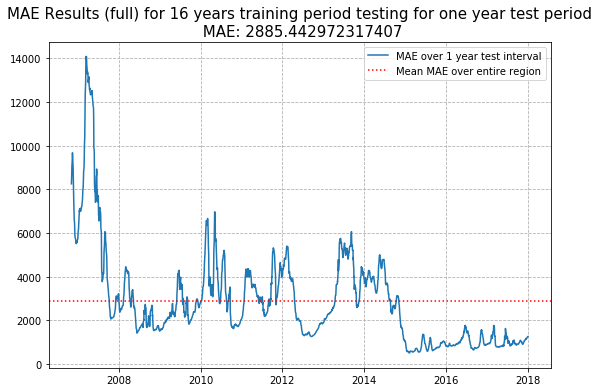

In [369]:
plt.plot(df_results['results'])
plt.title('MAE Results (full) for 16 years training period testing for one year test period\n ' + 'MAE: '+ str(df_results['results'].mean()), fontsize=15)
plt.axhline(df_results['results'].mean(), color='r', linestyle='dotted')
plt.legend(['MAE over 1 year test interval', 'Mean MAE over entire region'])
plt.grid(linestyle='dashed')
plt.show()

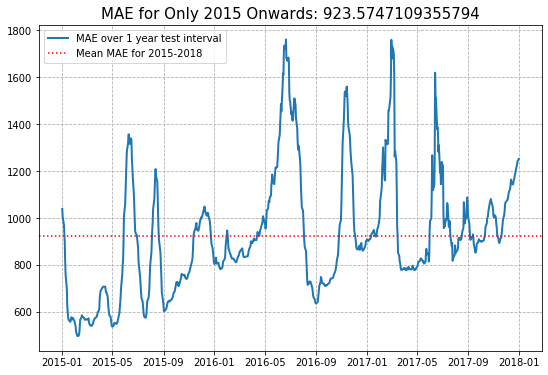

In [360]:
plt.plot(df_results2['results'], linewidth=2)
plt.grid(linestyle='dashed')
plt.title('MAE for Only 2015 Onwards: ' + str(df_results2['results'].mean()), fontsize=15)
plt.axhline(df_results2['results'].mean(), color='red', linestyle='dotted')
plt.legend(['MAE over 1 year test interval', 'Mean MAE for 2015-2018'])

plt.show()

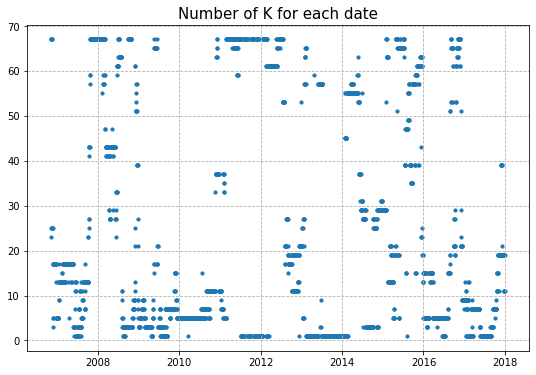

In [337]:
df_results['K']=pd.to_numeric(df_results['K'])
plt.scatter( df_results.index, df_results['K'], s=10)
plt.title('Number of K for each date', fontsize=15)
plt.grid(linestyle='dashed')

plt.show()

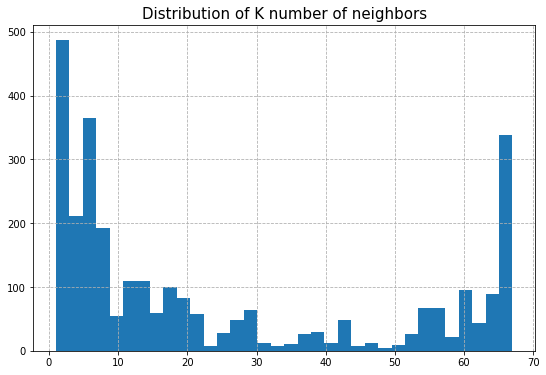

In [338]:
plt.hist(df_results['K'], 34)
plt.title('Distribution of K number of neighbors', fontsize=15)
plt.grid(linestyle='dashed')

plt.show()

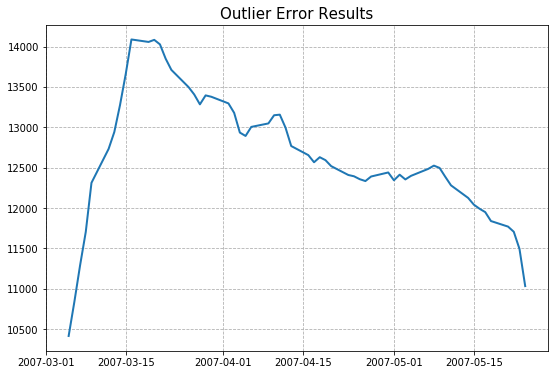

                 results   K
2007-03-05  10414.909282  13
2007-03-06  10837.496240  13
2007-03-07  11288.575978  13
2007-03-08  11704.707177  13
2007-03-09  12312.415977  13
2007-03-12  12731.989958  13
2007-03-13  12941.239149  13
2007-03-14  13275.363323  17
2007-03-15  13659.093496  17
2007-03-16  14087.981370  17
2007-03-19  14057.308300  17
2007-03-20  14083.053851  17
2007-03-21  14027.138778  17
2007-03-22  13849.602386  17
2007-03-23  13710.961925  17
2007-03-26  13498.889478  17
2007-03-27  13406.859199  17
2007-03-28  13284.105428  17
2007-03-29  13395.287210  17
2007-03-30  13378.172037  17
2007-04-02  13296.054743  17
2007-04-03  13178.877347  17
2007-04-04  12934.532453  17
2007-04-05  12892.689353  17
2007-04-06  13004.743396  17
2007-04-09  13047.848298  17
2007-04-10  13149.287618  13
2007-04-11  13156.518477  17
2007-04-12  12995.707745  17
2007-04-13  12767.920743  17
2007-04-16  12655.078177  17
2007-04-17  12567.028488   5
2007-04-18  12629.492600  17
2007-04-19  12

In [339]:
plt.plot(df_results[df_results['results']>10000]['results'], linewidth=2)
plt.title('Outlier Error Results', fontsize=15)
plt.grid(linestyle='dashed')

plt.show()

print(df_results[df_results['results']>10000])

### Notes

Testing periods beginning March 2007 through May 2007 had a really large error rate (over $10000 error off)

Let's take a look at this window in the original data

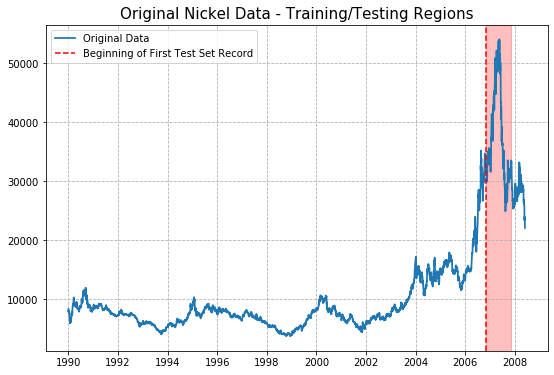

In [340]:
#plt.plot(LME.loc['2007-03-01':'2008-05-29'], linewidth=1.75)
plt.plot(LME.loc[:'2008-05-29'], linewidth=1.75)

test_start_date = datetime.datetime(2006,11,6)
test_end_date= datetime.datetime(2007, 11, 6)
plt.axvline(test_start_date, linestyle='dashed', color='red')
#plt.axvline(test_end_date, linestyle='dashed', color='green')
plt.axvspan(test_start_date, test_end_date, alpha=0.25, color='red')

plt.legend(['Original Data', 'Beginning of First Test Set Record'])
plt.grid(linestyle='dashed')

plt.title('Original Nickel Data - Training/Testing Regions', fontsize=15)
plt.show()


### We can see the source of the large MAE errors (ie MAE over 10000) is due to the sharp rise in Nickel costs between 2006 and 2007. 

It would be difficult to capture the model's performance on handling these outliers because there is not enough data to training the data leading up to it... 

Also KNN is not great for dealing with outliers. 

### So what happens if we exclude this data and only consider 

In [357]:
df_results2 = df_results[df_results.index.year>2007]
print('MAE for 2008-2018 testing:', df_results2['results'].mean())

df_results2 = df_results[df_results.index.year>2014]
print('MAE for 2015-2018 testing:', df_results2['results'].mean())


MAE for 2008-2018 testing: 2415.1265928486514
MAE for 2015-2018 testing: 923.5747109355794


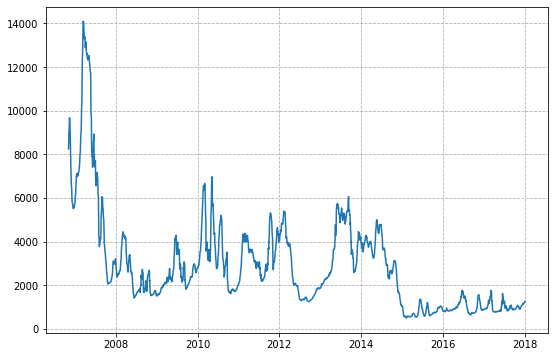

In [358]:
plt.plot(df_results['results'])
plt.grid(linestyle='dashed')

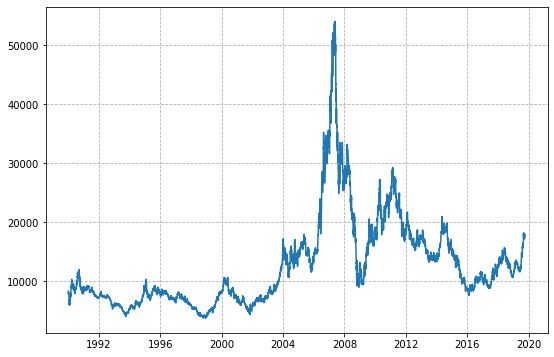

In [305]:
plt.plot(LME)
plt.grid(linestyle='dashed')

### NEXT: What happens if you redo the experiment but for a smaller number of years in training to testing ratio? (ex: train 5 years test 1st year. 

In [371]:
261*5

1305

In [391]:
results = []
datelist = []
paramlist = []

for item in dates[dates<datetime.datetime(2012,10,1)]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=1304)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']
    
    cv_results={}

    
    for K in range(0, 68, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
    #or key, value in cv_results.items():
        #rint(key, value)
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)
    

1995-11-06 00:00:00 , Optimal K: 67 , MAE: 489.5401695850075
1995-11-07 00:00:00 , Optimal K: 67 , MAE: 495.0127466894471
1995-11-08 00:00:00 , Optimal K: 67 , MAE: 500.27055008614866
1995-11-09 00:00:00 , Optimal K: 67 , MAE: 506.4173662418196
1995-11-10 00:00:00 , Optimal K: 67 , MAE: 513.147857370017
1995-11-13 00:00:00 , Optimal K: 67 , MAE: 519.5332226822896
1995-11-14 00:00:00 , Optimal K: 67 , MAE: 527.8422276144132
1995-11-15 00:00:00 , Optimal K: 67 , MAE: 533.925247839339
1995-11-16 00:00:00 , Optimal K: 65 , MAE: 539.8689699856558
1995-11-17 00:00:00 , Optimal K: 65 , MAE: 545.861586081297
1995-11-20 00:00:00 , Optimal K: 67 , MAE: 540.5677502839211
1995-11-21 00:00:00 , Optimal K: 59 , MAE: 537.2198860718298
1995-11-22 00:00:00 , Optimal K: 59 , MAE: 536.2457459374051
1995-11-23 00:00:00 , Optimal K: 59 , MAE: 537.5195652888799
1995-11-24 00:00:00 , Optimal K: 59 , MAE: 538.2293599665328
1995-11-27 00:00:00 , Optimal K: 59 , MAE: 541.1908479808686
1995-11-28 00:00:00 , Opti

1996-05-10 00:00:00 , Optimal K: 21 , MAE: 1355.5077271274474
1996-05-13 00:00:00 , Optimal K: 23 , MAE: 1414.7224540623963
1996-05-14 00:00:00 , Optimal K: 21 , MAE: 1459.2051078686477
1996-05-15 00:00:00 , Optimal K: 21 , MAE: 1490.4092681322809
1996-05-16 00:00:00 , Optimal K: 21 , MAE: 1537.4588852385386
1996-05-17 00:00:00 , Optimal K: 21 , MAE: 1573.7948364044335
1996-05-20 00:00:00 , Optimal K: 5 , MAE: 1605.5488317935672
1996-05-21 00:00:00 , Optimal K: 5 , MAE: 1594.6734766576396
1996-05-22 00:00:00 , Optimal K: 5 , MAE: 1602.606010955795
1996-05-23 00:00:00 , Optimal K: 1 , MAE: 1616.4765076484418
1996-05-24 00:00:00 , Optimal K: 3 , MAE: 1601.171221357811
1996-05-27 00:00:00 , Optimal K: 3 , MAE: 1619.088099863522
1996-05-28 00:00:00 , Optimal K: 5 , MAE: 1619.5650876585544
1996-05-29 00:00:00 , Optimal K: 5 , MAE: 1620.134960855671
1996-05-30 00:00:00 , Optimal K: 5 , MAE: 1631.1875642553973
1996-05-31 00:00:00 , Optimal K: 5 , MAE: 1619.2931736394094
1996-06-03 00:00:00 , 

1996-11-15 00:00:00 , Optimal K: 9 , MAE: 936.1754293662926
1996-11-18 00:00:00 , Optimal K: 9 , MAE: 942.4874751317245
1996-11-19 00:00:00 , Optimal K: 9 , MAE: 897.1160554318427
1996-11-20 00:00:00 , Optimal K: 9 , MAE: 891.7166170968605
1996-11-21 00:00:00 , Optimal K: 9 , MAE: 883.2860309984868
1996-11-22 00:00:00 , Optimal K: 9 , MAE: 889.8995409714498
1996-11-25 00:00:00 , Optimal K: 9 , MAE: 890.8063362912907
1996-11-26 00:00:00 , Optimal K: 9 , MAE: 899.1572361151499
1996-11-27 00:00:00 , Optimal K: 9 , MAE: 910.9988523019007
1996-11-28 00:00:00 , Optimal K: 9 , MAE: 930.9080511332679
1996-11-29 00:00:00 , Optimal K: 9 , MAE: 923.6405059384473
1996-12-02 00:00:00 , Optimal K: 9 , MAE: 913.6373969275957
1996-12-03 00:00:00 , Optimal K: 9 , MAE: 894.0584908710022
1996-12-04 00:00:00 , Optimal K: 9 , MAE: 881.0708585128004
1996-12-05 00:00:00 , Optimal K: 9 , MAE: 895.2376601301618
1996-12-06 00:00:00 , Optimal K: 9 , MAE: 887.7103191051045
1996-12-09 00:00:00 , Optimal K: 9 , MAE

1997-05-26 00:00:00 , Optimal K: 13 , MAE: 443.0513143513616
1997-05-27 00:00:00 , Optimal K: 13 , MAE: 440.32244216186365
1997-05-28 00:00:00 , Optimal K: 13 , MAE: 437.7267243087396
1997-05-29 00:00:00 , Optimal K: 13 , MAE: 438.09709021594284
1997-05-30 00:00:00 , Optimal K: 13 , MAE: 435.8038451273668
1997-06-02 00:00:00 , Optimal K: 23 , MAE: 423.7711743695558
1997-06-03 00:00:00 , Optimal K: 25 , MAE: 410.48296243391206
1997-06-04 00:00:00 , Optimal K: 27 , MAE: 401.7726011787736
1997-06-05 00:00:00 , Optimal K: 27 , MAE: 397.3092967600658
1997-06-06 00:00:00 , Optimal K: 29 , MAE: 397.15054066225326
1997-06-09 00:00:00 , Optimal K: 29 , MAE: 398.2567160907424
1997-06-10 00:00:00 , Optimal K: 27 , MAE: 402.7484887123516
1997-06-11 00:00:00 , Optimal K: 27 , MAE: 401.60924362490374
1997-06-12 00:00:00 , Optimal K: 25 , MAE: 401.8944166261398
1997-06-13 00:00:00 , Optimal K: 25 , MAE: 401.87315257512944
1997-06-16 00:00:00 , Optimal K: 27 , MAE: 400.11314919096895
1997-06-17 00:00:

1997-11-28 00:00:00 , Optimal K: 55 , MAE: 859.2757623451399
1997-12-01 00:00:00 , Optimal K: 57 , MAE: 869.8944426197713
1997-12-02 00:00:00 , Optimal K: 57 , MAE: 879.8639184468246
1997-12-03 00:00:00 , Optimal K: 55 , MAE: 898.1219991042136
1997-12-04 00:00:00 , Optimal K: 53 , MAE: 929.3821693328182
1997-12-05 00:00:00 , Optimal K: 57 , MAE: 966.2151155788398
1997-12-08 00:00:00 , Optimal K: 57 , MAE: 1018.4062199292746
1997-12-09 00:00:00 , Optimal K: 53 , MAE: 1084.0087743357913
1997-12-10 00:00:00 , Optimal K: 53 , MAE: 1136.4498987523689
1997-12-11 00:00:00 , Optimal K: 55 , MAE: 1202.4737809571532
1997-12-12 00:00:00 , Optimal K: 55 , MAE: 1265.9288835939249
1997-12-15 00:00:00 , Optimal K: 55 , MAE: 1314.7020347303592
1997-12-16 00:00:00 , Optimal K: 55 , MAE: 1350.5728878675998
1997-12-17 00:00:00 , Optimal K: 55 , MAE: 1377.616222405559
1997-12-18 00:00:00 , Optimal K: 55 , MAE: 1402.7351480787274
1997-12-19 00:00:00 , Optimal K: 55 , MAE: 1429.4532051773278
1997-12-22 00:0

1998-06-04 00:00:00 , Optimal K: 17 , MAE: 2206.7364296118903
1998-06-05 00:00:00 , Optimal K: 17 , MAE: 2256.168239443854
1998-06-08 00:00:00 , Optimal K: 17 , MAE: 2297.9746672414867
1998-06-09 00:00:00 , Optimal K: 17 , MAE: 2323.886031585606
1998-06-10 00:00:00 , Optimal K: 19 , MAE: 2356.281744751253
1998-06-11 00:00:00 , Optimal K: 19 , MAE: 2382.4409313135975
1998-06-12 00:00:00 , Optimal K: 17 , MAE: 2387.43328526209
1998-06-15 00:00:00 , Optimal K: 17 , MAE: 2370.8332077692876
1998-06-16 00:00:00 , Optimal K: 17 , MAE: 2400.690979738511
1998-06-17 00:00:00 , Optimal K: 17 , MAE: 2420.7952944941258
1998-06-18 00:00:00 , Optimal K: 17 , MAE: 2430.72253446619
1998-06-19 00:00:00 , Optimal K: 17 , MAE: 2422.201472015
1998-06-22 00:00:00 , Optimal K: 19 , MAE: 2394.5407889154185
1998-06-23 00:00:00 , Optimal K: 19 , MAE: 2364.2240207544937
1998-06-24 00:00:00 , Optimal K: 19 , MAE: 2333.898166452564
1998-06-25 00:00:00 , Optimal K: 19 , MAE: 2293.0340196791553
1998-06-26 00:00:00 ,

1998-12-09 00:00:00 , Optimal K: 67 , MAE: 1008.1431030369002
1998-12-10 00:00:00 , Optimal K: 67 , MAE: 1025.1889027739378
1998-12-11 00:00:00 , Optimal K: 67 , MAE: 1046.7256518945028
1998-12-14 00:00:00 , Optimal K: 65 , MAE: 1065.1044002387966
1998-12-15 00:00:00 , Optimal K: 65 , MAE: 1071.5166235364793
1998-12-16 00:00:00 , Optimal K: 65 , MAE: 1064.6699344054857
1998-12-17 00:00:00 , Optimal K: 65 , MAE: 1058.231736020762
1998-12-18 00:00:00 , Optimal K: 63 , MAE: 1058.9781690791256
1998-12-21 00:00:00 , Optimal K: 67 , MAE: 1043.4009172045842
1998-12-22 00:00:00 , Optimal K: 67 , MAE: 1053.289280349297
1998-12-23 00:00:00 , Optimal K: 67 , MAE: 1035.6777322209118
1998-12-24 00:00:00 , Optimal K: 67 , MAE: 1021.0466856822565
1998-12-25 00:00:00 , Optimal K: 67 , MAE: 992.0306302048386
1998-12-28 00:00:00 , Optimal K: 67 , MAE: 964.8230631928784
1998-12-29 00:00:00 , Optimal K: 67 , MAE: 932.4671293443286
1998-12-30 00:00:00 , Optimal K: 67 , MAE: 909.2585120088025
1998-12-31 00:

1999-06-16 00:00:00 , Optimal K: 23 , MAE: 557.4247136785232
1999-06-17 00:00:00 , Optimal K: 23 , MAE: 444.23171513338235
1999-06-18 00:00:00 , Optimal K: 31 , MAE: 395.9238225309524
1999-06-21 00:00:00 , Optimal K: 47 , MAE: 386.59361053178156
1999-06-22 00:00:00 , Optimal K: 57 , MAE: 377.31744013328137
1999-06-23 00:00:00 , Optimal K: 67 , MAE: 373.4027945991598
1999-06-24 00:00:00 , Optimal K: 67 , MAE: 392.96575347503295
1999-06-25 00:00:00 , Optimal K: 67 , MAE: 448.86690612912906
1999-06-28 00:00:00 , Optimal K: 67 , MAE: 509.83401916676866
1999-06-29 00:00:00 , Optimal K: 67 , MAE: 561.458798858172
1999-06-30 00:00:00 , Optimal K: 67 , MAE: 591.33298238717
1999-07-01 00:00:00 , Optimal K: 1 , MAE: 572.8604454169465
1999-07-02 00:00:00 , Optimal K: 1 , MAE: 553.4348378091066
1999-07-05 00:00:00 , Optimal K: 1 , MAE: 544.4121410930818
1999-07-06 00:00:00 , Optimal K: 1 , MAE: 546.5132566642833
1999-07-07 00:00:00 , Optimal K: 1 , MAE: 472.0935985347935
1999-07-08 00:00:00 , Opti

1999-12-21 00:00:00 , Optimal K: 31 , MAE: 491.3748867059427
1999-12-22 00:00:00 , Optimal K: 31 , MAE: 492.10744583000644
1999-12-23 00:00:00 , Optimal K: 31 , MAE: 495.53100119722586
1999-12-24 00:00:00 , Optimal K: 31 , MAE: 496.55388903048345
1999-12-27 00:00:00 , Optimal K: 31 , MAE: 497.03810390370415
1999-12-28 00:00:00 , Optimal K: 31 , MAE: 496.36715603482804
1999-12-29 00:00:00 , Optimal K: 31 , MAE: 496.41942324647215
1999-12-30 00:00:00 , Optimal K: 27 , MAE: 497.2332780530555
1999-12-31 00:00:00 , Optimal K: 27 , MAE: 495.6374714401537
2000-01-03 00:00:00 , Optimal K: 33 , MAE: 492.81826590241684
2000-01-04 00:00:00 , Optimal K: 33 , MAE: 487.8447883534658
2000-01-05 00:00:00 , Optimal K: 65 , MAE: 486.6510610376827
2000-01-06 00:00:00 , Optimal K: 41 , MAE: 493.17950306418214
2000-01-07 00:00:00 , Optimal K: 63 , MAE: 501.8918048092434
2000-01-10 00:00:00 , Optimal K: 63 , MAE: 508.6801442356004
2000-01-11 00:00:00 , Optimal K: 63 , MAE: 512.4583262069727
2000-01-12 00:00

2000-06-27 00:00:00 , Optimal K: 3 , MAE: 586.041401408245
2000-06-28 00:00:00 , Optimal K: 3 , MAE: 560.3010258603451
2000-06-29 00:00:00 , Optimal K: 7 , MAE: 554.4074305229992
2000-06-30 00:00:00 , Optimal K: 7 , MAE: 533.7727966494353
2000-07-03 00:00:00 , Optimal K: 9 , MAE: 526.9589794413351
2000-07-04 00:00:00 , Optimal K: 13 , MAE: 523.1367215215032
2000-07-05 00:00:00 , Optimal K: 13 , MAE: 516.254681211316
2000-07-06 00:00:00 , Optimal K: 13 , MAE: 514.0325862168918
2000-07-07 00:00:00 , Optimal K: 21 , MAE: 515.8456618582962
2000-07-10 00:00:00 , Optimal K: 21 , MAE: 518.2978546629192
2000-07-11 00:00:00 , Optimal K: 21 , MAE: 523.402878624666
2000-07-12 00:00:00 , Optimal K: 21 , MAE: 529.8568740818894
2000-07-13 00:00:00 , Optimal K: 21 , MAE: 536.7816430645353
2000-07-14 00:00:00 , Optimal K: 21 , MAE: 542.8300228371331
2000-07-17 00:00:00 , Optimal K: 67 , MAE: 542.8870517685687
2000-07-18 00:00:00 , Optimal K: 67 , MAE: 544.8031000901996
2000-07-19 00:00:00 , Optimal K:

2001-01-02 00:00:00 , Optimal K: 67 , MAE: 483.1216390056863
2001-01-03 00:00:00 , Optimal K: 67 , MAE: 467.17077040648616
2001-01-04 00:00:00 , Optimal K: 67 , MAE: 455.9504311372292
2001-01-05 00:00:00 , Optimal K: 67 , MAE: 432.1342428483474
2001-01-08 00:00:00 , Optimal K: 67 , MAE: 391.0866189129551
2001-01-09 00:00:00 , Optimal K: 67 , MAE: 364.3050578713378
2001-01-10 00:00:00 , Optimal K: 67 , MAE: 339.79502363400576
2001-01-11 00:00:00 , Optimal K: 67 , MAE: 333.0073894484098
2001-01-12 00:00:00 , Optimal K: 67 , MAE: 323.9594366631307
2001-01-15 00:00:00 , Optimal K: 67 , MAE: 317.6520865497713
2001-01-16 00:00:00 , Optimal K: 67 , MAE: 317.77998772308115
2001-01-17 00:00:00 , Optimal K: 67 , MAE: 320.1701459951858
2001-01-18 00:00:00 , Optimal K: 67 , MAE: 321.1228062594567
2001-01-19 00:00:00 , Optimal K: 67 , MAE: 322.3136152156781
2001-01-22 00:00:00 , Optimal K: 67 , MAE: 323.6910865296677
2001-01-23 00:00:00 , Optimal K: 67 , MAE: 326.6479100926229
2001-01-24 00:00:00 ,

2001-07-10 00:00:00 , Optimal K: 1 , MAE: 505.5125188394652
2001-07-11 00:00:00 , Optimal K: 1 , MAE: 516.5677577912352
2001-07-12 00:00:00 , Optimal K: 1 , MAE: 524.0437370013894
2001-07-13 00:00:00 , Optimal K: 1 , MAE: 544.3018811178869
2001-07-16 00:00:00 , Optimal K: 1 , MAE: 561.3448598709216
2001-07-17 00:00:00 , Optimal K: 1 , MAE: 570.7303137354736
2001-07-18 00:00:00 , Optimal K: 1 , MAE: 589.3566948383015
2001-07-19 00:00:00 , Optimal K: 1 , MAE: 600.0127527334807
2001-07-20 00:00:00 , Optimal K: 1 , MAE: 583.9470542513418
2001-07-23 00:00:00 , Optimal K: 1 , MAE: 570.4636873283163
2001-07-24 00:00:00 , Optimal K: 1 , MAE: 472.2089598393292
2001-07-25 00:00:00 , Optimal K: 1 , MAE: 472.89400311110495
2001-07-26 00:00:00 , Optimal K: 3 , MAE: 464.9021523943717
2001-07-27 00:00:00 , Optimal K: 5 , MAE: 445.02781580240287
2001-07-30 00:00:00 , Optimal K: 5 , MAE: 438.815709253962
2001-07-31 00:00:00 , Optimal K: 5 , MAE: 443.1131515232791
2001-08-01 00:00:00 , Optimal K: 9 , MA

2002-01-16 00:00:00 , Optimal K: 1 , MAE: 1793.8805344252348
2002-01-17 00:00:00 , Optimal K: 1 , MAE: 1821.9519742641999
2002-01-18 00:00:00 , Optimal K: 1 , MAE: 1717.812059865438
2002-01-21 00:00:00 , Optimal K: 1 , MAE: 1694.0668539539804
2002-01-22 00:00:00 , Optimal K: 1 , MAE: 1696.45171856267
2002-01-23 00:00:00 , Optimal K: 1 , MAE: 1715.4439417466438
2002-01-24 00:00:00 , Optimal K: 1 , MAE: 1720.6022917941007
2002-01-25 00:00:00 , Optimal K: 1 , MAE: 1743.2037714144865
2002-01-28 00:00:00 , Optimal K: 1 , MAE: 1779.1941125184107
2002-01-29 00:00:00 , Optimal K: 1 , MAE: 1815.138720946758
2002-01-30 00:00:00 , Optimal K: 1 , MAE: 1852.2370620942413
2002-01-31 00:00:00 , Optimal K: 1 , MAE: 1863.4237826530664
2002-02-01 00:00:00 , Optimal K: 1 , MAE: 1895.1158734938679
2002-02-04 00:00:00 , Optimal K: 1 , MAE: 1893.353878637411
2002-02-05 00:00:00 , Optimal K: 5 , MAE: 1937.3141091006069
2002-02-06 00:00:00 , Optimal K: 5 , MAE: 1956.1625244634604
2002-02-07 00:00:00 , Optimal

2002-07-25 00:00:00 , Optimal K: 1 , MAE: 3172.92428905404
2002-07-26 00:00:00 , Optimal K: 1 , MAE: 3105.1372299379473
2002-07-29 00:00:00 , Optimal K: 1 , MAE: 3037.6234199237592
2002-07-30 00:00:00 , Optimal K: 1 , MAE: 2974.5600136424714
2002-07-31 00:00:00 , Optimal K: 1 , MAE: 2822.766992625977
2002-08-01 00:00:00 , Optimal K: 1 , MAE: 2827.259328988011
2002-08-02 00:00:00 , Optimal K: 1 , MAE: 2863.957978817096
2002-08-05 00:00:00 , Optimal K: 1 , MAE: 2878.0553813865868
2002-08-06 00:00:00 , Optimal K: 1 , MAE: 2906.4206211141523
2002-08-07 00:00:00 , Optimal K: 1 , MAE: 2930.3705530253987
2002-08-08 00:00:00 , Optimal K: 1 , MAE: 2895.629471875411
2002-08-09 00:00:00 , Optimal K: 1 , MAE: 3001.749994818692
2002-08-12 00:00:00 , Optimal K: 1 , MAE: 3096.818819542682
2002-08-13 00:00:00 , Optimal K: 1 , MAE: 3062.9906932851577
2002-08-14 00:00:00 , Optimal K: 1 , MAE: 3066.7991870777983
2002-08-15 00:00:00 , Optimal K: 1 , MAE: 3061.5251394647653
2002-08-16 00:00:00 , Optimal K:

2003-01-30 00:00:00 , Optimal K: 67 , MAE: 1919.1993288814592
2003-01-31 00:00:00 , Optimal K: 67 , MAE: 1980.7345594393275
2003-02-03 00:00:00 , Optimal K: 67 , MAE: 1994.9527646529189
2003-02-04 00:00:00 , Optimal K: 67 , MAE: 2008.2599988250233
2003-02-05 00:00:00 , Optimal K: 67 , MAE: 2025.4769141319161
2003-02-06 00:00:00 , Optimal K: 67 , MAE: 2032.6451630987278
2003-02-07 00:00:00 , Optimal K: 67 , MAE: 2059.4289143761457
2003-02-10 00:00:00 , Optimal K: 67 , MAE: 2096.6989531139934
2003-02-11 00:00:00 , Optimal K: 67 , MAE: 2144.2091085518414
2003-02-12 00:00:00 , Optimal K: 67 , MAE: 2165.416220576304
2003-02-13 00:00:00 , Optimal K: 67 , MAE: 2222.4721468878315
2003-02-14 00:00:00 , Optimal K: 67 , MAE: 2270.486295892175
2003-02-17 00:00:00 , Optimal K: 67 , MAE: 2325.9106344741435
2003-02-18 00:00:00 , Optimal K: 67 , MAE: 2355.6935067641753
2003-02-19 00:00:00 , Optimal K: 67 , MAE: 2398.1909449376853
2003-02-20 00:00:00 , Optimal K: 67 , MAE: 2439.4476257512847
2003-02-21

2003-08-06 00:00:00 , Optimal K: 67 , MAE: 1316.5505018193958
2003-08-07 00:00:00 , Optimal K: 67 , MAE: 1359.9639322947655
2003-08-08 00:00:00 , Optimal K: 67 , MAE: 1431.3616208375195
2003-08-11 00:00:00 , Optimal K: 67 , MAE: 1485.112595811713
2003-08-12 00:00:00 , Optimal K: 67 , MAE: 1527.4173878390582
2003-08-13 00:00:00 , Optimal K: 67 , MAE: 1597.7417700789042
2003-08-14 00:00:00 , Optimal K: 67 , MAE: 1658.2189505837632
2003-08-15 00:00:00 , Optimal K: 67 , MAE: 1698.4738420987262
2003-08-18 00:00:00 , Optimal K: 67 , MAE: 1735.658485472978
2003-08-19 00:00:00 , Optimal K: 67 , MAE: 1750.550048349246
2003-08-20 00:00:00 , Optimal K: 67 , MAE: 1744.6727170995691
2003-08-21 00:00:00 , Optimal K: 67 , MAE: 1701.2610488235528
2003-08-22 00:00:00 , Optimal K: 67 , MAE: 1690.5807991544848
2003-08-25 00:00:00 , Optimal K: 67 , MAE: 1706.185231811693
2003-08-26 00:00:00 , Optimal K: 67 , MAE: 1711.4595146546712
2003-08-27 00:00:00 , Optimal K: 67 , MAE: 1722.370809169972
2003-08-28 00

2004-02-10 00:00:00 , Optimal K: 1 , MAE: 1427.160547637243
2004-02-11 00:00:00 , Optimal K: 1 , MAE: 1369.2418987782971
2004-02-12 00:00:00 , Optimal K: 1 , MAE: 1370.0499355898294
2004-02-13 00:00:00 , Optimal K: 1 , MAE: 1369.8527445951681
2004-02-16 00:00:00 , Optimal K: 1 , MAE: 1343.969344584315
2004-02-17 00:00:00 , Optimal K: 1 , MAE: 1252.0920201405706
2004-02-18 00:00:00 , Optimal K: 1 , MAE: 1243.8467090685515
2004-02-19 00:00:00 , Optimal K: 41 , MAE: 1280.1742285311739
2004-02-20 00:00:00 , Optimal K: 1 , MAE: 1184.300285604455
2004-02-23 00:00:00 , Optimal K: 1 , MAE: 1192.642380441131
2004-02-24 00:00:00 , Optimal K: 1 , MAE: 1191.289874787607
2004-02-25 00:00:00 , Optimal K: 31 , MAE: 1178.6563570685355
2004-02-26 00:00:00 , Optimal K: 31 , MAE: 1171.1190883172726
2004-02-27 00:00:00 , Optimal K: 23 , MAE: 1169.8126834182024
2004-03-01 00:00:00 , Optimal K: 23 , MAE: 1153.9572809146016
2004-03-02 00:00:00 , Optimal K: 23 , MAE: 1153.8102328603509
2004-03-03 00:00:00 , O

2004-08-17 00:00:00 , Optimal K: 63 , MAE: 3366.682768957357
2004-08-18 00:00:00 , Optimal K: 63 , MAE: 3436.5375025333124
2004-08-19 00:00:00 , Optimal K: 65 , MAE: 3509.2262082554976
2004-08-20 00:00:00 , Optimal K: 67 , MAE: 3589.4103700843434
2004-08-23 00:00:00 , Optimal K: 63 , MAE: 3664.393770143805
2004-08-24 00:00:00 , Optimal K: 63 , MAE: 3732.605114374592
2004-08-25 00:00:00 , Optimal K: 63 , MAE: 3799.561921191104
2004-08-26 00:00:00 , Optimal K: 63 , MAE: 3867.235143221249
2004-08-27 00:00:00 , Optimal K: 63 , MAE: 3928.4009803021772
2004-08-30 00:00:00 , Optimal K: 63 , MAE: 3981.519775717932
2004-08-31 00:00:00 , Optimal K: 63 , MAE: 4037.0826607166828
2004-09-01 00:00:00 , Optimal K: 63 , MAE: 4092.8786868203124
2004-09-02 00:00:00 , Optimal K: 63 , MAE: 4143.614975158061
2004-09-03 00:00:00 , Optimal K: 63 , MAE: 4196.18975523547
2004-09-06 00:00:00 , Optimal K: 63 , MAE: 4249.300650524251
2004-09-07 00:00:00 , Optimal K: 63 , MAE: 4298.998298135994
2004-09-08 00:00:00

2005-02-22 00:00:00 , Optimal K: 65 , MAE: 11339.511986277561
2005-02-23 00:00:00 , Optimal K: 65 , MAE: 11451.665283161696
2005-02-24 00:00:00 , Optimal K: 65 , MAE: 11573.671488151153
2005-02-25 00:00:00 , Optimal K: 65 , MAE: 11704.034164617318
2005-02-28 00:00:00 , Optimal K: 65 , MAE: 11824.215223677687
2005-03-01 00:00:00 , Optimal K: 65 , MAE: 11963.30574447665
2005-03-02 00:00:00 , Optimal K: 65 , MAE: 12116.577434998391
2005-03-03 00:00:00 , Optimal K: 1 , MAE: 11820.015576910964
2005-03-04 00:00:00 , Optimal K: 1 , MAE: 11942.500590179447
2005-03-07 00:00:00 , Optimal K: 1 , MAE: 12079.425040923657
2005-03-08 00:00:00 , Optimal K: 1 , MAE: 12209.865459187211
2005-03-09 00:00:00 , Optimal K: 1 , MAE: 12347.946152406395
2005-03-10 00:00:00 , Optimal K: 1 , MAE: 12570.798543606963
2005-03-11 00:00:00 , Optimal K: 1 , MAE: 12453.087328282607
2005-03-14 00:00:00 , Optimal K: 1 , MAE: 12643.093217934573
2005-03-15 00:00:00 , Optimal K: 1 , MAE: 12745.477507050813
2005-03-16 00:00:0

2005-08-31 00:00:00 , Optimal K: 65 , MAE: 6342.831003421524
2005-09-01 00:00:00 , Optimal K: 65 , MAE: 6341.553938570598
2005-09-02 00:00:00 , Optimal K: 65 , MAE: 6364.101272213427
2005-09-05 00:00:00 , Optimal K: 65 , MAE: 6425.870161267648
2005-09-06 00:00:00 , Optimal K: 63 , MAE: 6504.536529350497
2005-09-07 00:00:00 , Optimal K: 65 , MAE: 6578.810474895637
2005-09-08 00:00:00 , Optimal K: 65 , MAE: 6653.474198650859
2005-09-09 00:00:00 , Optimal K: 65 , MAE: 6761.6084166926075
2005-09-12 00:00:00 , Optimal K: 65 , MAE: 6878.219923527371
2005-09-13 00:00:00 , Optimal K: 65 , MAE: 6918.53594551421
2005-09-14 00:00:00 , Optimal K: 65 , MAE: 6980.744134434575
2005-09-15 00:00:00 , Optimal K: 65 , MAE: 7092.066978624742
2005-09-16 00:00:00 , Optimal K: 65 , MAE: 7321.227876695095
2005-09-19 00:00:00 , Optimal K: 65 , MAE: 7476.848927715929
2005-09-20 00:00:00 , Optimal K: 41 , MAE: 7591.906016325672
2005-09-21 00:00:00 , Optimal K: 41 , MAE: 7697.742801344235
2005-09-22 00:00:00 , Op

2006-03-08 00:00:00 , Optimal K: 63 , MAE: 13378.811518335555
2006-03-09 00:00:00 , Optimal K: 63 , MAE: 13583.305205515762
2006-03-10 00:00:00 , Optimal K: 63 , MAE: 13788.550796580505
2006-03-13 00:00:00 , Optimal K: 63 , MAE: 14038.93761716212
2006-03-14 00:00:00 , Optimal K: 63 , MAE: 14260.48091286816
2006-03-15 00:00:00 , Optimal K: 63 , MAE: 14534.257903605576
2006-03-16 00:00:00 , Optimal K: 63 , MAE: 14990.94715010238
2006-03-17 00:00:00 , Optimal K: 65 , MAE: 15470.90684184897
2006-03-20 00:00:00 , Optimal K: 65 , MAE: 15892.630260345502
2006-03-21 00:00:00 , Optimal K: 65 , MAE: 16108.83696220563
2006-03-22 00:00:00 , Optimal K: 65 , MAE: 16265.329482777293
2006-03-23 00:00:00 , Optimal K: 65 , MAE: 16475.370581270607
2006-03-24 00:00:00 , Optimal K: 63 , MAE: 16443.99058679741
2006-03-27 00:00:00 , Optimal K: 63 , MAE: 16396.890406848084
2006-03-28 00:00:00 , Optimal K: 63 , MAE: 16332.95380826507
2006-03-29 00:00:00 , Optimal K: 63 , MAE: 16315.026636006985
2006-03-30 00:0

2006-09-12 00:00:00 , Optimal K: 65 , MAE: 3738.3259064578992
2006-09-13 00:00:00 , Optimal K: 65 , MAE: 3742.996007008612
2006-09-14 00:00:00 , Optimal K: 63 , MAE: 3713.435657165722
2006-09-15 00:00:00 , Optimal K: 21 , MAE: 3648.843509974892
2006-09-18 00:00:00 , Optimal K: 21 , MAE: 3541.6735622720385
2006-09-19 00:00:00 , Optimal K: 21 , MAE: 3434.578353778471
2006-09-20 00:00:00 , Optimal K: 19 , MAE: 3267.232626038599
2006-09-21 00:00:00 , Optimal K: 11 , MAE: 3248.0280137793197
2006-09-22 00:00:00 , Optimal K: 11 , MAE: 3351.3175374445163
2006-09-25 00:00:00 , Optimal K: 1 , MAE: 3585.112746138737
2006-09-26 00:00:00 , Optimal K: 11 , MAE: 4068.775139867287
2006-09-27 00:00:00 , Optimal K: 19 , MAE: 4522.466283971521
2006-09-28 00:00:00 , Optimal K: 19 , MAE: 4908.539979785189
2006-09-29 00:00:00 , Optimal K: 1 , MAE: 4985.567468969002
2006-10-02 00:00:00 , Optimal K: 1 , MAE: 5128.207965857748
2006-10-03 00:00:00 , Optimal K: 1 , MAE: 5257.821266103517
2006-10-04 00:00:00 , Op

2007-03-20 00:00:00 , Optimal K: 17 , MAE: 14258.923969698419
2007-03-21 00:00:00 , Optimal K: 17 , MAE: 14180.533045243586
2007-03-22 00:00:00 , Optimal K: 17 , MAE: 14017.18185921465
2007-03-23 00:00:00 , Optimal K: 17 , MAE: 13880.461577520553
2007-03-26 00:00:00 , Optimal K: 13 , MAE: 13660.391580425658
2007-03-27 00:00:00 , Optimal K: 17 , MAE: 13578.514326213271
2007-03-28 00:00:00 , Optimal K: 13 , MAE: 13436.748054392167
2007-03-29 00:00:00 , Optimal K: 13 , MAE: 13556.389413159832
2007-03-30 00:00:00 , Optimal K: 13 , MAE: 13545.968366034784
2007-04-02 00:00:00 , Optimal K: 17 , MAE: 13476.540780396026
2007-04-03 00:00:00 , Optimal K: 13 , MAE: 13342.759291290682
2007-04-04 00:00:00 , Optimal K: 17 , MAE: 13112.169947170341
2007-04-05 00:00:00 , Optimal K: 17 , MAE: 13071.66268219934
2007-04-06 00:00:00 , Optimal K: 13 , MAE: 13184.59025642525
2007-04-09 00:00:00 , Optimal K: 17 , MAE: 13234.49481246255
2007-04-10 00:00:00 , Optimal K: 13 , MAE: 13300.363032088864
2007-04-11 0

2007-09-25 00:00:00 , Optimal K: 11 , MAE: 3904.2333851428843
2007-09-26 00:00:00 , Optimal K: 11 , MAE: 3824.145444850822
2007-09-27 00:00:00 , Optimal K: 11 , MAE: 3768.4283455977406
2007-09-28 00:00:00 , Optimal K: 11 , MAE: 3556.2777762935307
2007-10-01 00:00:00 , Optimal K: 7 , MAE: 3334.3942147024254
2007-10-02 00:00:00 , Optimal K: 11 , MAE: 3120.6827908453533
2007-10-03 00:00:00 , Optimal K: 9 , MAE: 3043.541323923924
2007-10-04 00:00:00 , Optimal K: 11 , MAE: 2885.521435964117
2007-10-05 00:00:00 , Optimal K: 11 , MAE: 2794.247663442445
2007-10-08 00:00:00 , Optimal K: 13 , MAE: 2660.954204566473
2007-10-09 00:00:00 , Optimal K: 13 , MAE: 2550.0418422275184
2007-10-10 00:00:00 , Optimal K: 13 , MAE: 2435.5877639537457
2007-10-11 00:00:00 , Optimal K: 13 , MAE: 2372.994995451219
2007-10-12 00:00:00 , Optimal K: 17 , MAE: 2208.244982702953
2007-10-15 00:00:00 , Optimal K: 17 , MAE: 2108.090801242328
2007-10-16 00:00:00 , Optimal K: 17 , MAE: 2025.9183613028945
2007-10-17 00:00:0

2008-03-28 00:00:00 , Optimal K: 55 , MAE: 2446.545784696198
2008-03-31 00:00:00 , Optimal K: 55 , MAE: 2432.886172346419
2008-04-01 00:00:00 , Optimal K: 55 , MAE: 2416.726686347778
2008-04-02 00:00:00 , Optimal K: 55 , MAE: 2396.9028118202114
2008-04-03 00:00:00 , Optimal K: 55 , MAE: 2364.511016533399
2008-04-04 00:00:00 , Optimal K: 61 , MAE: 2333.1470616744177
2008-04-07 00:00:00 , Optimal K: 61 , MAE: 2323.618921330303
2008-04-08 00:00:00 , Optimal K: 67 , MAE: 2329.017129953239
2008-04-09 00:00:00 , Optimal K: 67 , MAE: 2356.8717972454397
2008-04-10 00:00:00 , Optimal K: 11 , MAE: 2357.21989368965
2008-04-11 00:00:00 , Optimal K: 7 , MAE: 2295.9803009353736
2008-04-14 00:00:00 , Optimal K: 7 , MAE: 2315.6796061930504
2008-04-15 00:00:00 , Optimal K: 11 , MAE: 2343.320477305236
2008-04-16 00:00:00 , Optimal K: 11 , MAE: 2356.199630301823
2008-04-17 00:00:00 , Optimal K: 11 , MAE: 2344.780684233023
2008-04-18 00:00:00 , Optimal K: 11 , MAE: 2363.948312564336
2008-04-21 00:00:00 , 

2008-10-06 00:00:00 , Optimal K: 3 , MAE: 5228.869287846135
2008-10-07 00:00:00 , Optimal K: 5 , MAE: 5205.3026267135965
2008-10-08 00:00:00 , Optimal K: 5 , MAE: 5416.21168188854
2008-10-09 00:00:00 , Optimal K: 5 , MAE: 5895.091697346569
2008-10-10 00:00:00 , Optimal K: 5 , MAE: 6161.684010557943
2008-10-13 00:00:00 , Optimal K: 5 , MAE: 6316.137661604371
2008-10-14 00:00:00 , Optimal K: 7 , MAE: 6389.3882180758055
2008-10-15 00:00:00 , Optimal K: 7 , MAE: 6478.896861144624
2008-10-16 00:00:00 , Optimal K: 7 , MAE: 6576.069267077449
2008-10-17 00:00:00 , Optimal K: 5 , MAE: 6494.785509610722
2008-10-20 00:00:00 , Optimal K: 5 , MAE: 6533.094868395316
2008-10-21 00:00:00 , Optimal K: 5 , MAE: 6517.731613687184
2008-10-22 00:00:00 , Optimal K: 5 , MAE: 6619.067692565691
2008-10-23 00:00:00 , Optimal K: 5 , MAE: 6588.749870260797
2008-10-24 00:00:00 , Optimal K: 5 , MAE: 6540.074471457935
2008-10-27 00:00:00 , Optimal K: 5 , MAE: 6512.627092912211
2008-10-28 00:00:00 , Optimal K: 5 , MA

2009-04-14 00:00:00 , Optimal K: 3 , MAE: 2653.4404044129997
2009-04-15 00:00:00 , Optimal K: 3 , MAE: 2562.770220292288
2009-04-16 00:00:00 , Optimal K: 3 , MAE: 2475.45037139122
2009-04-17 00:00:00 , Optimal K: 3 , MAE: 2486.4652510196593
2009-04-20 00:00:00 , Optimal K: 3 , MAE: 2428.2993026256854
2009-04-21 00:00:00 , Optimal K: 3 , MAE: 2443.7080924771753
2009-04-22 00:00:00 , Optimal K: 3 , MAE: 2425.0494438143764
2009-04-23 00:00:00 , Optimal K: 3 , MAE: 2493.916867103413
2009-04-24 00:00:00 , Optimal K: 3 , MAE: 2586.4680357859647
2009-04-27 00:00:00 , Optimal K: 3 , MAE: 2632.7139302201513
2009-04-28 00:00:00 , Optimal K: 3 , MAE: 2560.5544936029783
2009-04-29 00:00:00 , Optimal K: 3 , MAE: 2531.473603004902
2009-04-30 00:00:00 , Optimal K: 3 , MAE: 2478.9967597870263
2009-05-01 00:00:00 , Optimal K: 3 , MAE: 2449.9024121025273
2009-05-04 00:00:00 , Optimal K: 3 , MAE: 2392.5258007453285
2009-05-05 00:00:00 , Optimal K: 3 , MAE: 2333.231478153621
2009-05-06 00:00:00 , Optimal 

2009-10-20 00:00:00 , Optimal K: 1 , MAE: 4667.176668130252
2009-10-21 00:00:00 , Optimal K: 1 , MAE: 4413.303485222314
2009-10-22 00:00:00 , Optimal K: 1 , MAE: 4400.6198523288485
2009-10-23 00:00:00 , Optimal K: 1 , MAE: 4113.312830009453
2009-10-26 00:00:00 , Optimal K: 1 , MAE: 4044.287946124548
2009-10-27 00:00:00 , Optimal K: 1 , MAE: 4079.0332476705703
2009-10-28 00:00:00 , Optimal K: 1 , MAE: 3369.1951707515186
2009-10-29 00:00:00 , Optimal K: 1 , MAE: 3435.8118836398507
2009-10-30 00:00:00 , Optimal K: 1 , MAE: 3476.7784078315126
2009-11-02 00:00:00 , Optimal K: 1 , MAE: 3568.0741157270813
2009-11-03 00:00:00 , Optimal K: 1 , MAE: 3723.246377585499
2009-11-04 00:00:00 , Optimal K: 1 , MAE: 3721.0759564669224
2009-11-05 00:00:00 , Optimal K: 1 , MAE: 3935.6564364446285
2009-11-06 00:00:00 , Optimal K: 1 , MAE: 3982.0329783505367
2009-11-09 00:00:00 , Optimal K: 1 , MAE: 3919.6193883351193
2009-11-10 00:00:00 , Optimal K: 1 , MAE: 3978.008515550066
2009-11-11 00:00:00 , Optimal 

2010-04-29 00:00:00 , Optimal K: 1 , MAE: 6606.476181685783
2010-04-30 00:00:00 , Optimal K: 1 , MAE: 6683.5529056794
2010-05-03 00:00:00 , Optimal K: 1 , MAE: 6703.606255726736
2010-05-04 00:00:00 , Optimal K: 1 , MAE: 6761.80440361107
2010-05-05 00:00:00 , Optimal K: 1 , MAE: 7276.146951673014
2010-05-06 00:00:00 , Optimal K: 1 , MAE: 9045.493909367273
2010-05-07 00:00:00 , Optimal K: 1 , MAE: 8228.656220589015
2010-05-10 00:00:00 , Optimal K: 1 , MAE: 7871.644740690531
2010-05-11 00:00:00 , Optimal K: 1 , MAE: 8426.049872968144
2010-05-12 00:00:00 , Optimal K: 1 , MAE: 7703.920776593932
2010-05-13 00:00:00 , Optimal K: 1 , MAE: 7773.113580345463
2010-05-14 00:00:00 , Optimal K: 1 , MAE: 7795.763798011776
2010-05-17 00:00:00 , Optimal K: 1 , MAE: 7835.705803649864
2010-05-18 00:00:00 , Optimal K: 1 , MAE: 7845.83964260812
2010-05-19 00:00:00 , Optimal K: 1 , MAE: 7891.520726055907
2010-05-20 00:00:00 , Optimal K: 1 , MAE: 7279.4690044806985
2010-05-21 00:00:00 , Optimal K: 1 , MAE: 7

2010-11-08 00:00:00 , Optimal K: 17 , MAE: 2251.294504254658
2010-11-09 00:00:00 , Optimal K: 17 , MAE: 2292.105514319947
2010-11-10 00:00:00 , Optimal K: 17 , MAE: 2377.944674956952
2010-11-11 00:00:00 , Optimal K: 17 , MAE: 2501.078214652316
2010-11-12 00:00:00 , Optimal K: 15 , MAE: 2578.196385674667
2010-11-15 00:00:00 , Optimal K: 17 , MAE: 2617.3761992963955
2010-11-16 00:00:00 , Optimal K: 17 , MAE: 2693.745976301875
2010-11-17 00:00:00 , Optimal K: 17 , MAE: 2775.654552896228
2010-11-18 00:00:00 , Optimal K: 17 , MAE: 2907.650833720896
2010-11-19 00:00:00 , Optimal K: 17 , MAE: 3038.946849713486
2010-11-22 00:00:00 , Optimal K: 15 , MAE: 3166.532646572157
2010-11-23 00:00:00 , Optimal K: 15 , MAE: 3219.1942623440577
2010-11-24 00:00:00 , Optimal K: 15 , MAE: 3278.427801678226
2010-11-25 00:00:00 , Optimal K: 15 , MAE: 3310.7572349043394
2010-11-26 00:00:00 , Optimal K: 15 , MAE: 3321.3277899933605
2010-11-29 00:00:00 , Optimal K: 15 , MAE: 3327.1960240432145
2010-11-30 00:00:00

2011-05-16 00:00:00 , Optimal K: 67 , MAE: 2131.8971965818378
2011-05-17 00:00:00 , Optimal K: 67 , MAE: 1907.2400477633987
2011-05-18 00:00:00 , Optimal K: 67 , MAE: 1784.2890920688926
2011-05-19 00:00:00 , Optimal K: 67 , MAE: 1727.0151152535775
2011-05-20 00:00:00 , Optimal K: 67 , MAE: 1616.340831114809
2011-05-23 00:00:00 , Optimal K: 67 , MAE: 1591.251891384558
2011-05-24 00:00:00 , Optimal K: 67 , MAE: 1570.110421102096
2011-05-25 00:00:00 , Optimal K: 67 , MAE: 1521.8986829743912
2011-05-26 00:00:00 , Optimal K: 67 , MAE: 1545.8380143310026
2011-05-27 00:00:00 , Optimal K: 67 , MAE: 1542.0483303411863
2011-05-30 00:00:00 , Optimal K: 67 , MAE: 1504.7053516151466
2011-05-31 00:00:00 , Optimal K: 67 , MAE: 1407.8106381854832
2011-06-01 00:00:00 , Optimal K: 67 , MAE: 1408.802370253412
2011-06-02 00:00:00 , Optimal K: 67 , MAE: 1404.5715564173088
2011-06-03 00:00:00 , Optimal K: 67 , MAE: 1328.0090284396517
2011-06-06 00:00:00 , Optimal K: 67 , MAE: 1278.9003827639376
2011-06-07 0

2011-11-18 00:00:00 , Optimal K: 3 , MAE: 2401.8611095669744
2011-11-21 00:00:00 , Optimal K: 3 , MAE: 2492.9320736377344
2011-11-22 00:00:00 , Optimal K: 3 , MAE: 2579.827289159823
2011-11-23 00:00:00 , Optimal K: 3 , MAE: 2663.8712863539145
2011-11-24 00:00:00 , Optimal K: 61 , MAE: 2725.347987064988
2011-11-25 00:00:00 , Optimal K: 63 , MAE: 2792.4019314511256
2011-11-28 00:00:00 , Optimal K: 63 , MAE: 2832.7935218271687
2011-11-29 00:00:00 , Optimal K: 61 , MAE: 2925.9395580020882
2011-11-30 00:00:00 , Optimal K: 67 , MAE: 3007.3022939630328
2011-12-01 00:00:00 , Optimal K: 67 , MAE: 3085.763765882187
2011-12-02 00:00:00 , Optimal K: 65 , MAE: 3189.5108151063155
2011-12-05 00:00:00 , Optimal K: 67 , MAE: 3320.4025760604527
2011-12-06 00:00:00 , Optimal K: 67 , MAE: 3406.8302614430445
2011-12-07 00:00:00 , Optimal K: 67 , MAE: 3521.8381091374895
2011-12-08 00:00:00 , Optimal K: 67 , MAE: 3600.9931332086753
2011-12-09 00:00:00 , Optimal K: 67 , MAE: 3663.458125455695
2011-12-12 00:00

2012-05-28 00:00:00 , Optimal K: 65 , MAE: 1582.285443377093
2012-05-29 00:00:00 , Optimal K: 65 , MAE: 1604.5241640550971
2012-05-30 00:00:00 , Optimal K: 67 , MAE: 1618.8865383594605
2012-05-31 00:00:00 , Optimal K: 63 , MAE: 1618.0078732256964
2012-06-01 00:00:00 , Optimal K: 63 , MAE: 1613.5482099672458
2012-06-04 00:00:00 , Optimal K: 65 , MAE: 1624.4065372130945
2012-06-05 00:00:00 , Optimal K: 65 , MAE: 1649.5120923924253
2012-06-06 00:00:00 , Optimal K: 63 , MAE: 1683.3266830819548
2012-06-07 00:00:00 , Optimal K: 67 , MAE: 1695.3223785459268
2012-06-08 00:00:00 , Optimal K: 65 , MAE: 1704.5403359025306
2012-06-11 00:00:00 , Optimal K: 63 , MAE: 1694.2418129181585
2012-06-12 00:00:00 , Optimal K: 5 , MAE: 1601.8087476158737
2012-06-13 00:00:00 , Optimal K: 5 , MAE: 1416.1764461880402
2012-06-14 00:00:00 , Optimal K: 5 , MAE: 1332.2188950911345
2012-06-15 00:00:00 , Optimal K: 5 , MAE: 1308.1362277953756
2012-06-18 00:00:00 , Optimal K: 5 , MAE: 1292.2113929767459
2012-06-19 00:

2012-11-30 00:00:00 , Optimal K: 67 , MAE: 3705.889488511711
2012-12-03 00:00:00 , Optimal K: 67 , MAE: 3739.2698182664512
2012-12-04 00:00:00 , Optimal K: 67 , MAE: 3780.323978175386
2012-12-05 00:00:00 , Optimal K: 25 , MAE: 3762.79148503132
2012-12-06 00:00:00 , Optimal K: 25 , MAE: 3750.9398096038008
2012-12-07 00:00:00 , Optimal K: 27 , MAE: 3712.517902079987
2012-12-10 00:00:00 , Optimal K: 27 , MAE: 3614.8368377404913
2012-12-11 00:00:00 , Optimal K: 27 , MAE: 3565.0134414450813
2012-12-12 00:00:00 , Optimal K: 11 , MAE: 3474.65117100651
2012-12-13 00:00:00 , Optimal K: 11 , MAE: 3397.480173829495
2012-12-14 00:00:00 , Optimal K: 11 , MAE: 3316.436256638898
2012-12-17 00:00:00 , Optimal K: 11 , MAE: 3255.5040535857106
2012-12-18 00:00:00 , Optimal K: 11 , MAE: 3178.849230733046
2012-12-19 00:00:00 , Optimal K: 11 , MAE: 3148.3639149399696
2012-12-20 00:00:00 , Optimal K: 11 , MAE: 3107.08396560253
2012-12-21 00:00:00 , Optimal K: 25 , MAE: 3010.9035302757284
2012-12-24 00:00:00 

2013-06-07 00:00:00 , Optimal K: 1 , MAE: 3665.9528395189495
2013-06-10 00:00:00 , Optimal K: 1 , MAE: 3688.06767557596
2013-06-11 00:00:00 , Optimal K: 1 , MAE: 3632.4444747340167
2013-06-12 00:00:00 , Optimal K: 1 , MAE: 3431.656176066007
2013-06-13 00:00:00 , Optimal K: 1 , MAE: 3397.3698216146436
2013-06-14 00:00:00 , Optimal K: 1 , MAE: 3430.078731514856
2013-06-17 00:00:00 , Optimal K: 3 , MAE: 3544.644987128911
2013-06-18 00:00:00 , Optimal K: 3 , MAE: 3712.447362340755
2013-06-19 00:00:00 , Optimal K: 1 , MAE: 3774.5152340199334
2013-06-20 00:00:00 , Optimal K: 1 , MAE: 3745.498459808379
2013-06-21 00:00:00 , Optimal K: 1 , MAE: 3732.6311481508496
2013-06-24 00:00:00 , Optimal K: 1 , MAE: 3793.6030783072747
2013-06-25 00:00:00 , Optimal K: 3 , MAE: 3798.666148008034
2013-06-26 00:00:00 , Optimal K: 3 , MAE: 3846.1110823624663
2013-06-27 00:00:00 , Optimal K: 3 , MAE: 3943.2771963665327
2013-06-28 00:00:00 , Optimal K: 3 , MAE: 4032.1938721430097
2013-07-01 00:00:00 , Optimal K:

2013-12-13 00:00:00 , Optimal K: 23 , MAE: 2772.1121191132634
2013-12-16 00:00:00 , Optimal K: 23 , MAE: 2837.422909879768
2013-12-17 00:00:00 , Optimal K: 31 , MAE: 2830.115279246316
2013-12-18 00:00:00 , Optimal K: 31 , MAE: 2685.8291313550717
2013-12-19 00:00:00 , Optimal K: 31 , MAE: 2596.6337917977344
2013-12-20 00:00:00 , Optimal K: 31 , MAE: 2522.829014488934
2013-12-23 00:00:00 , Optimal K: 31 , MAE: 2489.8603662824225
2013-12-24 00:00:00 , Optimal K: 33 , MAE: 2439.9382047294675
2013-12-25 00:00:00 , Optimal K: 33 , MAE: 2383.7212134768997
2013-12-26 00:00:00 , Optimal K: 25 , MAE: 2342.809115958017
2013-12-27 00:00:00 , Optimal K: 25 , MAE: 2321.0660425468627
2013-12-30 00:00:00 , Optimal K: 33 , MAE: 2223.897808664472
2013-12-31 00:00:00 , Optimal K: 25 , MAE: 2122.048206005741
2014-01-01 00:00:00 , Optimal K: 25 , MAE: 2041.169203538294
2014-01-02 00:00:00 , Optimal K: 25 , MAE: 1978.4304212929062
2014-01-03 00:00:00 , Optimal K: 25 , MAE: 1889.9837989342063
2014-01-06 00:0

2014-06-18 00:00:00 , Optimal K: 67 , MAE: 2304.1051644254408
2014-06-19 00:00:00 , Optimal K: 67 , MAE: 2291.089189946891
2014-06-20 00:00:00 , Optimal K: 61 , MAE: 2261.819556035026
2014-06-23 00:00:00 , Optimal K: 61 , MAE: 2192.5363346236313
2014-06-24 00:00:00 , Optimal K: 61 , MAE: 2188.6208479570073
2014-06-25 00:00:00 , Optimal K: 61 , MAE: 2160.108544964708
2014-06-26 00:00:00 , Optimal K: 61 , MAE: 2124.1655159931183
2014-06-27 00:00:00 , Optimal K: 61 , MAE: 2076.6668382461053
2014-06-30 00:00:00 , Optimal K: 61 , MAE: 1902.2908785321385
2014-07-01 00:00:00 , Optimal K: 61 , MAE: 1781.3685293630977
2014-07-02 00:00:00 , Optimal K: 61 , MAE: 1699.5612985230214
2014-07-03 00:00:00 , Optimal K: 61 , MAE: 1648.0997732467608
2014-07-04 00:00:00 , Optimal K: 61 , MAE: 1586.9488708511337
2014-07-07 00:00:00 , Optimal K: 21 , MAE: 1508.3772965572655
2014-07-08 00:00:00 , Optimal K: 7 , MAE: 1353.2029400769486
2014-07-09 00:00:00 , Optimal K: 67 , MAE: 1264.0999719603035
2014-07-10 0

2014-12-23 00:00:00 , Optimal K: 1 , MAE: 3310.9402857272808
2014-12-24 00:00:00 , Optimal K: 1 , MAE: 3352.069307916402
2014-12-25 00:00:00 , Optimal K: 1 , MAE: 3367.39861665031
2014-12-26 00:00:00 , Optimal K: 1 , MAE: 3393.9509923280057
2014-12-29 00:00:00 , Optimal K: 1 , MAE: 3418.97309221495
2014-12-30 00:00:00 , Optimal K: 1 , MAE: 3420.8666351649636
2014-12-31 00:00:00 , Optimal K: 1 , MAE: 3612.0839839052214
2015-01-01 00:00:00 , Optimal K: 1 , MAE: 3319.720017374767
2015-01-02 00:00:00 , Optimal K: 1 , MAE: 3344.5346104130954
2015-01-05 00:00:00 , Optimal K: 1 , MAE: 3436.72537675225
2015-01-06 00:00:00 , Optimal K: 1 , MAE: 3750.8404904521517
2015-01-07 00:00:00 , Optimal K: 1 , MAE: 3738.819624696203
2015-01-08 00:00:00 , Optimal K: 1 , MAE: 3640.855072209364
2015-01-09 00:00:00 , Optimal K: 1 , MAE: 3571.8496937326777
2015-01-12 00:00:00 , Optimal K: 1 , MAE: 3645.8198288592744
2015-01-13 00:00:00 , Optimal K: 1 , MAE: 3768.8401046272056
2015-01-14 00:00:00 , Optimal K: 1

2015-06-30 00:00:00 , Optimal K: 67 , MAE: 3896.0306863063106
2015-07-01 00:00:00 , Optimal K: 67 , MAE: 3849.017444266511
2015-07-02 00:00:00 , Optimal K: 67 , MAE: 3782.004753063734
2015-07-03 00:00:00 , Optimal K: 67 , MAE: 3671.5167992524352
2015-07-06 00:00:00 , Optimal K: 67 , MAE: 3549.3120253534635
2015-07-07 00:00:00 , Optimal K: 67 , MAE: 3505.2293078654407
2015-07-08 00:00:00 , Optimal K: 67 , MAE: 3435.1365303232205
2015-07-09 00:00:00 , Optimal K: 67 , MAE: 3393.238850803357
2015-07-10 00:00:00 , Optimal K: 67 , MAE: 3333.0434298936248
2015-07-13 00:00:00 , Optimal K: 67 , MAE: 3272.7469193862194
2015-07-14 00:00:00 , Optimal K: 67 , MAE: 3119.125533843811
2015-07-15 00:00:00 , Optimal K: 67 , MAE: 2958.6489802969145
2015-07-16 00:00:00 , Optimal K: 67 , MAE: 2844.741924314984
2015-07-17 00:00:00 , Optimal K: 67 , MAE: 2755.6066428964587
2015-07-20 00:00:00 , Optimal K: 67 , MAE: 2673.687472320191
2015-07-21 00:00:00 , Optimal K: 67 , MAE: 2575.624724362398
2015-07-22 00:0

2016-01-04 00:00:00 , Optimal K: 67 , MAE: 3094.6737124331016
2016-01-05 00:00:00 , Optimal K: 67 , MAE: 3205.776992950311
2016-01-06 00:00:00 , Optimal K: 67 , MAE: 3289.533019272657
2016-01-07 00:00:00 , Optimal K: 67 , MAE: 3355.6702599449345
2016-01-08 00:00:00 , Optimal K: 67 , MAE: 3411.5806544300226
2016-01-11 00:00:00 , Optimal K: 67 , MAE: 3435.075466949483
2016-01-12 00:00:00 , Optimal K: 67 , MAE: 3456.261458906486
2016-01-13 00:00:00 , Optimal K: 67 , MAE: 3511.0649512063096
2016-01-14 00:00:00 , Optimal K: 67 , MAE: 3550.716658698077
2016-01-15 00:00:00 , Optimal K: 67 , MAE: 3559.122638674692
2016-01-18 00:00:00 , Optimal K: 67 , MAE: 3577.0511452557857
2016-01-19 00:00:00 , Optimal K: 67 , MAE: 3608.2239362019573
2016-01-20 00:00:00 , Optimal K: 67 , MAE: 3648.0808937178126
2016-01-21 00:00:00 , Optimal K: 67 , MAE: 3701.800337596642
2016-01-22 00:00:00 , Optimal K: 67 , MAE: 3756.890692715151
2016-01-25 00:00:00 , Optimal K: 67 , MAE: 3808.83943359309
2016-01-26 00:00:0

2016-07-11 00:00:00 , Optimal K: 1 , MAE: 6196.233167602984
2016-07-12 00:00:00 , Optimal K: 1 , MAE: 6195.928379209014
2016-07-13 00:00:00 , Optimal K: 1 , MAE: 6211.928016306672
2016-07-14 00:00:00 , Optimal K: 1 , MAE: 6187.86596591213
2016-07-15 00:00:00 , Optimal K: 1 , MAE: 6161.95402230217
2016-07-18 00:00:00 , Optimal K: 1 , MAE: 5918.691840389888
2016-07-19 00:00:00 , Optimal K: 1 , MAE: 5904.331989252439
2016-07-20 00:00:00 , Optimal K: 1 , MAE: 5864.65970981523
2016-07-21 00:00:00 , Optimal K: 1 , MAE: 5921.779814548201
2016-07-22 00:00:00 , Optimal K: 1 , MAE: 5998.599875957428
2016-07-25 00:00:00 , Optimal K: 1 , MAE: 5877.712476721367
2016-07-26 00:00:00 , Optimal K: 1 , MAE: 5820.14138981106
2016-07-27 00:00:00 , Optimal K: 1 , MAE: 5691.978855878256
2016-07-28 00:00:00 , Optimal K: 1 , MAE: 5716.044427877262
2016-07-29 00:00:00 , Optimal K: 1 , MAE: 5594.021402501655
2016-08-01 00:00:00 , Optimal K: 1 , MAE: 5635.246970463538
2016-08-02 00:00:00 , Optimal K: 1 , MAE: 55

2017-01-16 00:00:00 , Optimal K: 67 , MAE: 2128.346240367043
2017-01-17 00:00:00 , Optimal K: 5 , MAE: 2109.4744932467843
2017-01-18 00:00:00 , Optimal K: 67 , MAE: 2129.1900961316564
2017-01-19 00:00:00 , Optimal K: 67 , MAE: 2128.232748292567
2017-01-20 00:00:00 , Optimal K: 5 , MAE: 2046.5698947675876
2017-01-23 00:00:00 , Optimal K: 5 , MAE: 1965.033920686589
2017-01-24 00:00:00 , Optimal K: 5 , MAE: 1860.7950324785854
2017-01-25 00:00:00 , Optimal K: 5 , MAE: 1648.7852623922545
2017-01-26 00:00:00 , Optimal K: 5 , MAE: 1520.8203657468048
2017-01-27 00:00:00 , Optimal K: 7 , MAE: 1460.5685478483308
2017-01-30 00:00:00 , Optimal K: 7 , MAE: 1390.8735389752198
2017-01-31 00:00:00 , Optimal K: 7 , MAE: 1394.0140981430447
2017-02-01 00:00:00 , Optimal K: 65 , MAE: 1324.1279738668004
2017-02-02 00:00:00 , Optimal K: 7 , MAE: 1210.047382302099
2017-02-03 00:00:00 , Optimal K: 7 , MAE: 1168.543084019445
2017-02-06 00:00:00 , Optimal K: 67 , MAE: 1103.966417651777
2017-02-07 00:00:00 , Opt

2017-07-25 00:00:00 , Optimal K: 55 , MAE: 903.8976910205334
2017-07-26 00:00:00 , Optimal K: 55 , MAE: 889.5596003297387
2017-07-27 00:00:00 , Optimal K: 63 , MAE: 900.9571899834335
2017-07-28 00:00:00 , Optimal K: 59 , MAE: 921.2513474301533
2017-07-31 00:00:00 , Optimal K: 65 , MAE: 934.5391729758963
2017-08-01 00:00:00 , Optimal K: 67 , MAE: 974.1974875411391
2017-08-02 00:00:00 , Optimal K: 67 , MAE: 975.9288737780552
2017-08-03 00:00:00 , Optimal K: 67 , MAE: 962.9890695229735
2017-08-04 00:00:00 , Optimal K: 65 , MAE: 973.4742015550765
2017-08-07 00:00:00 , Optimal K: 65 , MAE: 987.1823385113796
2017-08-08 00:00:00 , Optimal K: 67 , MAE: 1021.3206047248314
2017-08-09 00:00:00 , Optimal K: 67 , MAE: 1070.3023572441516
2017-08-10 00:00:00 , Optimal K: 67 , MAE: 1105.5275519403738
2017-08-11 00:00:00 , Optimal K: 67 , MAE: 1132.2050803582017
2017-08-14 00:00:00 , Optimal K: 67 , MAE: 1141.3960487891463
2017-08-15 00:00:00 , Optimal K: 59 , MAE: 1140.1780115818726
2017-08-16 00:00:0

In [392]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
df_results.to_csv('results5yearrr.csv')

# Next Evaluation: For 2 Year Gaps for Target Variable, how will the results change?? 

Question... Can you still set testing range for one year even though target variable lag is 2 years long? ...Yes....



In [393]:
window_setting= 5*4
LME_stationary = preprocess(LME, window_setting)

rcParams['figure.figsize'] = 9, 6

#test_stationarity(LME_stationary.dropna())

LME_stationary = preprocess(LME, window_setting)

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'lag0'])
df.head()

# How many lag periods? - LAG DAYS
lag_length = 20

df['lag1'] = df.lag0.shift(periods=1*lag_length)
df['lag2'] = df.lag0.shift(periods=2*lag_length)
df['lag3'] = df.lag0.shift(periods=3*lag_length)
df['lag4'] = df.lag0.shift(periods=4*lag_length)
df['lag5'] = df.lag0.shift(periods=5*lag_length)

df['lag6'] = df.lag0.shift(periods=6*lag_length)
df['lag7'] = df.lag0.shift(periods=7*lag_length)
df['lag8'] = df.lag0.shift(periods=8*lag_length)
df['lag9'] = df.lag0.shift(periods=9*lag_length)
df['lag10'] = df.lag0.shift(periods=10*lag_length)

df.index = df['ds']
df = df.iloc[:, 1:]

# NEW SETTING IS FOR 2 YEARS AHEAD
df['y'] = df['lag0'].shift(-522)
df = df.dropna()
df.head()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,y
ds,,,,,,,,,,,,
1990-11-05,-218.75,-693.00,106.25,774.75,1288.75,363.25,-673.75,-143.25,318.00,1140.00,-810.5,-338.45
1990-11-06,-168.75,-775.50,496.25,679.75,598.75,237.00,-593.75,168.00,245.50,892.50,-1018.0,-365.35
1990-11-07,-26.25,-905.50,838.75,1006.25,434.25,239.00,-612.25,520.00,234.25,628.75,-1082.5,-543.40
1990-11-08,-175.00,-1180.50,332.50,856.75,761.25,387.75,-506.00,368.50,130.25,1136.75,-562.0,-646.90
1990-11-09,-60.00,-984.25,-477.50,778.00,1018.00,436.00,-374.75,224.00,-144.00,1317.00,-448.5,-442.15


## Testing Again for 5 Years to 1 Year Train/Test ratio

In [ ]:
results2 = []
datelist2 = []
paramlist2 = []

for item in dates[dates<datetime.datetime(2011,10,1)]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=1304)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']
    
    cv_results={}

    
    for K in range(0, 68, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
    #or key, value in cv_results.items():
        #rint(key, value)
    results2.append(min_test_accuracy)
    datelist2.append(start_date_test)
    paramlist2.append(min_parameters)
    

1995-11-06 00:00:00 , Optimal K: 1 , MAE: 905.0477996732543
1995-11-07 00:00:00 , Optimal K: 1 , MAE: 901.0470345931833
1995-11-08 00:00:00 , Optimal K: 1 , MAE: 905.8063430694966
1995-11-09 00:00:00 , Optimal K: 1 , MAE: 915.9495895785973
1995-11-10 00:00:00 , Optimal K: 1 , MAE: 925.0445717420853
1995-11-13 00:00:00 , Optimal K: 1 , MAE: 930.9596746057078
1995-11-14 00:00:00 , Optimal K: 1 , MAE: 977.2099293186881
1995-11-15 00:00:00 , Optimal K: 1 , MAE: 982.4044065551348
1995-11-16 00:00:00 , Optimal K: 1 , MAE: 996.4571761972958
1995-11-17 00:00:00 , Optimal K: 1 , MAE: 997.1966096179854
1995-11-20 00:00:00 , Optimal K: 1 , MAE: 990.7032186336124
1995-11-21 00:00:00 , Optimal K: 1 , MAE: 998.9500879906816
1995-11-22 00:00:00 , Optimal K: 1 , MAE: 1011.9531578753323
1995-11-23 00:00:00 , Optimal K: 1 , MAE: 1033.4293860901637
1995-11-24 00:00:00 , Optimal K: 1 , MAE: 1051.3658287038065
1995-11-27 00:00:00 , Optimal K: 1 , MAE: 1049.630922229979
1995-11-28 00:00:00 , Optimal K: 1 , 

1996-05-14 00:00:00 , Optimal K: 1 , MAE: 1213.4603880934408
1996-05-15 00:00:00 , Optimal K: 1 , MAE: 1163.0780942248082
1996-05-16 00:00:00 , Optimal K: 1 , MAE: 1042.4628608674582
1996-05-17 00:00:00 , Optimal K: 1 , MAE: 1033.7331433704226
1996-05-20 00:00:00 , Optimal K: 1 , MAE: 1028.9080882824442
1996-05-21 00:00:00 , Optimal K: 1 , MAE: 963.2492411752959
1996-05-22 00:00:00 , Optimal K: 1 , MAE: 841.9197001133559
1996-05-23 00:00:00 , Optimal K: 1 , MAE: 845.8203681504053
1996-05-24 00:00:00 , Optimal K: 1 , MAE: 808.3580669362949
1996-05-27 00:00:00 , Optimal K: 1 , MAE: 730.5116994271954
1996-05-28 00:00:00 , Optimal K: 1 , MAE: 709.3163039923047
1996-05-29 00:00:00 , Optimal K: 1 , MAE: 702.6008960656078
1996-05-30 00:00:00 , Optimal K: 1 , MAE: 706.3760852842851
1996-05-31 00:00:00 , Optimal K: 1 , MAE: 709.6665558167819
1996-06-03 00:00:00 , Optimal K: 1 , MAE: 704.8106606080181
1996-06-04 00:00:00 , Optimal K: 1 , MAE: 709.6234138100408
1996-06-05 00:00:00 , Optimal K: 1 

1996-11-19 00:00:00 , Optimal K: 39 , MAE: 1059.6686072217612
1996-11-20 00:00:00 , Optimal K: 39 , MAE: 1054.0760610009904
1996-11-21 00:00:00 , Optimal K: 31 , MAE: 1052.1506585548432
1996-11-22 00:00:00 , Optimal K: 31 , MAE: 1051.28292410255
1996-11-25 00:00:00 , Optimal K: 31 , MAE: 1062.172522486778
1996-11-26 00:00:00 , Optimal K: 31 , MAE: 1066.3876796830366
1996-11-27 00:00:00 , Optimal K: 31 , MAE: 1070.1133060636696
1996-11-28 00:00:00 , Optimal K: 29 , MAE: 1069.6663362792622
1996-11-29 00:00:00 , Optimal K: 29 , MAE: 1071.7309308057338
1996-12-02 00:00:00 , Optimal K: 15 , MAE: 1071.8190609287326
1996-12-03 00:00:00 , Optimal K: 17 , MAE: 1087.6046036788302
1996-12-04 00:00:00 , Optimal K: 17 , MAE: 1100.464110376386
1996-12-05 00:00:00 , Optimal K: 17 , MAE: 1116.5158424880046
1996-12-06 00:00:00 , Optimal K: 15 , MAE: 1146.7471482937956
1996-12-09 00:00:00 , Optimal K: 19 , MAE: 1187.9008011657133
1996-12-10 00:00:00 , Optimal K: 15 , MAE: 1219.1478988731792
1996-12-11 0

1997-05-26 00:00:00 , Optimal K: 29 , MAE: 2188.441410356762
1997-05-27 00:00:00 , Optimal K: 29 , MAE: 2243.1354041204063
1997-05-28 00:00:00 , Optimal K: 33 , MAE: 2325.824324855715
1997-05-29 00:00:00 , Optimal K: 33 , MAE: 2433.9173890089037
1997-05-30 00:00:00 , Optimal K: 55 , MAE: 2544.605935958486
1997-06-02 00:00:00 , Optimal K: 55 , MAE: 2610.027688814668
1997-06-03 00:00:00 , Optimal K: 55 , MAE: 2686.409992642306
1997-06-04 00:00:00 , Optimal K: 55 , MAE: 2742.0694747747575
1997-06-05 00:00:00 , Optimal K: 55 , MAE: 2786.3795693273655
1997-06-06 00:00:00 , Optimal K: 33 , MAE: 2811.2715857243966
1997-06-09 00:00:00 , Optimal K: 27 , MAE: 2798.4001394072166
1997-06-10 00:00:00 , Optimal K: 27 , MAE: 2789.160185592905
1997-06-11 00:00:00 , Optimal K: 27 , MAE: 2791.5552132332236
1997-06-12 00:00:00 , Optimal K: 27 , MAE: 2776.3012937384597
1997-06-13 00:00:00 , Optimal K: 27 , MAE: 2741.331095568148
1997-06-16 00:00:00 , Optimal K: 27 , MAE: 2732.6626673876885
1997-06-17 00:0

In [395]:
results2

[905.0477996732543, 901.0470345931833, 905.8063430694966]

### Setup of Training Set by Year

In [160]:

for i in range(1990, 2005):
    #print(i)
    #df1 = df[]
    df1 = df[df.index.year == i]
    df2 = df[df.index.year == i+2]
    df3 = df[df.index.year == i+3]
    df4 = df[df.index.year == i+4]
    df5 = df[df.index.year == i+5]
    df6 = df[df.index.year == i+6]
    df7 = df[df.index.year == i+7]
    df8 = df[df.index.year == i+8]
    df9 = df[df.index.year == i+9]
    df10 = df[df.index.year == i+10]
    df11 = df[df.index.year == i+11]
    df12 = df[df.index.year == i+12]
    df13 = df[df.index.year == i+13]
    df14 = df[df.index.year == i+14]
    df15 = df[df.index.year == i+15]
    df16 = df[df.index.year == i+16]
    df17 = df[df.index.year == i+17]
    df18 = df[df.index.year == i+18]

    
    
    frames = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17]
    train = pd.concat(frames)
    test = df18
    
    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']


    cv_results = {}

    for K in range(0, 68, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index


        #rint('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
        #rint('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
        #rint('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        # To find the best/optimal parameters
        #min_test_accuracy = 5000
        #for key, value in cv_results.items():
            #if value < min_test_accuracy:
                #min_test_accuracy = value
                #min_parameters = key
            
    #or key, value in cv_results.items():
        #rint(key, value)
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()

    year = int(np.unique(y_test.index.year))
    print(year)
    print('Best Parameters: ', min_parameters)
    print('Minimum Test Accuracy: ', min_test_accuracy)
    print()



1     10029.072701
3      8154.773930
5      6506.355054
7      6187.829111
9      5756.188833
11     5328.907683
13     5383.701226
15     5192.733676
17     5083.946284
19     4952.891212
21     4774.596763
23     4540.471032
25     4424.208178
27     4230.490172
29     4178.122359
31     4186.296641
33     4063.584002
35     3962.996707
37     3900.456684
39     3884.834397
41     3830.548655
43     3733.300881
45     3758.258384
47     3688.603556
49     3668.772978
51     3608.553300
53     3561.999339
55     3507.405370
57     3480.736545
59     3502.345111
61     3481.535240
63     3488.676041
65     3472.034167
67     3437.286141
dtype: float64
2008
Best Parameters:  67
Best Results:
Minimum Test Accuracy:  3437.2861409899397

1     1974.498819
3     1466.383652
5     1538.096260
7     1690.554938
9     1617.679949
11    1591.459241
13    1573.571561
15    1649.895660
17    1605.029860
19    1550.850089
21    1573.838349
23    1576.814628
25    1591.444308
27    1596.174607
29 

ValueError: Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.

In [158]:
cv_results_series

1     3360.505037
3     3076.030734
5     2810.199711
7     3038.942403
9     3150.814450
11    3292.371890
13    3280.468618
15    3376.037811
17    3468.582920
19    3504.050266
21    3589.368497
23    3567.600390
25    3559.515012
27    3576.132170
29    3630.691627
31    3664.474358
33    3635.612741
35    3655.168271
37    3685.365166
39    3654.042508
41    3714.987214
43    3732.881481
45    3732.390030
47    3724.335675
49    3750.733146
51    3770.999364
53    3785.293394
55    3805.915676
57    3816.393119
59    3821.355029
61    3831.379036
63    3856.660837
65    3832.007934
67    3840.323075
dtype: float64

In [30]:


'''
X = df[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
y= df['y']

X_test = X.loc[date_boundary:,:]
y_test = y[date_boundary:]

X_train = X.loc[:date_boundary, :]
y_train = y[:date_boundary]
'''


## Iteration of KNN's Using 3 Year Training to 1 Year Testing Ratio

In [46]:
from sklearn import neighbors

for i in range(1,15):
    first_year = 'exp'+str(i)
    second_year = 'exp'+str(i+1)
    third_year = 'exp'+str(i+2)
    fourth_year = 'exp'+str(i+3)
    fifth_year = 'exp'+str(i+4)

    
    '''Build training set'''
    
    df1 = df[np.logical_or(vars()[str(first_year)], vars()[str(second_year)])]
    df2 = df[vars()[str(third_year)]]
    df3 = df[vars()[str(fourth_year)]]

    frames = [df1, df2, df3]
    train = pd.concat(frames)
    test = df[vars()[str(fifth_year)]]


    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']


    cv_results = {}

    for K in range(7):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index


        #rint('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
        #rint('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
        #rint('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        # To find the best/optimal parameters
        min_test_accuracy = 3000
        for key, value in cv_results.items():
            if value < min_test_accuracy:
                min_test_accuracy = value
                min_parameters = key
            
    #or key, value in cv_results.items():
        #rint(key, value)

    year = int(np.unique(y_test.index.year))
    print(year)
    print('Best Results:')
    if min_test_accuracy==3000:
        print('error')
    else:
        print('Minimum Test Accuracy: ', min_test_accuracy)
    print('Best Parameters: ', min_parameters)
    print()


    #lt.plot(unscaled)
    #lt.plot(original_y)
    #lt.legend(['y_hat', 'y'])
    #lt.title('KNN Prediction - weeks, 10 lags', fontsize=15)

    #lt.show()

2005
Best Results:
error
Best Parameters:  6

2006
Best Results:
error
Best Parameters:  6

2007
Best Results:
error
Best Parameters:  6

2008
Best Results:
error
Best Parameters:  6

2009
Best Results:
Minimum Test Accuracy:  2401.43458128403
Best Parameters:  2

2010
Best Results:
error
Best Parameters:  2

2011
Best Results:
error
Best Parameters:  2

2012
Best Results:
error
Best Parameters:  2

2013
Best Results:
error
Best Parameters:  2

2014
Best Results:
Minimum Test Accuracy:  2051.9682887758713
Best Parameters:  6

2015
Best Results:
error
Best Parameters:  6

2016
Best Results:
error
Best Parameters:  6

2017
Best Results:
Minimum Test Accuracy:  2481.8444740902096
Best Parameters:  6

2018
Best Results:
Minimum Test Accuracy:  1862.4060111965873
Best Parameters:  7



In [48]:
from sklearn import neighbors

for i in range(1,14):
    first_year = 'exp'+str(i)
    second_year = 'exp'+str(i+1)
    third_year = 'exp'+str(i+2)
    fourth_year = 'exp'+str(i+3)
    fifth_year = 'exp'+str(i+4)
    sixth_year = 'exp'+str(i+5)

    
    '''Build training set'''
    
    df1 = df[np.logical_or(vars()[str(first_year)], vars()[str(second_year)])]
    df2 = df[vars()[str(third_year)]]
    df3 = df[vars()[str(fourth_year)]]
    df4 = df[vars()[str(fifth_year)]]

    frames = [df1, df2, df3, df4]
    train = pd.concat(frames)
    test = df[vars()[str(sixth_year)]]


    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']


    cv_results = {}

    for K in range(7):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        cv_results[str(K)] = mae

        # To find the best/optimal parameters
        min_test_accuracy = 3000
        for key, value in cv_results.items():
            if value < min_test_accuracy:
                min_test_accuracy = value
                min_parameters = key
            

    year = int(np.unique(y_test.index.year))
    print(year)
    print('Best Results:')
    if min_test_accuracy==3000:
        print('error')
    else:
        print('Minimum Test Accuracy: ', min_test_accuracy)
    print('Best Parameters: ', min_parameters)
    print()

2006
Best Results:
error
Best Parameters:  7

2007
Best Results:
error
Best Parameters:  7

2008
Best Results:
error
Best Parameters:  7

2009
Best Results:
Minimum Test Accuracy:  2446.621402778391
Best Parameters:  2

2010
Best Results:
error
Best Parameters:  2

2011
Best Results:
error
Best Parameters:  2

2012
Best Results:
error
Best Parameters:  2

2013
Best Results:
error
Best Parameters:  2

2014
Best Results:
Minimum Test Accuracy:  2477.8817305174484
Best Parameters:  7

2015
Best Results:
error
Best Parameters:  7

2016
Best Results:
error
Best Parameters:  7

2017
Best Results:
Minimum Test Accuracy:  2479.4398704507016
Best Parameters:  6

2018
Best Results:
Minimum Test Accuracy:  1783.86347714237
Best Parameters:  7



In [50]:
from sklearn import neighbors

for i in range(1,13):
    first_year = 'exp'+str(i)
    second_year = 'exp'+str(i+1)
    third_year = 'exp'+str(i+2)
    fourth_year = 'exp'+str(i+3)
    fifth_year = 'exp'+str(i+4)
    sixth_year = 'exp'+str(i+5)
    seventh_year = 'exp'+str(i+6)

    
    '''Build training set'''
    
    df1 = df[np.logical_or(vars()[str(first_year)], vars()[str(second_year)])]
    df2 = df[vars()[str(third_year)]]
    df3 = df[vars()[str(fourth_year)]]
    df4 = df[vars()[str(fifth_year)]]
    df5 = df[vars()[str(sixth_year)]]
    

    frames = [df1, df2, df3, df4, df5]
    train = pd.concat(frames)
    test = df[vars()[str(seventh_year)]]


    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']


    cv_results = {}

    for K in range(7):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        cv_results[str(K)] = mae

        # To find the best/optimal parameters
        min_test_accuracy = 3000
        for key, value in cv_results.items():
            if value < min_test_accuracy:
                min_test_accuracy = value
                min_parameters = key
            

    year = int(np.unique(y_test.index.year))
    print(year)
    print('Best Results:')
    if min_test_accuracy==3000:
        print('error')
    else:
        print('Minimum Test Accuracy: ', min_test_accuracy)
    print('Best Parameters: ', min_parameters)
    print()

2007
Best Results:
error
Best Parameters:  7

2008
Best Results:
error
Best Parameters:  7

2009
Best Results:
Minimum Test Accuracy:  2505.049752707632
Best Parameters:  2

2010
Best Results:
error
Best Parameters:  2

2011
Best Results:
error
Best Parameters:  2

2012
Best Results:
error
Best Parameters:  2

2013
Best Results:
error
Best Parameters:  2

2014
Best Results:
Minimum Test Accuracy:  2477.8817305174484
Best Parameters:  7

2015
Best Results:
error
Best Parameters:  7

2016
Best Results:
error
Best Parameters:  7

2017
Best Results:
Minimum Test Accuracy:  2479.4398704507016
Best Parameters:  6

2018
Best Results:
Minimum Test Accuracy:  1776.4886563614875
Best Parameters:  7



### Results

When training set is 14 years long, REALLY GOOD RESULTS 

In [56]:
from sklearn import neighbors

for i in range(1,5):
    first_year = 'exp'+str(i)
    second_year = 'exp'+str(i+1)
    third_year = 'exp'+str(i+2)
    fourth_year = 'exp'+str(i+3)
    fifth_year = 'exp'+str(i+4)
    sixth_year = 'exp'+str(i+5)
    seventh_year = 'exp'+str(i+6)
    eight_year = 'exp'+str(i+7)
    nine_year = 'exp'+str(i+8)
    ten_year = 'exp'+str(i+9)
    eleven_year = 'exp'+str(i+10)
    twelve_year = 'exp'+str(i+11)
    thirteen_year = 'exp'+str(i+12)
    fourteen_year = 'exp'+str(i+13)
    fifteen_year = 'exp'+str(i+14)
    
    

    
    '''Build training set'''
    
    df1 = df[np.logical_or(vars()[str(first_year)], vars()[str(second_year)])]
    df2 = df[vars()[str(third_year)]]
    df3 = df[vars()[str(fourth_year)]]
    df4 = df[vars()[str(fifth_year)]]
    df5 = df[vars()[str(sixth_year)]]
    

    frames = [df1, df2, df3, df4, df5, df[vars()[str(seventh_year)]], df[vars()[str(eight_year)]], df[vars()[str(nine_year)]],
              df[vars()[str(ten_year)]], df[vars()[str(eleven_year)]], df[vars()[str(twelve_year)]], 
              df[vars()[str(thirteen_year)]], df[vars()[str(fourteen_year)]]]
    train = pd.concat(frames)
    test = df[vars()[str(fifteen_year)]]


    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']


    cv_results = {}

    for K in range(7):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        cv_results[str(K)] = mae

        # To find the best/optimal parameters
        min_test_accuracy = 3000
        for key, value in cv_results.items():
            if value < min_test_accuracy:
                min_test_accuracy = value
                min_parameters = key
            

    year = int(np.unique(y_test.index.year))
    print(year)
    print('Best Results:')
    if min_test_accuracy==3000:
        print('error')
    else:
        print('Minimum Test Accuracy: ', min_test_accuracy)
    print('Best Parameters: ', min_parameters)
    print()

2015
Best Results:
Minimum Test Accuracy:  2021.5508009988075
Best Parameters:  3

2016
Best Results:
Minimum Test Accuracy:  876.5081276081954
Best Parameters:  4

2017
Best Results:
Minimum Test Accuracy:  984.8461972334344
Best Parameters:  3

2018
Best Results:
Minimum Test Accuracy:  1523.7416184230115
Best Parameters:  7



In [59]:
from sklearn import neighbors

for i in range(1,4):
    first_year = 'exp'+str(i)
    second_year = 'exp'+str(i+1)
    third_year = 'exp'+str(i+2)
    fourth_year = 'exp'+str(i+3)
    fifth_year = 'exp'+str(i+4)
    sixth_year = 'exp'+str(i+5)
    seventh_year = 'exp'+str(i+6)
    eight_year = 'exp'+str(i+7)
    nine_year = 'exp'+str(i+8)
    ten_year = 'exp'+str(i+9)
    eleven_year = 'exp'+str(i+10)
    twelve_year = 'exp'+str(i+11)
    thirteen_year = 'exp'+str(i+12)
    fourteen_year = 'exp'+str(i+13)
    fifteen_year = 'exp'+str(i+14)
    sixteen_year = 'exp'+str(i+15)

    
    

    
    '''Build training set'''
    
    df1 = df[np.logical_or(vars()[str(first_year)], vars()[str(second_year)])]
    df2 = df[vars()[str(third_year)]]
    df3 = df[vars()[str(fourth_year)]]
    df4 = df[vars()[str(fifth_year)]]
    df5 = df[vars()[str(sixth_year)]]
    

    frames = [df1, df2, df3, df4, df5, df[vars()[str(seventh_year)]], df[vars()[str(eight_year)]], df[vars()[str(nine_year)]],
              df[vars()[str(ten_year)]], df[vars()[str(eleven_year)]], df[vars()[str(twelve_year)]], 
              df[vars()[str(thirteen_year)]], df[vars()[str(fourteen_year)]], df[vars()[str(fifteen_year)]]]
    train = pd.concat(frames)
    test = df[vars()[str(sixteen_year)]]


    X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
    X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

    y_train = train['y']
    y_test = test['y']


    cv_results = {}

    for K in range(7):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        cv_results[str(K)] = mae

        # To find the best/optimal parameters
        min_test_accuracy = 3000
        for key, value in cv_results.items():
            if value < min_test_accuracy:
                min_test_accuracy = value
                min_parameters = key
            

    year = int(np.unique(y_test.index.year))
    print(year)
    print('Best Results:')
    if min_test_accuracy==3000:
        print('error')
    else:
        print('Minimum Test Accuracy: ', min_test_accuracy)
    print('Best Parameters: ', min_parameters)
    print()

2016
Best Results:
Minimum Test Accuracy:  794.628807916411
Best Parameters:  4

2017
Best Results:
Minimum Test Accuracy:  924.004696170707
Best Parameters:  2

2018
Best Results:
Minimum Test Accuracy:  1393.5772989324405
Best Parameters:  7



In [11]:
# NOTE: Fix if overlapping
#X_train = X.loc[:'2017-10-07', :]
#y_train = y[:'2017-10-07']


# Other Kinds of Regression

Grid Search for RIDGE Regression

# MAIN GOOD ONES
Knn K=6 
2 week lags at 3 week rolling average windows 

Knn K=7
4 week lags at 4 week rolling average windows 

Polynomial 
4 month lags 8 week rolling average windows



K:  1
Mean Absolute Error: 1971.846306278373
Mean Squared Error: 5815334.970356256
Root Mean Squared Error: 2411.500564038138

K:  2
Mean Absolute Error: 1990.1314177168879
Mean Squared Error: 5720275.312136189
Root Mean Squared Error: 2391.709704821258

K:  3
Mean Absolute Error: 2017.7355301078792
Mean Squared Error: 6049001.952575765
Root Mean Squared Error: 2459.4718848923167

K:  4
Mean Absolute Error: 2103.286353541897
Mean Squared Error: 6685697.8615040295
Root Mean Squared Error: 2585.671646111321

K:  5
Mean Absolute Error: 2052.507215200683
Mean Squared Error: 6132598.357594826
Root Mean Squared Error: 2476.408358408368

K:  6
Mean Absolute Error: 2053.270834869709
Mean Squared Error: 6328580.765396506
Root Mean Squared Error: 2515.6670617147465

K:  7
Mean Absolute Error: 2071.357068371575
Mean Squared Error: 6389248.498800651
Root Mean Squared Error: 2527.6962829423655


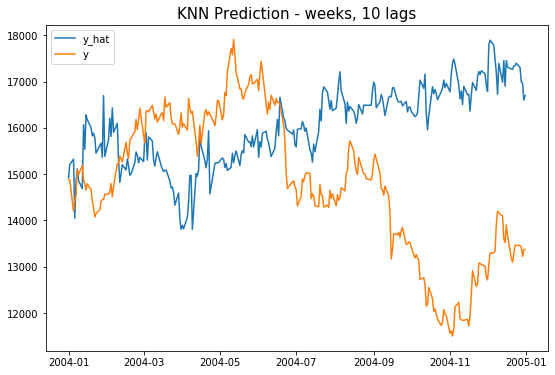

{'1': 1971.846306278373, '2': 1990.1314177168879, '3': 2017.7355301078792, '4': 2103.286353541897, '5': 2052.507215200683, '6': 2053.270834869709, '7': 2071.357068371575}


In [55]:
from sklearn import neighbors

cv_results = {}

for K in range(7):
    K = K+1
    regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

    print()
    print('K: ', K)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item+rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(K)] = mae

    # To find the best/optimal parameters


    
plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('KNN Prediction - weeks, 10 lags', fontsize=15)

plt.show()

print(cv_results)

ds
2004-01-01    14877.0
2004-01-02    14877.0
2004-01-05    14201.0
2004-01-06    14423.0
2004-01-07    14550.0
dtype: float64
ds
2001-01-29    6040.0
2001-01-30    6090.0
2001-01-31    5958.0
2001-02-01    6054.0
2001-02-02    6116.0
dtype: float64


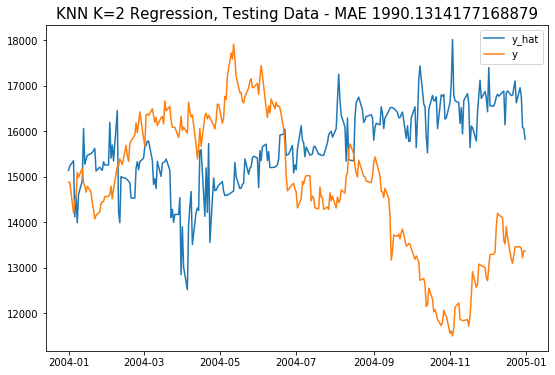

Mean Absolute Error: 1990.1314177168879
Mean Squared Error: 5720275.312136189
Root Mean Squared Error: 2391.709704821258


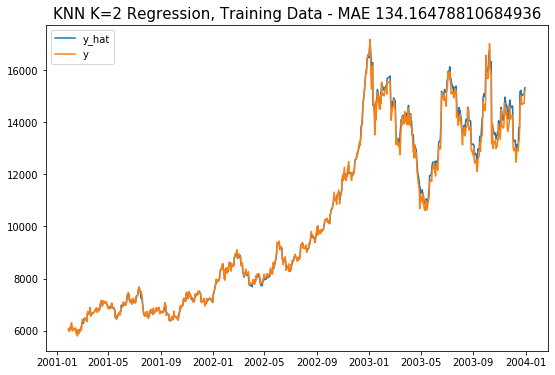

Mean Absolute Error: 134.16478810684936
Mean Squared Error: 40390.25152609091
Root Mean Squared Error: 200.97326072413443


In [56]:
K = 2
regressor = neighbors.KNeighborsRegressor(n_neighbors=K)
regressor.fit(X_train, y_train)

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('KNN K=' +str(K) +' Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/KNN_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']
 


plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('KNN K=' +str(K)+' Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/KNN_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))



{'learning_rate': 0.0001, 'n_estimators': 50}
Mean Absolute Error: 2860.58147112579
Mean Squared Error: 13082665.576052396
Root Mean Squared Error: 3616.996761963217

{'learning_rate': 0.0001, 'n_estimators': 100}
Mean Absolute Error: 2994.669151259048
Mean Squared Error: 14386880.681054164
Root Mean Squared Error: 3793.0041762505566

{'learning_rate': 0.0001, 'n_estimators': 150}
Mean Absolute Error: 2966.5535228373183
Mean Squared Error: 14063768.600439781
Root Mean Squared Error: 3750.1691429107277

{'learning_rate': 0.0001, 'n_estimators': 200}
Mean Absolute Error: 2966.817454563528
Mean Squared Error: 14160243.316986373
Root Mean Squared Error: 3763.0098746862695

{'learning_rate': 0.0001, 'n_estimators': 250}
Mean Absolute Error: 2981.6895769733146
Mean Squared Error: 14347269.684195023
Root Mean Squared Error: 3787.7789909384924

{'learning_rate': 0.0001, 'n_estimators': 300}
Mean Absolute Error: 2941.686115686489
Mean Squared Error: 13881746.777272878
Root Mean Squared Error: 

Mean Absolute Error: 3255.732888307099
Mean Squared Error: 18121553.76783493
Root Mean Squared Error: 4256.941832799097

{'learning_rate': 0.3, 'n_estimators': 300}
Mean Absolute Error: 3297.410923300642
Mean Squared Error: 18600671.811399538
Root Mean Squared Error: 4312.8496161354315

{'learning_rate': 0.3, 'n_estimators': 350}
Mean Absolute Error: 3271.7936317472095
Mean Squared Error: 18298073.960367523
Root Mean Squared Error: 4277.62480359925

{'learning_rate': 0.3, 'n_estimators': 400}
Mean Absolute Error: 3266.230885049437
Mean Squared Error: 18202155.108719155
Root Mean Squared Error: 4266.398376701261

{'learning_rate': 0.3, 'n_estimators': 450}
Mean Absolute Error: 3291.0340477942664
Mean Squared Error: 18598863.35552997
Root Mean Squared Error: 4312.639951993439

Adaboost CV Results
{'learning_rate': 0.0001, 'n_estimators': 50} 2860.58147112579
{'learning_rate': 0.0001, 'n_estimators': 100} 2994.669151259048
{'learning_rate': 0.0001, 'n_estimators': 150} 2966.5535228373183


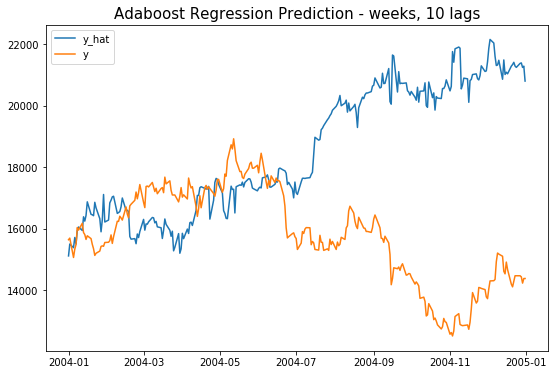

In [57]:
from sklearn.ensemble import AdaBoostRegressor

params1= ParameterGrid({'n_estimators' : [50, 100, 150, 200, 250, 300, 350, 400, 450],
                            'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]})

cv_results = {}

for params in params1:

    regressor = AdaBoostRegressor(**params, random_state=1)


    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)


    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Adaboost CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test Accuracy: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()
    
    
    

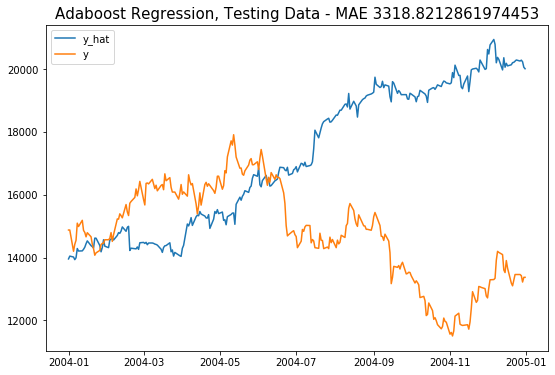

Mean Absolute Error: 3318.8212861974453
Mean Squared Error: 17958999.236988574
Root Mean Squared Error: 4237.805946122188


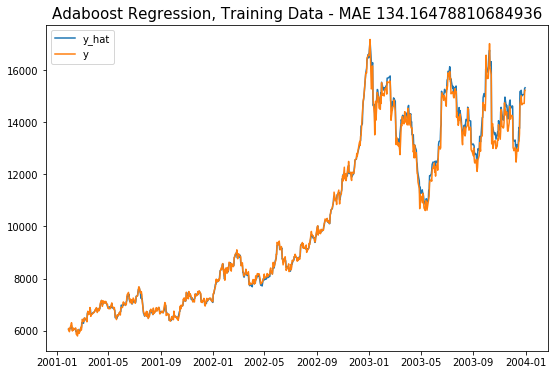

Mean Absolute Error: 134.16478810684936
Mean Squared Error: 40390.25152609091
Root Mean Squared Error: 200.97326072413443


In [58]:
regressor = AdaBoostRegressor(learning_rate=0.1, n_estimators=50, random_state=1)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
#print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

#print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/adaboost_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/adaboost_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))


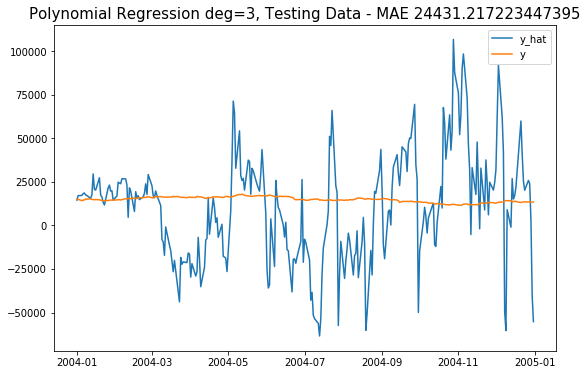

Mean Absolute Error: 24431.217223447395
Mean Squared Error: 1015987090.2631657
Root Mean Squared Error: 31874.552393142178


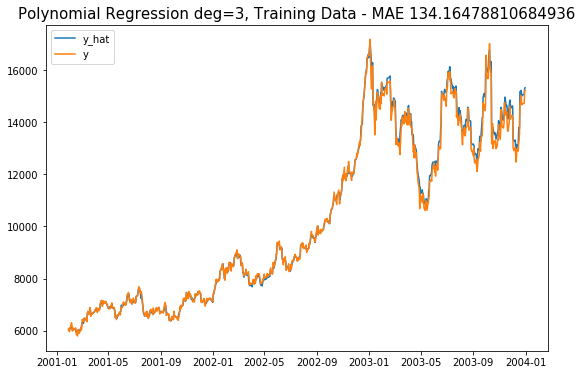

Mean Absolute Error: 134.16478810684936
Mean Squared Error: 40390.25152609091
Root Mean Squared Error: 200.97326072413443


In [60]:
polynomial_features= PolynomialFeatures(degree=3)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

y_pred = y_poly_pred


X_poly_train = polynomial_features.fit_transform(X_train)
y_poly_pred = regressor.predict(X_poly_train)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_train.index

y_pred_train_unscaled = y_poly_pred


##############

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
#print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

#print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression deg=3, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/polynomial_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression deg=3, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/polynomial_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))






{'alpha': 1e-05}
Mean Absolute Error: 3604.6704820935724
Mean Squared Error: 18445475.230753116
Root Mean Squared Error: 4294.819580698719

{'alpha': 0.0001}
Mean Absolute Error: 3604.6704775591547
Mean Squared Error: 18445475.180746377
Root Mean Squared Error: 4294.819574876968

{'alpha': 0.001}
Mean Absolute Error: 3604.670431939005
Mean Squared Error: 18445474.67722607
Root Mean Squared Error: 4294.819516257473

{'alpha': 0.01}
Mean Absolute Error: 3604.6699760552374
Mean Squared Error: 18445469.64178186
Root Mean Squared Error: 4294.818930034404

{'alpha': 0.1}
Mean Absolute Error: 3604.6654239069308
Mean Squared Error: 18445419.36750844
Root Mean Squared Error: 4294.813077132512

{'alpha': 1}
Mean Absolute Error: 3604.6198541310973
Mean Squared Error: 18444915.763689008
Root Mean Squared Error: 4294.75444742642

Ridge CV Results
{'alpha': 1e-05} 3604.6704820935724
{'alpha': 0.0001} 3604.6704775591547
{'alpha': 0.001} 3604.670431939005
{'alpha': 0.01} 3604.6699760552374
{'alpha': 

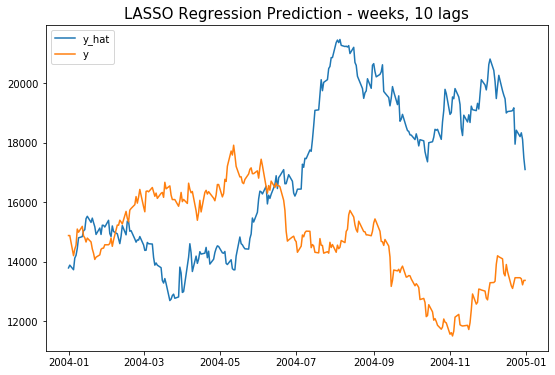

In [61]:
from sklearn import linear_model

params1= ParameterGrid({'alpha' : [ .00001 ,.0001, .001, .01, .1, 1]
                            })

cv_results = {}

for params in params1:

    regressor = linear_model.Lasso(**params, random_state=1)

    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)

    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Ridge CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test MAE: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('LASSO Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()


{'alpha': 1e-05}
Mean Absolute Error: 3604.6704820935724
Mean Squared Error: 18445475.230753116
Root Mean Squared Error: 4294.819580698719

{'alpha': 0.0001}
Mean Absolute Error: 3604.6704775591547
Mean Squared Error: 18445475.180746377
Root Mean Squared Error: 4294.819574876968

{'alpha': 0.001}
Mean Absolute Error: 3604.670431939005
Mean Squared Error: 18445474.67722607
Root Mean Squared Error: 4294.819516257473

{'alpha': 0.01}
Mean Absolute Error: 3604.6699760552374
Mean Squared Error: 18445469.64178186
Root Mean Squared Error: 4294.818930034404

{'alpha': 0.1}
Mean Absolute Error: 3604.6654239069308
Mean Squared Error: 18445419.36750844
Root Mean Squared Error: 4294.813077132512

{'alpha': 1}
Mean Absolute Error: 3604.6198541310973
Mean Squared Error: 18444915.763689008
Root Mean Squared Error: 4294.75444742642

Ridge CV Results
{'alpha': 1e-05} 3604.6704820935724
{'alpha': 0.0001} 3604.6704775591547
{'alpha': 0.001} 3604.670431939005
{'alpha': 0.01} 3604.6699760552374
{'alpha': 

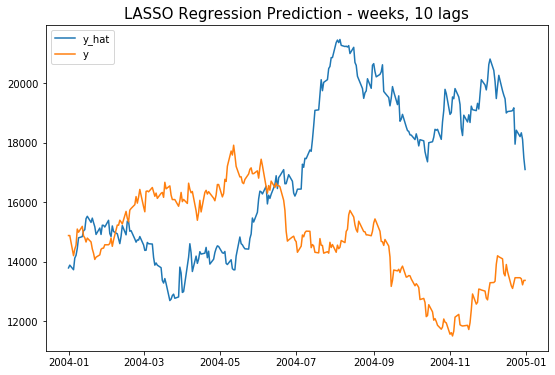

In [62]:
from sklearn import linear_model

params1= ParameterGrid({'alpha' : [ .00001 ,.0001, .001, .01, .1, 1]
                            })

cv_results = {}

for params in params1:

    regressor = linear_model.Lasso(**params, random_state=1)

    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)

    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Ridge CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test MAE: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('LASSO Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()

In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) **2).mean())
    #return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [47]:
print('mape', mean_absolute_percentage_error(cmp_df['y'], cmp_df['yhat']))

print('rmse', root_mean_squared_error(cmp_df['y'], cmp_df['yhat']))

mape 219.83967767924054
rmse 0.05529372373011725
